In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import time
import json
import random

import imgaug.augmenters as iaa
import numpy as np
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset

# get the FLOPs
from fvcore.nn import FlopCountAnalysis, flop_count_table, parameter_count, flop_count_str
import torchprofile
# # decrease Cuda memory usage
# from torch.cuda.amp import GradScaler, autocast # use gradscaler amd mixed precision training

ModuleNotFoundError: No module named 'torchsummary'

# checking torch and tf

In [1]:
import tensorflow as tf
#from tensorflow.python.platform import build_info as tf_build_info
#print(tf.__version__)
#print("CUDA Version:", tf_build_info.cuda_version)
#print("cuDNN Version:", tf_build_info.cudnn_version)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [2]:
print('TensorFlow version:',tf.__version__)

TensorFlow version: 2.7.0


In [3]:
print("CUDA version: ", tf.sysconfig.get_build_info()["cuda_version"])

CUDA version:  11.2


In [4]:
print("cuDNN version: ", tf.sysconfig.get_build_info()["cudnn_version"])

cuDNN version:  8


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-09-30 11:05:52.271759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-30 11:05:52.309717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-30 11:05:52.313048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
import torch
print(torch.__version__)
print('CUDA version:',torch.version.cuda)
print('cuDNN version:',torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

ModuleNotFoundError: No module named 'torch'

In [3]:
import torch
print("Is CUDA available: ", torch.cuda.is_available())
print("Number of GPUs available: ", torch.cuda.device_count())
print("CUDA device name: ", torch.cuda.get_device_name(0))


Is CUDA available:  True
Number of GPUs available:  1
CUDA device name:  NVIDIA GeForce RTX 3050 Laptop GPU


# DLC imports

In [1]:
import deeplabcut
print(deeplabcut.__version__)

Loading DLC 3.0.0rc4...
3.0.0rc4


In [2]:
print(deeplabcut.__file__)

/home/matthew/anaconda3/envs/DEEPLABCUT_PYTORCH_v2/lib/python3.10/site-packages/deeplabcut/__init__.py


In [3]:
# DLC imports (used with DEEPLABCUT env)
import pandas as pd
import os
import pickle
import json
import numpy as np

# SLEAP imports

In [1]:
import sleap

In [2]:
# check that we are using the cloned repository
# output should read something like: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/__init__.py
# if it is a path to the conda env lib, then it is incorrect
print(sleap.__file__)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/__init__.py


In [3]:
sleap.versions()

SLEAP: 1.4.1a2
TensorFlow: 2.7.0
Numpy: 1.21.5
Python: 3.7.12
OS: Linux-6.1.0-0.deb11.17-amd64-x86_64-with-debian-11.0


In [4]:
sleap.system_summary()

GPUs: 1/1 available
  Device: /physical_device:GPU:0
         Available: True
       Initialized: False
     Memory growth: None


2024-10-04 13:19:54.918992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-04 13:19:54.952537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-04 13:19:54.955835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# imports for model evaluation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json

mpl.style.use("seaborn-deep")

In [6]:
# DLC imports (used with DEEPLABCUT env)
import pandas as pd
import h5py
# import os
# import pickle
# import json
# import numpy as np

# 0.0 Important Functions

In [ ]:
# load ids into list 
def load_file_to_list(file_path):
    """
    loads a text file to a list with each entry on a new line becoming a new entry in the list.

    :param file_path: Path to the file where the list should be saved.
    :return list of data from file
    """
    # Open the file for writing
    lst = []
    with open(file_path, 'r') as file:
        # Write each item on a new line
        for line in file:
            lst.append(line.strip())
    return lst

In [ ]:
# function to load the image data into an arr
# in the same order as the annotations and ids are stored (use id list for this)

# The load image data function may take a while to run

def load_image_data(ids_to_load, image_folder, crop_ext):

  # list for loading image data
  selected_imgs = []

  # for loop for loading image data that is present in the list of ids
  for i, img_id in enumerate(ids_to_load):

    # load the image
    img_path = os.path.join(image_folder, img_id+crop_ext)
    #print(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    #print(img)

    # change the img to RGB from BGR as plt uses RGB colour scale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # scaling the pixel values to [0, 1] (you don't need to scal them back)
    img = img/255

    selected_imgs.append(img)

  # Convert the list of images to a NumPy array
  selected_imgs_array = np.array(selected_imgs)
  
  return selected_imgs_array

In [ ]:
def df_to_json(df, path):
    """
    Converts a DataFrame to a .json file.

    Parameters:
    df (pd.DataFrame): The DataFrame to be converted to JSON.
    path (str): The path (including file name) where the .json file will be saved.
    """
    df.to_json(path, orient='records', indent=4)

In [ ]:

def json_to_df(path):
    """
    Converts a .json file to a DataFrame.

    Parameters:
    path (str): The path to the .json file that will be read.

    Returns:
    pd.DataFrame: The DataFrame created from the JSON file.
    """
    #print(path)
    df = pd.read_json(path, orient='records')
    #print(f"JSON file has been successfully converted to DataFrame.")
    return df

In [ ]:
def create_data_lists(df_to_list, list_of_cols):

  # create temp lists
  keypoints_temp = []

  # step through the rows and
  for _, row in df_to_list.iterrows():

    # extract the data arrays
    keypoints_data = row[list_of_cols].values

    # adding data to the list
    keypoints_temp.append(keypoints_data)

  # Convert the list to a NumPy array and make sure that they are float32
  keypoints_array = np.array(keypoints_temp, dtype=np.float32)
  
  return keypoints_array

In [ ]:
def set_dtypes_df_full_annotation_abs(df):
    df['vid_id'] = df['vid_id'].astype(str)
    df['img_id'] = df['img_id'].astype(str)
    df['bbox_id'] = df['bbox_id'].astype(str)
    df['bbox_c_x'] = df['bbox_c_x'].astype('float32')
    df['bbox_c_y'] = df['bbox_c_y'].astype('float32')
    df['bbox_w'] = df['bbox_w'].astype('float32')
    df['bbox_h'] = df['bbox_h'].astype('float32')
    df['Head_x'] = df['Head_x'].astype('float32')
    df['Head_y'] = df['Head_y'].astype('float32')
    df['Beak_x'] = df['Beak_x'].astype('float32')
    df['Beak_y'] = df['Beak_y'].astype('float32')
    df['Body_top_x'] = df['Body_top_x'].astype('float32')
    df['Body_top_y'] = df['Body_top_y'].astype('float32')
    df['RFlipper_mid_x'] = df['RFlipper_mid_x'].astype('float32')
    df['RFlipper_mid_y'] = df['RFlipper_mid_y'].astype('float32')
    df['LFlipper_mid_x'] = df['LFlipper_mid_x'].astype('float32')
    df['LFlipper_mid_y'] = df['LFlipper_mid_y'].astype('float32')
    df['Body_bottom_x'] = df['Body_bottom_x'].astype('float32')
    df['Body_bottom_y'] = df['Body_bottom_y'].astype('float32')
    df['RFoot_x'] = df['RFoot_x'].astype('float32')
    df['RFoot_y'] = df['RFoot_y'].astype('float32')
    df['LFoot_x'] = df['LFoot_x'].astype('float32')
    df['LFoot_y'] = df['LFoot_y'].astype('float32')
    df['kp_outside_best_bbox'] = df['kp_outside_best_bbox'].astype('float32')
    df['kp_missing'] = df['kp_missing'].astype('float32')
    df['kp_primary_missing'] = df['kp_primary_missing'].astype(bool)
    df['img_width'] = df['img_width'].astype('float32')
    df['img_height'] = df['img_height'].astype('float32')
    df['bbox_max_h_w'] = df['bbox_max_h_w'].astype('float32')
    return df

In [ ]:
def unnorm_keypoints(img_size, keypoints, kp_to_null=None):
    """
    De-normalizes keypoints based on image size and returns the de-normalized keypoints along with 
    the positions of any missing or nullified keypoints.

    Parameters:
    - img_size: Tuple of the image dimensions (height, width).
    - keypoints: List of normalized keypoints (with values between -1 and 1).
    - kp_to_null: Optional. List of indices where the keypoints should be nulled (set to NaN).

    Returns:
    - new_keypoints: List of de-normalized keypoints where each coordinate is scaled back to the 
                     image's pixel dimensions.
    - missing_kp: List of indices where the keypoints were either originally set to -10 (indicating 
                  missing keypoints) or explicitly nullified by the kp_to_null list.
    """
    
    # Extract image width and height
    readjust_x = img_size[0]  # width of the image
    readjust_y = img_size[1]  # height of the image

    new_keypoints = []  # List to store the de-normalized keypoints
    missing_kp = []     # List to store the indices of missing or nullified keypoints

    # Iterate through each keypoint
    for i, keypoint in enumerate(keypoints):
        # Null keypoints if they are -10 or if they are specified in kp_to_null
        if keypoint == -10 or (kp_to_null and i in kp_to_null):
            keypoint = np.nan  # Set keypoint to NaN
            missing_kp.append(i)  # Record the index of the missing or nullified keypoint

        # De-normalize the x-coordinates
        if i % 2 == 0:  # Even indices are x-coordinates
            keypoint = keypoint * readjust_x + readjust_x / 2
        # De-normalize the y-coordinates
        else:  # Odd indices are y-coordinates
            keypoint = keypoint * readjust_y + readjust_y / 2

        new_keypoints.append(keypoint)  # Append the de-normalized keypoint to the list

    return new_keypoints, missing_kp

In [ ]:
def norm_keypoints(img_size, keypoints):
    """
    Normalizes keypoints based on image size and replaces any NaN values with -10.

    Parameters:
    - img_size: Tuple of the image dimensions (width, height).
    - keypoints: List of de-normalized keypoints where each coordinate is in pixel dimensions.

    Returns:
    - norm_keypoints: List of normalized keypoints where each coordinate is scaled to the range 
                      [-1, 1] relative to the image size, with NaNs replaced by -10.
    """
    
    # Extract image width and height
    readjust_x = img_size[0]  # width of the image
    readjust_y = img_size[1]  # height of the image

    norm_keypoints = []  # List to store the normalized keypoints

    # Iterate through each keypoint
    for i, keypoint in enumerate(keypoints):
        # Replace NaN values with -10
        if np.isnan(keypoint):
            keypoint = -10.0
        else:
            # Normalize the x-coordinates
            if i % 2 == 0:  # Even indices are x-coordinates
                keypoint = (keypoint - readjust_x / 2) / readjust_x
            # Normalize the y-coordinates
            else:  # Odd indices are y-coordinates
                keypoint = (keypoint - readjust_y / 2) / readjust_y

        norm_keypoints.append(keypoint)  # Append the normalized keypoint to the list

    return norm_keypoints

In [ ]:
# Denormalize keypoints for an array of images
def unnorm_keypoints_arr(kp_arr, img_arr):
    """
    Denormalizes keypoints for each image in the array based on the corresponding image size.
    It converts normalized keypoints (range [-1, 1]) back to pixel coordinates.

    Parameters:
    - kp_arr: Array of normalized keypoints, where each entry is a list of keypoints for an image.
              The keypoints are expected to be in the format [x1, y1, x2, y2, ...].
    - img_arr: Array of images. The size of each image is used to scale the keypoints back 
               to their pixel coordinates.

    Returns:
    - kp_abs_arr: Array of denormalized keypoints where each entry corresponds to the denormalized 
                  keypoints for the corresponding image in `img_arr`.
    """

    kp_abs_list = []  # List to store the denormalized keypoints for each image

    # Iterate through each set of keypoints and corresponding image
    for i, kp in enumerate(kp_arr):
        img_size = img_arr[i].shape  # Get the size of the current image (height, width, channels)

        # Denormalize the keypoints based on the image size
        kp_abs, missing_kp = unnorm_keypoints(img_size, kp_arr[i])

        # Save the denormalized keypoints to the list
        kp_abs_list.append(kp_abs)
    
    # Convert the list of denormalized keypoints to a NumPy array
    kp_abs_arr = np.array(kp_abs_list)

    return kp_abs_arr


In [ ]:
# Normalize keypoints for an array of images
def norm_keypoints_arr(kp_arr, img_arr):
    """
    Normalizes keypoints for each image in the array based on the corresponding image size.
    It converts keypoints from pixel coordinates back to normalized coordinates (range [-1, 1]).

    Parameters:
    - kp_arr: Array of keypoints, where each entry is a list of keypoints for an image.
              The keypoints are expected to be in the format [x1, y1, x2, y2, ...] 
              with pixel coordinates.
    - img_arr: Array of images. The size of each image is used to scale the keypoints 
               to normalized coordinates.

    Returns:
    - kp_norm_arr: Array of normalized keypoints where each entry corresponds to the normalized 
                   keypoints for the corresponding image in `img_arr`.
    """
        
    kp_norm_list = []  # List to store the normalized keypoints for each image

    # Iterate through each set of keypoints and corresponding image
    for i, kp in enumerate(kp_arr):
        img_size = img_arr[i].shape  # Get the size of the current image (height, width, channels)

        # Normalize the keypoints based on the image size
        kp_norm = norm_keypoints(img_size, kp_arr[i])

        # Save the normalized keypoints to the list
        kp_norm_list.append(kp_norm)
    
    # Convert the list of normalized keypoints to a NumPy array
    kp_norm_arr = np.array(kp_norm_list)  

    return kp_norm_arr

In [ ]:
# Apply augmentation to images and keypoints
def apply_aug(img_arr_orig, kp_arr_orig, aug, num_of_kp=8):
    """
    Applies augmentation to a batch of images and their corresponding keypoints.

    Parameters:
    - img_arr_orig: Original array of images. Shape should be (num_imgs, height, width, channels).
    - kp_arr_orig: Original array of keypoints. Shape should be (num_imgs, num_of_kp*2), where each 
                   keypoint is represented by its x and y coordinates in pixel values.
    - aug: An imgaug augmentation sequence or augmenter to apply to the images and keypoints.
    - num_of_kp: Optional. Number of keypoints per image (default is 8).

    Returns:
    - img_arr_aug: Augmented array of images. Same shape as `img_arr_orig`.
    - kp_arr_aug: Augmented array of keypoints. Same shape as `kp_arr_orig`.
    """
    # print(img_arr_orig.shape)
    #print(kp_arr_orig.shape)
    
    # Initialize lists to store augmented images and keypoints
    aug_img = []  # List for augmented images
    aug_kp = []   # List for augmented keypoints

    # Get the number of images in the batch
    num_imgs = img_arr_orig.shape[0]
    #print(num_imgs)

    # Loop over each image and its corresponding keypoints
    for i in range(num_imgs):
        image = img_arr_orig[i]  # Extract the i-th image
        #print(image.shape)
        
        # Convert keypoints to KeypointsOnImage format for imgaug
        keypoints = kp_arr_orig[i]
        #print(keypoints)
        kps = [Keypoint(x=keypoints[j*2], y=keypoints[j*2+1]) for j in range(num_of_kp)]
        kps_on_image = KeypointsOnImage(kps, shape=image.shape)
        
        # Apply the augmentation to the image and keypoints
        image_aug, kps_aug = aug(image=image, keypoints=kps_on_image)
        
        # Convert augmented keypoints back to the original flattened format [x1, y1, x2, y2, ...]
        keypoints_aug = []
        for kp in kps_aug.keypoints:
            keypoints_aug.extend([kp.x, kp.y])
        
        # Append the augmented image and keypoints to their respective lists
        aug_img.append(image_aug)
        aug_kp.append(keypoints_aug)

    # Convert the lists of augmented images and keypoints back to NumPy arrays
    img_arr_aug = np.array(aug_img)
    kp_arr_aug = np.array(aug_kp)

    return img_arr_aug, kp_arr_aug


In [ ]:
def detect_padding(image):
    """
    Detects if padding is on the x-axis (left and right) or y-axis (top and bottom)
    of the image and calculates the padding size on one side.

    Parameters:
    - image: A NumPy array representing the image. The shape should be (width, height, channels).

    Returns:
    - is_padding_x: True if padding is on the x-axis, False if padding is on the y-axis.
    - padding_size: The size of the padding on one side in pixels.
    """

    width, height, _ = image.shape
    
    # Check for padding along the x-axis (left and right)
    left_column = image[:, 0, :]#image[0, :, :]  # The first column (left side)
    right_column = image[:, -1, :] #image[-1, :, :]  # The last column (right side)

    # Check for padding along the y-axis (top and bottom)
    top_row = image[:, 0, :]  # The first row (top side)
    bottom_row = image[:, -1, :]  # The last row (bottom side)
    #print(image[:, 5, :] *255)
    #print(left_column*255)
    
    # Check if the columns are fully black (indicating padding)
    if np.all(left_column*255 < 30) and np.all(right_column*255 < 30):
        # Padding is along the x-axis
        is_padding_x = True
        #plot_img(image)
        # Calculate padding size
        #padding_size = np.sum(image[0, :, 0]*255 < 30) // 2  # Count black pixels on one side
        # if padding_size > 60:
        sum1 = np.sum(image[5, :, 0]*255 < 20) // 2
        sum2 = np.sum(image[10, :, 0]*255 < 20) // 2
        sum3 = np.sum(image[60, :, 0]*255 < 20) // 2
        sum4 = np.sum(image[110, :, 0]*255 < 20) // 2
        sum5 = np.sum(image[-60, :, 0]*255 < 20) // 2
        sum6 = np.sum(image[-10, :, 0]*255 < 20) // 2
        sum7 = np.sum(image[-5, :, 0]*255 < 20) // 2
        padding_size = min(sum1, sum2, sum3, sum4, sum5, sum6, sum7)
        #     padding_size = max(average - 5, 1)
        # if padding_size > 60:
        #     sum1 = np.sum(image[5, :, 0]*255 < 10) // 2
        #     sum2 = np.sum(image[10, :, 0]*255 < 10) // 2
        #     sum3 = np.sum(image[60, :, 0]*255 < 10) // 2
        #     sum4 = np.sum(image[110, :, 0]*255 < 10) // 2
        #     sum5 = np.sum(image[-60, :, 0]*255 < 10) // 2
        #     sum6 = np.sum(image[-10, :, 0]*255 < 10) // 2
        #     sum7 = np.sum(image[-5, :, 0]*255 < 10) // 2
        #     average = (sum1 + sum2 + sum3 + sum4 + sum5 + sum6 + sum7) // 7  # Floor division for rounding down
        #     padding_size = max(average - 5, 1)
        if padding_size > 20: 
            padding_size = 20

    else:
        # Padding is along the y-axis (top and bottom)
        is_padding_x = False
        # Calculate padding size
        padding_size = np.sum(image[:, 0, 0]*255 < 30) // 2  # Count black pixels on one side
        # if padding_size > 60:
        sum1 = np.sum(image[:, 5, 0]*255 < 20) // 2
        sum2 = np.sum(image[:, 10, 0]*255 < 20) // 2
        sum3 = np.sum(image[:, 60, 0]*255 < 20) // 2
        sum4 = np.sum(image[:, 110, 0]*255 < 20) // 2
        sum5 = np.sum(image[:, -60, 0]*255 < 20) // 2
        sum6 = np.sum(image[:, -10, 0]*255 < 20) // 2
        sum7 = np.sum(image[:, -5, 0]*255 < 20) // 2
        padding_size = min(sum1, sum2, sum3, sum4, sum5, sum6, sum7)
        #     padding_size = max(average - 5, 1)
        # if padding_size > 60:
        #     sum1 = np.sum(image[:, 5, 0]*255 < 10) // 2
        #     sum2 = np.sum(image[:, 10, 0]*255 < 10) // 2
        #     sum3 = np.sum(image[:, 60, 0]*255 < 10) // 2
        #     sum4 = np.sum(image[:, 110, 0]*255 < 10) // 2
        #     sum5 = np.sum(image[:, -60, 0]*255 < 10) // 2
        #     sum6 = np.sum(image[:, -10, 0]*255 < 10) // 2
        #     sum7 = np.sum(image[:, -5, 0]*255 < 10) // 2
        #     average = (sum1 + sum2 + sum3 + sum4 + sum5 + sum6 + sum7) // 7  # Floor division for rounding down
        #     padding_size = max(average - 5, 1)
        if padding_size > 20: 
            padding_size = 20

    return is_padding_x, padding_size

In [ ]:
def apply_aug_translate(train_imgs_array, train_kp_array_abs):

    
    # Get the number of images in the batch
    num_imgs = train_imgs_array.shape[0]
    # print(num_imgs)

    # creat empty arrays
    train_imgs_array_aug_trans = np.empty((0, train_imgs_array.shape[1], train_imgs_array.shape[2], train_imgs_array.shape[3]), dtype=train_imgs_array.dtype)
    train_kp_array_aug_trans = np.empty((0, train_kp_array_abs.shape[1]), dtype=train_kp_array_abs.dtype)

    # print(train_imgs_array_aug_trans.shape)
    # print(train_kp_array_aug_trans.shape)

    # Loop over each image and its corresponding keypoints
    for i in range(num_imgs):
        image = train_imgs_array[i]  # Extract the i-th image
        kp = train_kp_array_abs[i]
        # print(i)
        # print(image.shape)
        # print(kp.shape)

        is_padding_x, padding_size = detect_padding(image)
        # print(f'this: {i}')
        # print(is_padding_x)
        # print(padding_size)

        if is_padding_x:
            seq_trans_x_left = iaa.Sequential([
                iaa.TranslateX(px=(-padding_size, -padding_size)),
            ])
            seq_trans_x_right = iaa.Sequential([
                iaa.TranslateX(px=(padding_size, padding_size)),
            ])

            # Convert to shape (1, 220, 220, 3) and (1, 16)
            image = np.expand_dims(image, axis=0)
            #print(is_padding_x)
            #print(image.shape)
            #print(i)
            kp = np.expand_dims(kp, axis=0)

            # apply augmentations
            single_trans_x_left_img_arr, single_trans_x_left_kp_arr = apply_aug(image, kp, seq_trans_x_left)
            single_trans_x_right_img_arr, single_trans_x_right_kp_arr = apply_aug(image, kp, seq_trans_x_right)

            #save to image array
            train_imgs_array_aug_trans = np.concatenate((train_imgs_array_aug_trans, single_trans_x_left_img_arr), axis=0)
            train_imgs_array_aug_trans = np.concatenate((train_imgs_array_aug_trans, single_trans_x_right_img_arr), axis=0)
            #save to kp array
            train_kp_array_aug_trans = np.concatenate((train_kp_array_aug_trans, single_trans_x_left_kp_arr), axis=0)
            train_kp_array_aug_trans = np.concatenate((train_kp_array_aug_trans, single_trans_x_right_kp_arr), axis=0)

        else :
            seq_trans_y_up = iaa.Sequential([
                iaa.TranslateY(px=(-padding_size, -padding_size)),
            ])
            seq_trans_y_down = iaa.Sequential([
                iaa.TranslateY(px=(padding_size, padding_size)),
            ])

            # Convert to shape (1, 220, 220, 3) and (1, 16)
            image = np.expand_dims(image, axis=0)
            #print(is_padding_x)
            #print(image.shape)
            #print(i)
            kp = np.expand_dims(kp, axis=0)

            # apply augmentations
            single_trans_y_up_img_arr, single_trans_y_up_kp_arr = apply_aug(image, kp, seq_trans_y_up)
            single_trans_y_down_img_arr, single_trans_y_down_kp_arr = apply_aug(image, kp, seq_trans_y_down)

            #save to image array
            train_imgs_array_aug_trans = np.concatenate((train_imgs_array_aug_trans, single_trans_y_up_img_arr), axis=0)
            train_imgs_array_aug_trans = np.concatenate((train_imgs_array_aug_trans, single_trans_y_down_img_arr), axis=0)
            #save to kp array
            train_kp_array_aug_trans = np.concatenate((train_kp_array_aug_trans, single_trans_y_up_kp_arr), axis=0)
            train_kp_array_aug_trans = np.concatenate((train_kp_array_aug_trans, single_trans_y_down_kp_arr), axis=0)


    return train_imgs_array_aug_trans, train_kp_array_aug_trans

In [ ]:
def replace_out_of_img_kp(arr):
    """
    Finds and replaces the elements in the array that are outside the frame but not the missing ones.
    Specifically, elements greater than 0.5 are replaced with 0.5, and elements less than -0.5 but 
    greater than -9.0 are replaced with -0.5.

    Parameters:
    - arr: A NumPy array of shape (n, 16).

    Returns:
    - modified_arr: The modified NumPy array with replaced values.
    - count_replacements: The number of elements that were replaced.
    """
    # Make a copy of the array to avoid modifying the original array
    modified_arr = arr.copy()

    # Replace elements greater than 0.5 with 0.5
    count_pos_replacements = np.sum(modified_arr > 0.5)
    modified_arr[modified_arr > 0.5] = 0.49

    # Replace elements less than -0.5 but greater than -9.0 with -0.5
    count_neg_replacements = np.sum((modified_arr < -0.5) & (modified_arr > -9.0))
    modified_arr[(modified_arr < -0.5) & (modified_arr > -9.0)] = -0.49

    # Total count of replacements
    count_replacements = count_pos_replacements + count_neg_replacements

    return modified_arr, count_replacements

In [ ]:
def replace_out_of_img_kp(arr):
    """
    Finds and replaces the elements in the array that are outside the frame but not the missing ones.
    Specifically, elements greater than 0.5 are replaced with 0.5, and elements less than -0.5 but 
    greater than -9.0 are replaced with -0.5.

    Parameters:
    - arr: A NumPy array of shape (n, 16).

    Returns:
    - modified_arr: The modified NumPy array with replaced values.
    - count_replacements: The number of elements that were replaced.
    """
    # Make a copy of the array to avoid modifying the original array
    modified_arr = arr.copy()

    # Replace elements greater than 0.5 with 0.5
    count_pos_replacements = np.sum(modified_arr > 0.5)
    modified_arr[modified_arr > 0.5] = 0.49

    # Replace elements less than -0.5 but greater than -9.0 with -0.5
    count_neg_replacements = np.sum((modified_arr < -0.5) & (modified_arr > -9.0))
    modified_arr[(modified_arr < -0.5) & (modified_arr > -9.0)] = -0.49

    # Total count of replacements
    count_replacements = count_pos_replacements + count_neg_replacements

    return modified_arr, count_replacements

In [ ]:
def masked_mse(y_true, y_pred):
    """
    Computes the mean squared error, ignoring the invisible keypoints.
    Assuming that -10.0 indicates an invisible keypoint.
    """
    # Create a mask where keypoints are visible
    mask = (y_true != -10.0).float().to(y_true.device)

    # Apply the mask to filter out invisible keypoints from both
    # the predictions and the true values
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask

    # Compute the Mean Squared Error only on the visible keypoints
    mse = F.mse_loss(y_pred_masked, y_true_masked, reduction='sum') / mask.sum()
    return mse

In [ ]:
# PCK
# put in a function that will use the max bbox if primary kp is missing
def pck_metric(y_true, y_pred, threshold=0.2):
    """
    Computes the Percentage of Correct Keypoints (PCK) metric.
    
    Parameters:
    y_true (torch.Tensor): The ground truth keypoints (batch_size, num_keypoints*2).
    y_pred (torch.Tensor): The predicted keypoints (batch_size, num_keypoints*2).
    threshold (float): The distance threshold for a keypoint to be considered correct.
                       Typically set relative to the size of the bounding box (e.g., 0.2).
    
    Returns:
    float: The percentage of correct keypoints.
    """
    # Create a mask where keypoints are visible (not equal to -10)
    mask = (y_true != -10.0).float().to(y_true.device)
    #print(mask)

    # Apply the mask to filter out invisible keypoints
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask

    # print(y_true_masked)
    # print(y_pred_masked)

    # Compute the Euclidean distance between the predicted and true keypoints
    distances = torch.sqrt((y_pred_masked[:, ::2] - y_true_masked[:, ::2]) ** 2 +
                           (y_pred_masked[:, 1::2] - y_true_masked[:, 1::2]) ** 2)
    
    #print(distances)
    
    # Normalize the distances (relative to the max and min y coord)
    Norm_max_min_kp = torch.max(y_true_masked[:, 1::2], dim=1)[0] - torch.min(y_true_masked[:, 1::2], dim=1)[0]
    # Normalise based on the distance between the head and the bottom of the body (position 0, 1 and )
    #print(y_true[:, 0],y_true[:,10],y_true[:, 1],y_true[:, 11])
    #print((y_true[:, 0] - y_true[:,10]) ** 2)
    #print((y_true[:, 1] - y_true[:, 11]) ** 2)
    Norm_head_lowerbody = torch.sqrt((y_true[:, 0] - y_true[:,10]) ** 2 +
                        (y_true[:, 1] - y_true[:, 11]) ** 2)
    #print(Norm_head_lowerbody)
    normalized_distances = distances / Norm_head_lowerbody[:, None]
    #print(distances)
    #print(normalized_distances)

    # Count the correct keypoints (distance <= threshold)
    correct_keypoints = (normalized_distances <= threshold).float() * mask[:, ::2]
    #print(correct_keypoints)

    # Calculate the PCK as the percentage of correct keypoints
    pck = correct_keypoints.sum() / mask[:, ::2].sum()
    return pck#.item()


In [ ]:
class DeepPoseModel(nn.Module):
    def __init__(self, nkeypoints=8):
        # Initializes the DeepPoseModel with the dataset and training configuration.
        super(DeepPoseModel, self).__init__()
        
        # The feature extractor part of the model, composed of several convolutional layers.
        self.features = nn.Sequential(
            # Conv2d: Input channels = 3 (RGB image), Output channels = 96, kernel size = 11x11,
            # stride = 4, padding = 4. 
            # Input: (batch_size, 3, 220, 220)
            # Output: (batch_size, 96, 55, 55)
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=4),
            
            # Local Response Normalization (LRN) over 5 neighboring channels
            nn.LocalResponseNorm(5),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),

            # Max pooling with 3x3 kernel and stride 2
            # output size: (batch_size, 96, 27, 27)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2d: Input channels = 96, Output channels = 256, kernel size = 5x5,
            # stride = 2, padding = 2.
            # Input: (batch_size, 96, 27, 27)
            # Output: (batch_size, 256, 27, 27)
            nn.Conv2d(48, 128, kernel_size=5, stride=1, padding=2),
            
            # Local Response Normalization (LRN) over 5 neighboring channels
            nn.LocalResponseNorm(5),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),

            # Max pooling with 3x3 kernel and stride 2
            # output size: (batch_size, 96, 13, 13)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2d: Input channels = 256, Output channels = 384, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 256, 13, 13)
            # Output: (batch_size, 384, 13, 13)
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Conv2d: Input channels = 384, Output channels = 384, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 384, 13, 13)
            # Output: (batch_size, 384, 13, 13)
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Conv2d: Input channels = 384, Output channels = 256, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 384, 13, 13)
            # Output: (batch_size, 256, 13, 13)
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # MaxPool2d: Kernel size = 3x3, stride = 2.
            # Input: (batch_size, 256, 13, 13)
            # Output: (batch_size, 256, 6, 6)
            # Max pooling with 3x3 kernel and stride 2
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # The classifier part of the model, composed of fully connected layers.
        self.classifier = nn.Sequential(
            # Flatten the input tensor
            # Input: (batch_size, 256, 6, 6)
            # Output: (batch_size, 256 * 6 * 6) = (batch_size, 9216)
            nn.Flatten(),
            
            # Linear layer with input size 6400 and output size 4096
            # Input: (batch_size, 6400)
            # Output: (batch_size, 4096)
            nn.Linear(128 * 6 * 6, 4096),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Dropout layer with 60% dropout rate
            nn.Dropout(0.6),
            
            # Linear layer with input size 4096 and output size 4096
            # Input: (batch_size, 4096)
            # Output: (batch_size, 4096)
            nn.Linear(4096, 4096),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Dropout layer with 60% dropout rate
            nn.Dropout(0.6),
            
            # Final linear layer with input size 4096 and output size nkeypoints * 2
            # Output is (nkeypoints * 2) coordinates (x, y) for each keypoint
            # Input: (batch_size, 4096)
            # Output: (batch_size, nkeypoints * 2)
            nn.Linear(4096, nkeypoints * 2)
        )
        
    def forward(self, x):
        # Define the forward pass through the network.
        # Pass input `x` through the feature extractor
        x = self.features(x)
        # Pass the result through the classifier to get the final output
        x = self.classifier(x)
        return x

In [ ]:
# def load_data_PyTorch(img_arr, kp_arr, batch_size, train_flag=True):
#     '''
#     conLoad data into PT dataLoader in specified batch size
    
#     Params
#     img_arr: images loaded into an array (i,255,255,3) and are converted to (i,3,255,255)
#     kp_arr: array of keypoints (i, num_kp*2)
#     batch_size: batch size 

#     Return:
#     PT_Dataset: containing input (x) and groundtruth (y)
#     PT_DataLoader: Dataloader containing dataset and batch size

#     '''

#     # create tensors from arrays and load them to the GPU
#     img_tensor = torch.tensor(img_arr, dtype=torch.float32).permute(0, 3, 1, 2)#.to('cuda')
#     kp_tensor = torch.tensor(kp_arr, dtype=torch.float32)#.to('cuda')

#     # Create a TensorDataset and DataLoader for training data
#     dataset = TensorDataset(img_tensor, kp_tensor)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=train_flag)

#     return dataloader

In [ ]:
def create_timestamped_dir(descriptor, base_dir='/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/'):
    """
    Creates a directory with a timestamp appended to the base directory name.
    Returns the path to the created directory.
    
    Parameters:
    descriptor: string describing the run generally model_dataDescriptor
    base_dir (str): The base directory name. Default is './training_results'.
    
    Returns:
    str: The path to the created directory.
    """
    # Get the current datetime and format it as YYYY-MM-DD_HH-MM-SS
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    base_dir_descriptor = f"{base_dir}{descriptor}"
    
    # Create the final directory name with the timestamp
    final_dir = f"{base_dir_descriptor}_{timestamp}"
    
    # Create the directory
    os.makedirs(final_dir, exist_ok=True)
    
    return final_dir


In [ ]:
def plot_training_curves(train_data, val_data, save_dir, data_descriptor='Loss', show_plot=False):
    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_data, label=f'Training {data_descriptor}')
    plt.plot(val_data, label=f'Validation {data_descriptor}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{data_descriptor}')
    plt.title(f'Training and Validation {data_descriptor} Over Epochs')
    plt.legend()

    # Save the plot
    plot_path = os.path.join(save_dir, f'{data_descriptor}_plot.png')
    plt.savefig(plot_path)
    #print(f'{data_descriptor} plot saved to {plot_path}')

    # Optionally, display the plot
    if show_plot == True:
        plt.show()

In [ ]:
def save_stats_and_models(model, epoch, val_loss, val_pck, save_dir, 
                     best_val_loss=None, best_val_pck=None, 
                     final_model=False, train_loss_list=None, val_loss_list=None, train_pck_list=None, val_pck_list=None):
    """
    Saves the best models based on validation loss, PCK value, and final model.
    Saves the train and val curves and results for training
    
    Parameters:
    - model (torch.nn.Module): The PyTorch model to be saved.
    - epoch (int): The current epoch number.
    - val_loss (float): The current validation loss.
    - val_pck (float): The current validation PCK value.
    - save_dir (str): The directory where the models will be saved.
    - best_val_loss (float): The best validation loss seen so far.
    - best_val_pck (float): The best validation PCK value seen so far.
    - final_model (bool): If True, saves the final model after all epochs.
    - train_loss_list (list): List of all the loss values from each epoch
    
    Returns:
    - best_val_loss (float): Updated best validation loss.
    - best_val_pck (float): Updated best validation PCK value.
    - model_save_path_best_val_loss
    - model_save_path_best_val_pck
    - final_model_path
    """
    model_save_path_best_val_loss = None
    model_save_path_best_val_pck = None
    
    # Check if the current model has the lowest validation loss
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        model_name = f'best_val_loss_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth'
        model_save_path_best_val_loss = os.path.join(save_dir, model_name)
        torch.save(model.state_dict(), model_save_path_best_val_loss)
        print(f'New best model saved with lowest validation loss to {model_save_path_best_val_loss}')
    
    # Check if the current model has the highest validation PCK
    if best_val_pck is None or val_pck > best_val_pck:
        best_val_pck = val_pck
        model_save_path_best_val_pck = os.path.join(save_dir, f'best_val_pck_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth')
        torch.save(model.state_dict(), model_save_path_best_val_pck)
        print(f'New best model saved with highest validation PCK to {model_save_path_best_val_pck}')
    
    # Save the final model and perform final stats evaluation and save
    if final_model:
        final_model_path = os.path.join(save_dir, f'final_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth')
        torch.save(model.state_dict(), final_model_path)
        print(f'Final model saved to {final_model_path}')
        plot_training_curves(train_loss_list, val_loss_list, save_dir, 'Loss', show_plot=True)
        plot_training_curves(train_pck_list, val_pck_list, save_dir, data_descriptor='PCK@0.1', show_plot=True)
        return best_val_loss, best_val_pck, model_save_path_best_val_loss, model_save_path_best_val_pck, final_model_path
    
    return best_val_loss, best_val_pck, model_save_path_best_val_loss, model_save_path_best_val_pck, None

In [ ]:
def augment_data(aug, train_imgs_array, train_kp_array): 
    #
    print('augmenting data...')
    
    # unnorm kp
    train_kp_array_abs = unnorm_keypoints_arr(train_kp_array, train_imgs_array)

    # specify augmentations
    # lrflip
    seq_lrflip = iaa.Sequential([
        iaa.Fliplr(1.0)
    ])
    # rotate clock
    seq_rotate_clock = iaa.Sequential([
        iaa.Affine(rotate=(5, 20)),
    ])
    #rotate anticlock
    seq_rotate_anticlock = iaa.Sequential([
        iaa.Affine(rotate=(-20, -5)),
    ])

    # apply augmentation
    #lrflip
    train_imgs_array_aug_lrflip, train_kp_array_aug_lrflip_abs = apply_aug(train_imgs_array, train_kp_array_abs, seq_lrflip)
    # rotate clock
    train_imgs_array_aug_rclock, train_kp_array_aug_rclock_abs = apply_aug(train_imgs_array, train_kp_array_abs, seq_rotate_clock)
    #rotate anticlock
    train_imgs_array_aug_ranticlock, train_kp_array_aug_ranticlock_abs = apply_aug(train_imgs_array, train_kp_array_abs, seq_rotate_anticlock)
    #translat
    train_imgs_array_aug_trans, train_kp_array_aug_trans = apply_aug_translate(train_imgs_array, train_kp_array_abs)

    # norm the aug kp
    #lrflip
    train_kp_array_aug_lrflip_norm = norm_keypoints_arr(train_kp_array_aug_lrflip_abs, train_imgs_array_aug_lrflip)  
    # rotate clock
    train_kp_array_aug_rclock_norm = norm_keypoints_arr(train_kp_array_aug_rclock_abs, train_imgs_array_aug_rclock)
    #rotate anticlock
    train_kp_array_aug_ranticlock_norm = norm_keypoints_arr(train_kp_array_aug_ranticlock_abs, train_imgs_array_aug_ranticlock)
    #translat
    train_kp_array_aug_trans_norm = norm_keypoints_arr(train_kp_array_aug_trans, train_imgs_array_aug_trans)

    # combine augmented arrays to original array
    #save to image array
    train_imgs_array_aug = np.concatenate((train_imgs_array, train_imgs_array_aug_lrflip), axis=0)
    train_imgs_array_aug = np.concatenate((train_imgs_array_aug, train_imgs_array_aug_rclock), axis=0)
    train_imgs_array_aug = np.concatenate((train_imgs_array_aug, train_imgs_array_aug_ranticlock), axis=0)
    train_imgs_array_aug = np.concatenate((train_imgs_array_aug, train_imgs_array_aug_trans), axis=0)
    #save to kp array
    train_kp_array_aug = np.concatenate((train_kp_array, train_kp_array_aug_lrflip_norm), axis=0)
    train_kp_array_aug = np.concatenate((train_kp_array_aug, train_kp_array_aug_rclock_norm), axis=0)
    train_kp_array_aug = np.concatenate((train_kp_array_aug, train_kp_array_aug_ranticlock_norm), axis=0)
    train_kp_array_aug = np.concatenate((train_kp_array_aug, train_kp_array_aug_trans_norm), axis=0)

    if aug == 2:
        #put additional augmentations here and then concat the arrays
        pass

    return train_imgs_array_aug, train_kp_array_aug


In [ ]:
def load_data(dataset, augmentation, crop_extension):

    print('laoding data ...')

    DATA_PARENT_PATH = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/'

    if dataset == 1: # Simple dataset 

        # variables
        dataset_name = 'PE_Simple'
        crop_extension = '_crop_220x220.jpg'# cropsize extension

        # loading ids to a list
        path = DATA_PARENT_PATH + dataset_name + '/ids_test_bbox.txt'
        ids_test_bbox = load_file_to_list(path)
        path = DATA_PARENT_PATH + dataset_name + '/ids_val_bbox.txt'
        ids_val_bbox=load_file_to_list(path)
        path = DATA_PARENT_PATH + dataset_name + '/ids_train_bbox.txt'
        ids_train_bbox=load_file_to_list(path)
        path = DATA_PARENT_PATH + dataset_name + '/ids_test.txt'
        ids_test=load_file_to_list(path)
        path = DATA_PARENT_PATH + dataset_name + '/ids_val.txt'
        ids_val=load_file_to_list(path)
        path = DATA_PARENT_PATH + dataset_name + '/ids_train.txt'
        ids_train=load_file_to_list(path)

        # load image data to array 
        img_dir = '/images'
        path = DATA_PARENT_PATH + dataset_name + img_dir + '/test'
        test_imgs_array = load_image_data(ids_test_bbox, path, crop_extension)
        path = DATA_PARENT_PATH + dataset_name + img_dir + '/val'
        val_imgs_array = load_image_data(ids_val_bbox, path, crop_extension)
        path = DATA_PARENT_PATH + dataset_name + img_dir + '/train'
        train_imgs_array = load_image_data(ids_train_bbox, path, crop_extension)

        # load annoation to df and set datatyoes
        anno_dir = '/annotation'
        path = DATA_PARENT_PATH + dataset_name + anno_dir + '/test_annotation_simple.json'
        df_full_annotation_norm_test = json_to_df(path)
        df_full_annotation_norm_test = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_test)
        path = DATA_PARENT_PATH + dataset_name + anno_dir + '/val_annotation_simple.json'
        df_full_annotation_norm_val = json_to_df(path)
        df_full_annotation_norm_val = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_val)
        path = DATA_PARENT_PATH + dataset_name + anno_dir + '/train_annotation_simple.json'
        df_full_annotation_norm_train = json_to_df(path)
        df_full_annotation_norm_train = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_train)

        # create lists with col names (potentially remove)
        id_cols = df_full_annotation_norm_test.iloc[:, :3].columns.to_list()
        bbox_cols = df_full_annotation_norm_test.iloc[:, 3:7].columns.to_list()
        kp_cols = df_full_annotation_norm_test.iloc[:, 7:23].columns.to_list()

        # load the kps to arrays
        test_kp_array = create_data_lists(df_full_annotation_norm_test, kp_cols)
        val_kp_array = create_data_lists(df_full_annotation_norm_val, kp_cols)
        train_kp_array = create_data_lists(df_full_annotation_norm_train, kp_cols)

        if augmentation > 1: 
            train_imgs_array, train_kp_array = augment_data(augmentation, train_imgs_array, train_kp_array)
        
        train_kp_array, _ = replace_out_of_img_kp(train_kp_array)

        return train_imgs_array, val_imgs_array, test_imgs_array, train_kp_array, val_kp_array, test_kp_array
    


In [ ]:
def run_train(model, dataset, aug, optimizer, lr, batch_size, num_epochs, crop_extension):

    print('training ...')

    # load data
    train_imgs_array, val_imgs_array, test_imgs_array, train_kp_array, val_kp_array, test_kp_array = load_data(dataset, aug, crop_extension)

    # define model
    if model == 1:
        model = DeepPoseModel(nkeypoints=8).to('cuda')  # Move the model to GPU
        descriptor = 'DeepPose'
    
    if dataset == 1:
        descriptor = descriptor + '_Simple'
    
    if aug == 1:
        descriptor = descriptor + '_noAug'
    if aug == 2:
        descriptor = descriptor + '_simpleAug'
    if aug == 3:
        descriptor = descriptor + '_largeAug'

    if optimizer == 1:
        # Define your optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        descriptor = descriptor + '_Adam'
    
    # get naming convention
    descriptor = descriptor + '_' + str(lr) + '_' + str(batch_size) + '_' + str(num_epochs)
    # create save dir
    save_dir = create_timestamped_dir(descriptor)
    
    # create tensors from arrays and load to a PT dataloader
    #train
    train_imgs_tensor = torch.tensor(train_imgs_array, dtype=torch.float32).permute(0, 3, 1, 2)#.to('cuda')
    train_kp_tensor = torch.tensor(train_kp_array, dtype=torch.float32)
    train_dataset = TensorDataset(train_imgs_tensor, train_kp_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #val
    val_imgs_tensor = torch.tensor(val_imgs_array, dtype=torch.float32).permute(0, 3, 1, 2)#.to('cuda')
    val_kp_tensor = torch.tensor(val_kp_array, dtype=torch.float32)#.to('cuda')
    val_dataset = TensorDataset(val_imgs_tensor, val_kp_tensor)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)# shuffle omly needs to be true for traing
    #test
    test_imgs_tensor = torch.tensor(test_imgs_array, dtype=torch.float32).permute(0, 3, 1, 2)#.to('cuda')
    test_kp_tensor = torch.tensor(test_kp_array, dtype=torch.float32)#.to('cuda')
    test_dataset = TensorDataset(test_imgs_tensor, test_kp_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)# shuffle omly needs to be true for traing
        
    # Lists to store the training and validation loss for each epoch
    train_losses = []
    val_losses = []
    train_pck_list = []
    val_pck_list = []
    best_val_loss = None
    best_val_pck = None
    model_save_path_best_val_loss = None
    model_save_path_best_val_pck = None

    print('start training loop ...')
    # training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        running_pck_01 = 0.0
        running_pck_val_01 = 0.0

        # loop for a single batch
        for batch_images, batch_keypoints in train_dataloader:

            # Move the data to the GPU
            batch_images = batch_images.to('cuda')
            batch_keypoints = batch_keypoints.to('cuda')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_images)
            # Compute the loss
            loss = masked_mse(batch_keypoints, outputs)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_train_loss += loss.item()

            # compute metrics
            pck_01 = pck_metric(batch_keypoints, outputs, 0.1)

            # accumulate metrics
            running_pck_01 += pck_01.item()

        # calculate average loss for epoch
        avg_train_loss = running_train_loss / len(train_dataloader)
        # calculate average pck for epoch
        avg_pck_01 = running_pck_01 / len(train_dataloader)
    
        # populate train losses list for evaluation
        train_losses.append(avg_train_loss)
        # populate train pck list for evaluation
        train_pck_list.append(avg_pck_01)

        # evalution for training phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad(): # dont update weights

            # evaluation loop for a single batch
            for batch_images, batch_keypoints in val_dataloader:

                # Move the data to the GPU
                batch_images = batch_images.to('cuda')
                batch_keypoints = batch_keypoints.to('cuda')
                
                # forward pass
                outputs = model(batch_images)
                # Compute the loss
                loss = masked_mse(batch_keypoints, outputs)

                # Accumulate the loss
                running_val_loss += loss.item()

                # compute metrics
                pck_01_val = pck_metric(batch_keypoints, outputs, 0.1)

                # accumulate metrics
                running_pck_val_01 += pck_01_val.item()

        # calculate average loss for epoch
        avg_val_loss = running_val_loss / len(val_dataloader)
        # calculate average pck for epoch
        avg_val_pck_01 = running_pck_val_01 / len(val_dataloader)

        # populate train losses list for evaluation
        val_losses.append(avg_val_loss)
        # populate train pck list for evaluation
        val_pck_list.append(avg_val_pck_01)

        # save best performing models based on the PCK and loss as well as the stats
        best_val_loss, best_val_pck, model_save_path_best_val_loss_temp, model_save_path_best_val_pck_temp, _ = save_stats_and_models(
        model, epoch + 1, avg_val_loss, avg_val_pck_01, save_dir, 
        best_val_loss, best_val_pck)

        if model_save_path_best_val_loss_temp:
            model_save_path_best_val_loss = model_save_path_best_val_loss_temp
        
        if model_save_path_best_val_pck_temp:
            model_save_path_best_val_pck = model_save_path_best_val_pck_temp

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train PCK0.1: {avg_pck_01:.4f}, Val PCK0.1: {avg_val_pck_01:.4f}')
        
    best_val_loss, best_val_pck, _, _, final_model_path = save_stats_and_models(model, num_epochs, avg_val_loss, avg_val_pck_01, save_dir, 
                    best_val_loss, best_val_pck, final_model=True, train_loss_list=train_losses, 
                    val_loss_list=val_losses, train_pck_list=train_pck_list, val_pck_list=val_pck_list)
    
    return save_dir, model_save_path_best_val_loss, model_save_path_best_val_pck, final_model_path, val_dataloader, test_dataloader,\
        train_imgs_array, val_imgs_array, test_imgs_array, train_kp_array, val_kp_array, test_kp_array



In [ ]:
def load_model_eval(model_path, model_class, device='cuda'):
    """
    Loads a PyTorch model from a .pth file.

    Parameters:
    - model_path (str): The path to the .pth model file.
    - model_class (torch.nn.Module): The class of the model to instantiate.
    - device (str): The device to load the model onto ('cuda' or 'cpu').

    Returns:
    - model (torch.nn.Module): The loaded PyTorch model.
    """
    # Instantiate the model class
    model = model_class().to(device)
    
    # Load the state dictionary into the model
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

In [ ]:
def evaluate_pck(model, dataloader, threshold=0.2, device='cuda'):
    """
    Evaluates the average PCK over an entire dataset.

    Parameters:
    - model: The trained model to evaluate.
    - dataloader: A DataLoader providing the data to evaluate on.
    - threshold: The PCK threshold distance (default is 0.2).
    - device: The device to perform computations on (default is 'cuda').

    Returns:
    - average_pck: The average PCK over the entire dataset.
    """
    total_pck = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient computation
        for batch_images, batch_keypoints in dataloader:
            batch_images = batch_images.to(device)
            batch_keypoints = batch_keypoints.to(device)

            # Get model predictions
            outputs = model(batch_images)

            # Compute PCK for the current batch
            pck = pck_metric(batch_keypoints, outputs, threshold)
            total_pck += pck.item()
            num_batches += 1

    average_pck = total_pck / num_batches
    
    return average_pck


In [ ]:
def evaluate_pck_per_keypoint(model, dataloader, num_keypoints=8, threshold=0.2, device='cuda'):
    """
    Evaluates the average PCK for each keypoint individually.

    Parameters:
    - model: The trained model to evaluate.
    - dataloader: A DataLoader providing the data to evaluate on.
    - num_keypoints: The number of keypoints in the dataset.
    - threshold: The PCK threshold distance (default is 0.2).
    - device: The device to perform computations on (default is 'cuda').

    Returns:
    - keypoint_pcks: A list of average PCK values for each keypoint.
    """
    #model.eval()  # Set the model to evaluation mode
    total_pck_per_keypoint = torch.zeros(num_keypoints, device=device)
    total_visable_kp = torch.zeros(num_keypoints, device=device)
    num_batches = 0

    with torch.no_grad():  # Disable gradient computation
        for batch_images, batch_keypoints in dataloader:
            batch_images = batch_images.to(device)
            batch_keypoints = batch_keypoints.to(device)

            # Get model predictions
            outputs = model(batch_images)

            # Create a mask for visible keypoints
            mask = (batch_keypoints != -10.0).float().to(device)

            # Compute the Euclidean distances for each keypoint
            distances = torch.sqrt((outputs[:, ::2] - batch_keypoints[:, ::2]) ** 2 +
                                   (outputs[:, 1::2] - batch_keypoints[:, 1::2]) ** 2)

            # Normalize the distances
            Norm_head_lowerbody = torch.sqrt((batch_keypoints[:, 0] - batch_keypoints[:,10]) ** 2 +
                                             (batch_keypoints[:, 1] - batch_keypoints[:, 11]) ** 2)
            normalized_distances = distances / Norm_head_lowerbody[:, None]

            # Compute correct keypoints (distance <= threshold) for each keypoint
            correct_keypoints_per_keypoint = (normalized_distances <= threshold).float() * mask[:, ::2]

            # Accumulate PCK per keypoint
            total_pck_per_keypoint += correct_keypoints_per_keypoint.sum(dim=0)
            total_visable_kp += mask[:, ::2].sum(dim=0)
            num_batches += 1

    # Average PCK per keypoint
    #keypoint_pcks = (total_pck_per_keypoint / mask[:, ::2].sum(dim=0)).cpu().numpy()
    keypoint_pcks = (total_pck_per_keypoint / total_visable_kp).cpu().numpy()
    return keypoint_pcks

In [ ]:
def full_pck_evaluation(model, val_dataloader, test_dataloader):

    print('calculating PCK ...')

    # create lists for pck at different thresholds
    avg_pck_test_list = []
    avg_pck_val_list = []
    avg_pck_per_kp_val_list = []
    avg_pck_per_kp_test_list = []
    
    # create a for loop to get PCK at 0.01 to 0.2
    for i in range (1, 21):

        # get pck threshold
        pck_threshold = (i/100)

        # calculate average pck
        avg_pck_val = evaluate_pck(model, val_dataloader, threshold=pck_threshold)
        avg_pck_test = evaluate_pck(model, test_dataloader, threshold=pck_threshold)

        # calculate average pck per kp
        avg_pck_per_kp_val = evaluate_pck_per_keypoint(model, val_dataloader, threshold=pck_threshold)
        avg_pck_per_kp_test = evaluate_pck_per_keypoint(model, test_dataloader, threshold=pck_threshold)

        if i == 5:
            # capture pck@0.05
            avg_pck_val_005 = avg_pck_val
            avg_pck_test_005 = avg_pck_test

        if i == 10:
            # capture pck@0.1
            avg_pck_val_01 = avg_pck_val
            avg_pck_test_01 = avg_pck_test

        if i == 20:
            # capture pck@0.2
            avg_pck_val_02 = avg_pck_val
            avg_pck_test_02 = avg_pck_test

        # save to lists
        avg_pck_test_list.append(avg_pck_test)
        avg_pck_val_list.append(avg_pck_val)
        avg_pck_per_kp_val_list.append(avg_pck_per_kp_val)
        avg_pck_per_kp_test_list.append(avg_pck_per_kp_test)

    return avg_pck_val_list, avg_pck_test_list, avg_pck_per_kp_val_list, avg_pck_per_kp_test_list, \
        avg_pck_val_005, avg_pck_test_005, avg_pck_val_01, avg_pck_test_01, avg_pck_val_02, avg_pck_test_02


In [ ]:
def gpu_inference_time(model, dummy_input):
        
    # Warm up GPU to avoid initial overheads
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Synchronize GPU and measure the time
    torch.cuda.synchronize()  # Ensure all previous CUDA operations are complete
    start_time = time.time()
    with torch.no_grad():
        _ = model(dummy_input)
    torch.cuda.synchronize()  # Wait for all CUDA operations to finish
    end_time = time.time()

    # Calculate elapsed time
    return (end_time - start_time)


In [ ]:
def cpu_inference_time(model, dummy_input):

    # move model and dummy data to cpu
    model.to('cpu')
    dummy_input = dummy_input.to('cpu')

    # Warm up to avoid initial overheads affecting the time
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Time the forward pass
    start_time = time.time()
    with torch.no_grad():
        _ = model(dummy_input)
    end_time = time.time()

    # move model and dummy iput back to gpu
    model.to('cuda')
    dummy_input.to('cuda')

    # Calculate elapsed time
    return (end_time - start_time)

In [ ]:
def load_pck_to_dict(arr_list):
        
    # Define the keys for the dictionary
    keys = ['head', 'beak', 'body_top', 'rflipper', 'lflipper', 'body_bottom', 'rfoot', 'lfoot']

    # Initialize the dictionary with empty lists for each key
    results_dict = {key: [] for key in keys}

    # Populate the dictionary with values from the arrays
    for array in arr_list:
        for i, key in enumerate(keys):
            results_dict[key].append(array[i])

    return results_dict

In [ ]:
def load_results_to_dict(save_dir, avg_pck_val_005, avg_pck_test_005, avg_pck_val_01, avg_pck_test_01, avg_pck_val_02, avg_pck_test_02,
                         total_params, total_flops, gpu_inf_time, cpu_inf_time, param_dict, flops_extend, avg_pck_test_list, 
                         avg_pck_per_kp_test_list, avg_pck_val_list, avg_pck_per_kp_val_list, num_train_imgs, num_val_imgs, num_test_imgs):

    description = save_dir.split('/')[-1]
    #print(description)

    #avg_pck_test_dict = load_pck_to_dict(avg_pck_test_list)
    avg_pck_per_kp_test_dict = load_pck_to_dict(avg_pck_per_kp_test_list)
    #avg_pck_val_dict = load_pck_to_dict(avg_pck_val_list)
    avg_pck_per_kp_val_dict = load_pck_to_dict(avg_pck_per_kp_val_list)

    results_dict = {
    'description': '',  # Placeholder for a string description
    'pck005': None,  # Placeholder for PCK@0.05 variable
    'pck01': None,  # Placeholder for PCK@0.1 variable
    'pck02': None,  # Placeholder for PCK@0.2 variable
    'total_params': None,  # Placeholder for total parameters variable
    'GFLOPs': None,  # Placeholder for GFLOPs variable
    'GPU_inf(ms)': None,  # Placeholder for GPU inference time variable
    'CPU_inf(ms)': None,  # Placeholder for CPU inference time variable
    'param_dict': {},  # Placeholder for parameter dictionary
    'flops_dict': {},  # Placeholder for FLOPs dictionary
    'PCK001-02': [],  # Placeholder for PCK@0.01-0.2 list
    'PCK001-02_per_kp': {},  # Placeholder for PCK per joint dictionary
    'val_PCK001-02': [],  # Placeholder for PCK@0.01-0.2 list
    'val_PCK001-02_per_kp': {},  # Placeholder for PCK per joint dictionary
    'val_pck005': None,  # Placeholder for PCK@0.05 variable
    'val_pck01': None,  # Placeholder for PCK@0.1 variable
    'val_pck02': None,  # Placeholder for PCK@0.2 variable
    'num_train_imgs': None, # number of train imgs
    'num_val_imgs': None, # number of train imgs
    'num_test_imgs': None, # number of train imgs
}
    
    results_dict['description'] = description
    results_dict['pck005'] = avg_pck_test_005 
    results_dict['pck01'] = avg_pck_test_01  
    results_dict['pck02'] = avg_pck_test_02 
    results_dict['total_params'] = total_params  
    results_dict['GFLOPs'] = (total_flops/1e9)
    results_dict['GPU_inf(ms)'] = gpu_inf_time*1000  
    results_dict['CPU_inf(ms)'] = cpu_inf_time*1000  
    results_dict['param_dict'] = param_dict  
    results_dict['flops_dict'] = flops_extend 
    results_dict['PCK001-02'] = avg_pck_test_list
    results_dict['PCK001-02_per_kp'] = avg_pck_per_kp_test_dict
    results_dict['val_PCK001-02'] = avg_pck_val_list
    results_dict['val_PCK001-02_per_kp'] = avg_pck_per_kp_val_dict
    results_dict['val_pck005'] = avg_pck_val_005 
    results_dict['val_pck01'] = avg_pck_val_01  
    results_dict['val_pck02'] = avg_pck_val_02
    results_dict['num_train_imgs'] = num_train_imgs
    results_dict['num_val_imgs'] = num_val_imgs
    results_dict['num_test_imgs'] = num_test_imgs

    return results_dict

In [ ]:
def convert_numpy_types(obj):
    """
    Convert numpy types in an object to their native Python equivalents.
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert numpy arrays to lists
    elif isinstance(obj, np.generic):
        return obj.item()  # Convert numpy scalars to native Python types
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(element) for element in obj]
    else:
        return obj

In [ ]:
def save_dict_to_json(data_dict, save_dir):
    """
    Saves a dictionary to a JSON file.

    Parameters:
    - data_dict: The dictionary to save.
    - save_dir: The directory path where the JSON file will be saved.

    Returns:
    - None
    """
    # Convert any numpy types in the dictionary to native Python types
    data_dict = convert_numpy_types(data_dict)

    # Ensure the save directory exists
    os.makedirs(os.path.dirname(save_dir), exist_ok=True)

    # json name
    results_json = save_dir+'/results.json'
    
    # Save the dictionary to a JSON file
    with open(results_json, 'w') as json_file:
        json.dump(data_dict, json_file, indent=4)

In [ ]:
# def plot_comparison(img, pred_keypoints, true_keypoints, save_dir, img_num, nkeypoints=8, keypoint_labels=None, connections = [(0, 1), (0, 2), (2, 3), (2, 4), (2, 5), (5, 6), (5, 7)]):
#     """
#     Plots predicted keypoints vs. ground truth keypoints on the same image.

#     Parameters:
#     - img: The image on which to plot the keypoints.
#     - pred_keypoints: The predicted keypoints (flattened x, y coordinates).
#     - true_keypoints: The ground truth keypoints (flattened x, y coordinates).
#     - save_dir: Directory to save the result to
#     - img_num: image number that is getting compared
#     - nkeypoints:  Optional The number of keypoints (default=8).
#     - keypoint_labels: Optional list of keypoint labels to display next to the keypoints.
#     - connections: OPtional list of tupels defining the connections between kps
#     """

#     fig = plt.figure(figsize=(8, 8), dpi=100)
#     plt.imshow(img)
    
#     # Extract x and y coordinates for predicted keypoints
#     pred_x_keypoints = pred_keypoints[::2]
#     pred_y_keypoints = pred_keypoints[1::2]
    
#     # Extract x and y coordinates for ground truth keypoints
#     true_x_keypoints = true_keypoints[::2]
#     true_y_keypoints = true_keypoints[1::2]

#     # Plot skeleton for true keypoints
#     for (i, j) in connections:
#         plt.plot([true_x_keypoints[i], true_x_keypoints[j]], 
#                  [true_y_keypoints[i], true_y_keypoints[j]], 
#                  'r-', linewidth=1)

#     # Plot skeleton for predicted keypoints
#     for (i, j) in connections:
#         plt.plot([pred_x_keypoints[i], pred_x_keypoints[j]], 
#                  [pred_y_keypoints[i], pred_y_keypoints[j]], 
#                  'g-', linewidth=1)
    
#     # Plot predicted keypoints
#     plt.scatter(pred_x_keypoints, pred_y_keypoints, marker='o', c='g', s=100, label='Predicted', edgecolor='black')
    
#     # Plot ground truth keypoints
#     plt.scatter(true_x_keypoints, true_y_keypoints, marker='x', c='r', s=100, label='Ground Truth')
    
#     # If labels are provided, add them to the plot
#     if keypoint_labels is not None:
#         for i, (x, y) in enumerate(zip(true_x_keypoints, true_y_keypoints)):
#             plt.text(x, y, keypoint_labels[i], fontsize=8, color='white',
#                      bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

#     # If labels are provided, add them to the plot
#     if keypoint_labels is not None:
#         for i, (x, y) in enumerate(zip(pred_x_keypoints, pred_y_keypoints)):
#             plt.text(x, y, keypoint_labels[i], fontsize=8, color='white',
#                      bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

#     # Add a legend to differentiate between predicted and ground truth keypoints
#     plt.legend()

#     # Save the plot
#     plot_path = os.path.join(save_dir, f'Comparison of predicted and ground truth for img {img_num}.png')
#     plt.savefig(plot_path)
#     #print(f'{data_descriptor} plot saved to {plot_path}')

#     plt.show()


In [ ]:
# def predict_and_plot(model_path, start_img, end_img, model_class=DeepPoseModel, device='cuda'):
#     """
#     Loads a model, predicts keypoints for a range of images, and plots the predicted keypoints 
#     versus ground truth keypoints on the same image. The images with plotted keypoints are then 
#     saved to a specified directory.

#     Parameters:
#     - model_path: The file path to the saved model's .pth file.
#     - start_img: The starting index of the images in the validation set to process.
#     - end_img: The ending index of the images in the validation set to process (exclusive).
#     - model_class: Optional. The class of the model architecture to instantiate and load 
#                    with the saved weights (default=DeepPoseModel).
#     - device: Optional. The device to run the model on ('cuda' for GPU, 'cpu' for CPU; default='cuda').
    
#     Returns:
#     - None. The function saves the images with plotted keypoints to the directory derived from the 
#             model path.
#     """

#     # get img lists
#     img_arr = val_imgs_array[start_img:end_img,:,:,:]
#     true_kp_arr = val_kp_array[start_img:end_img,:]

#     # Load the model
#     model = load_model(model_path, model_class, device=device)

#     # Get predictions
#     predictions = predict(model, img_arr, device=device)
#     #print(predictions)

#     # DeNorm predictions 
#     predictions_abs = []
#     true_kp_arr_abs = []
#     for i, kp in enumerate(predictions):

#         img_size = img_arr[i].shape
#         #print(img_size)

#         #unNorm each prediction
#         true_kp_abs, missing_kp = unnorm_keypoints(img_size, true_kp_arr[i])
#         #print(missing_kp)
#         kp_abs, missing_kp = unnorm_keypoints(img_size, kp, kp_to_null=missing_kp)
#         #print(missing_kp)
        

#         # save result to new list
#         predictions_abs.append(kp_abs)
#         true_kp_arr_abs.append(true_kp_abs)

#     #print(predictions_abs)

#     # get the save directory parent (where the images will be saved)
#     save_dir = model_path.rsplit('/',1)[0]

#     # labels
#     labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']

#     for i, kp in enumerate(predictions_abs):

#         plot_comparison(img_arr[i], predictions_abs[i], true_kp_arr_abs[i], save_dir, img_num=i+start_img)#, keypoint_labels=labels)

In [ ]:
# def predict(model, images, img_is_tensor=False, device='cuda'):
#     """
#     Generates predictions from a PyTorch model given an array of images.

#     Parameters:
#     - model (torch.nn.Module): The PyTorch model to use for predictions.
#     - images (np.array): Array of images (e.g., shape: (num_images, 220, 220, 3)).
#     - device (str): The device to run the model on ('cuda' or 'cpu').

#     Returns:
#     - predictions (np.array): Array of predictions (e.g., keypoints for each image).
#     """
#     # Convert images to PyTorch tensor and move to the specified device
#     if not img_is_tensor:
#         images_tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    
#     # Forward pass through the model to get predictions
#     with torch.no_grad():
#         predictions = model(images_tensor)
    
#     # Convert predictions back to a NumPy array and move to CPU if necessary
#     predictions = predictions.cpu().numpy() if device == 'cuda' else predictions.numpy()
    
#     return predictions

In [ ]:
def predict(model, images, img_is_tensor=False, device='cuda'):
    """
    Generates predictions from a PyTorch model given an array of images.

    Parameters:
    - model (torch.nn.Module): The PyTorch model to use for predictions.
    - images (np.array): Array of images (e.g., shape: (num_images, 220, 220, 3)).
    - device (str): The device to run the model on ('cuda' or 'cpu').

    Returns:
    - predictions (np.array): Array of predictions (e.g., keypoints for each image).
    """
    # Convert images to PyTorch tensor and move to the specified device
    if not img_is_tensor:
        images_tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    
    # Forward pass through the model to get predictions
    with torch.no_grad():
        predictions = model(images_tensor)
    
    # Convert predictions back to a NumPy array and move to CPU if necessary
    predictions = predictions.cpu().numpy() if device == 'cuda' else predictions.numpy()
    
    return predictions

In [ ]:
def plot_comparison(img, pred_keypoints, true_keypoints, save_dir, img_num, nkeypoints=8, keypoint_labels=None, connections = [(0, 1), (0, 2), (2, 3), (2, 4), (2, 5), (5, 6), (5, 7)]):
    """
    Plots predicted keypoints vs. ground truth keypoints on the same image.

    Parameters:
    - img: The image on which to plot the keypoints.
    - pred_keypoints: The predicted keypoints (flattened x, y coordinates).
    - true_keypoints: The ground truth keypoints (flattened x, y coordinates).
    - save_dir: Directory to save the result to
    - img_num: image number that is getting compared
    - nkeypoints:  Optional The number of keypoints (default=8).
    - keypoint_labels: Optional list of keypoint labels to display next to the keypoints.
    - connections: OPtional list of tupels defining the connections between kps
    """

    fig = plt.figure(figsize=(8, 8), dpi=100)
    plt.imshow(img)
    
    # Extract x and y coordinates for predicted keypoints
    pred_x_keypoints = pred_keypoints[::2]
    pred_y_keypoints = pred_keypoints[1::2]
    
    # Extract x and y coordinates for ground truth keypoints
    true_x_keypoints = true_keypoints[::2]
    true_y_keypoints = true_keypoints[1::2]

    # Plot skeleton for true keypoints
    for (i, j) in connections:
        plt.plot([true_x_keypoints[i], true_x_keypoints[j]], 
                 [true_y_keypoints[i], true_y_keypoints[j]], 
                 'r-', linewidth=1)

    # Plot skeleton for predicted keypoints
    for (i, j) in connections:
        plt.plot([pred_x_keypoints[i], pred_x_keypoints[j]], 
                 [pred_y_keypoints[i], pred_y_keypoints[j]], 
                 'g-', linewidth=1)
    
    # Plot predicted keypoints
    plt.scatter(pred_x_keypoints, pred_y_keypoints, marker='o', c='g', s=100, label='Predicted', edgecolor='black')
    
    # Plot ground truth keypoints
    plt.scatter(true_x_keypoints, true_y_keypoints, marker='x', c='r', s=100, label='Ground Truth')
    
    # If labels are provided, add them to the plot
    if keypoint_labels is not None:
        for i, (x, y) in enumerate(zip(true_x_keypoints, true_y_keypoints)):
            plt.text(x, y, keypoint_labels[i], fontsize=8, color='white',
                     bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

    # If labels are provided, add them to the plot
    if keypoint_labels is not None:
        for i, (x, y) in enumerate(zip(pred_x_keypoints, pred_y_keypoints)):
            plt.text(x, y, keypoint_labels[i], fontsize=8, color='white',
                     bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

    # Add a legend to differentiate between predicted and ground truth keypoints
    plt.legend()

    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save the plot
    part = save_dir.split('/')[-1]
    plot_path = os.path.join(save_dir, f'{part}_vs_GT_img_{img_num}.png')
    plt.savefig(plot_path)
    #print(f'{data_descriptor} plot saved to {plot_path}')

    plt.show()


In [ ]:
def predict_and_plot(model, img_arr, kp_arr, start_img, end_img, save_dir, keypoint_display=False, device='cuda'):
    """
    Loads a model, predicts keypoints for a range of images, and plots the predicted keypoints 
    versus ground truth keypoints on the same image. The images with plotted keypoints are then 
    saved to a specified directory.

    Parameters:
    - model_path: The file path to the saved model's .pth file.
    - start_img: The starting index of the images in the validation set to process.
    - end_img: The ending index of the images in the validation set to process (exclusive).
    - model_class: Optional. The class of the model architecture to instantiate and load 
                   with the saved weights (default=DeepPoseModel).
    - device: Optional. The device to run the model on ('cuda' for GPU, 'cpu' for CPU; default='cuda').
    
    Returns:
    - None. The function saves the images with plotted keypoints to the directory derived from the 
            model path.
    """

    # get img lists
    img_arr = img_arr[start_img:end_img,:,:,:]
    true_kp_arr = kp_arr[start_img:end_img,:]

    # Get predictions
    predictions = predict(model, img_arr, device=device)
    #print(predictions)

    # DeNorm predictions 
    predictions_abs = []
    true_kp_arr_abs = []
    for i, kp in enumerate(predictions):

        img_size = img_arr[i].shape
        #print(img_size)

        #unNorm each prediction
        true_kp_abs, missing_kp = unnorm_keypoints(img_size, true_kp_arr[i])
        #print(missing_kp)
        kp_abs, missing_kp = unnorm_keypoints(img_size, kp, kp_to_null=missing_kp)
        #print(missing_kp)
        

        # save result to new list
        predictions_abs.append(kp_abs)
        true_kp_arr_abs.append(true_kp_abs)

    # labels
    labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']

    for i, kp in enumerate(predictions_abs):

        if keypoint_display:
            plot_comparison(img_arr[i], predictions_abs[i], true_kp_arr_abs[i], save_dir, img_num=i+start_img, keypoint_labels=labels)
        else:
            plot_comparison(img_arr[i], predictions_abs[i], true_kp_arr_abs[i], save_dir, img_num=i+start_img)#, keypoint_labels=labels)

In [ ]:
# if not running directly off the back of training then set this to true
# straight_eval = True
def run_eval(save_dir, model_save_path_best_val_loss, model_save_path_best_val_pck, final_model_path, model=None, val_dataloader=None, \
             test_dataloader=None, train_imgs_array=None, val_imgs_array=None, test_imgs_array=None, val_kp_array=None, \
                test_kp_array=None, straight_eval=True):
    if straight_eval:
        # run just evalutation

        # set model paths
        save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_Simple_SimpleAug_batch16_2024-08-22_16-34-02'
        model_save_path_best_val_loss = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_Simple_SimpleAug_batch16_2024-08-22_16-34-02/best_val_loss_model_epoch_22_PCK_0.6433_loss_0.0053.pth'
        model_save_path_best_val_pck = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_Simple_SimpleAug_batch16_2024-08-22_16-34-02/best_val_loss_model_epoch_22_PCK_0.6433_loss_0.0053.pth'
        final_model_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_Simple_SimpleAug_batch16_2024-08-22_16-34-02/final_model_epoch_30_PCK_0.5835_loss_0.0076.pth'

        # load the data
        train_imgs_array, val_imgs_array, test_imgs_array, train_kp_array, val_kp_array, test_kp_array = load_data(1, 1, crop_extension)
        #val
        val_imgs_tensor = torch.tensor(val_imgs_array, dtype=torch.float32).permute(0, 3, 1, 2)#.to('cuda')
        val_kp_tensor = torch.tensor(val_kp_array, dtype=torch.float32)#.to('cuda')
        val_dataset = TensorDataset(val_imgs_tensor, val_kp_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)# shuffle omly needs to be true for traing
        #test
        test_imgs_tensor = torch.tensor(test_imgs_array, dtype=torch.float32).permute(0, 3, 1, 2)#.to('cuda')
        test_kp_tensor = torch.tensor(test_kp_array, dtype=torch.float32)#.to('cuda')
        test_dataset = TensorDataset(test_imgs_tensor, test_kp_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)# shuffle omly needs to be true for traing

    # create evaluation dir
    save_dir_eval = create_timestamped_dir('/evaluation', save_dir)

    if model == 1:
        model_class = DeepPoseModel
        input_size = (1, 3, 220, 220)#(torch.randn((1,3,220,220)),)

    # load model for evaluation
    model = load_model_eval(model_save_path_best_val_pck, model_class)

    avg_pck_val_list, avg_pck_test_list, avg_pck_per_kp_val_list, avg_pck_per_kp_test_list,\
        avg_pck_val_005, avg_pck_test_005, avg_pck_val_01, avg_pck_test_01, avg_pck_val_02, avg_pck_test_02 \
        = full_pck_evaluation(model, val_dataloader, test_dataloader)

    print('Finding other metrics ...')

    # Calculate number of FLOPs
    dummy_input = torch.randn(input_size).to('cuda') # move the dummy input to GPU
    flops = FlopCountAnalysis(model, dummy_input)
    total_flops = flops.total()
    flops_extend = flops.by_module_and_operator() * 2
    flops_2 = torchprofile.profile_macs(model, dummy_input) * 2
    print(f'Total FLOPs: {flops_2}')
    print(flop_count_table(flops))

    # Calculate the number of params
    param_dict = parameter_count(model)
    total_params = param_dict['']
    # print(total_params)

    # Calculate inference time GPU
    gpu_inf_time = gpu_inference_time(model, dummy_input)
    # print(gpu_inf_time)
    # print(gpu_inf_time*1e3)

    # Calculate inference time CPU
    cpu_inf_time = cpu_inference_time(model, dummy_input)
    # print(cpu_inf_time)
    # print(cpu_inf_time*1e3)

    # load results to a dict
    results = load_results_to_dict(save_dir, avg_pck_val_005, avg_pck_test_005, avg_pck_val_01, avg_pck_test_01, avg_pck_val_02, avg_pck_test_02,\
                        total_params, total_flops, gpu_inf_time, cpu_inf_time, param_dict, flops_extend, avg_pck_test_list, \
                        avg_pck_per_kp_test_list, avg_pck_val_list, avg_pck_per_kp_val_list, train_imgs_array.shape[0], \
                        val_imgs_array.shape[0], test_imgs_array.shape[0])

    # save 
    print('saving metrics ...')
    save_dict_to_json(results, save_dir_eval)

    # plot and save images
    print('plotting and saving some result images ...')
    # get random images with seed so that it is consistant
    # Set a fixed seed for reproducibility
    fixed_seed = 42
    random.seed(fixed_seed)

    # val - create loop to produce and save 5 random images to the save dir
    # Generate unique random numbers for validation
    val_random_nums = random.sample(range(val_imgs_array.shape[0]), 5)

    for i, random_num in enumerate(val_random_nums):

        print('VALIDATION', i)
        predict_and_plot(model, val_imgs_array, val_kp_array, random_num, random_num+1, save_dir_eval+'/val_predictions')

    # test - create loop to produce and save 5 random images to the save dir
    # Generate unique random numbers for testing
    test_random_nums = random.sample(range(test_imgs_array.shape[0]), 15)
    for i, random_num in enumerate(test_random_nums):
        print(f'TEST {i}')
        # get a random image in the list
        predict_and_plot(model, test_imgs_array, test_kp_array, random_num, random_num+1, save_dir_eval+'/test_predictions')

    print('done!')

In [ ]:
def plot_img_and_keypoint(img, keypoints, nkeypoints=8, keypoint_labels=None):
  fig = plt.figure(figsize=(8, 8), dpi=100)
  plt.imshow(img)
  #print(keypoints)
  x_keypoints = keypoints[::2]
  y_keypoints = keypoints[1::2]
  #print(x_keypoints)
  #print(y_keypoints)
  plt.scatter(x_keypoints, y_keypoints, marker='.', c=np.arange(nkeypoints), cmap='jet')

    # If labels are provided, add them to the plot
  if keypoint_labels is not None:
      for i, (x, y) in enumerate(zip(x_keypoints, y_keypoints)):
          plt.text(x, y, keypoint_labels[i], fontsize=12, color='white', 
                    bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

  plt.show()

In [8]:
def display_all_cols(df):
    with pd.option_context('display.max_columns', None):
        print(df.head())


# 0.1. Model input and run train and evalutaion

In [ ]:
# Run a model
model = 1 # 1. DeepPose
dataset = 1 # 1. Simple - need to think how to handle crop image size - this should be moved to the model rather maybe
augmentation = 2 # 1. no aug, 2. simple aug, 3. large aug*
batch_size = 16
num_epochs = 300
learning_rate = 0.00005
optimizer = 1 # 1. Adam
crop_extension = '_crop_220x220.jpg'# cropsize extension

In [ ]:
# run just train
save_dir, model_save_path_best_val_loss, model_save_path_best_val_pck, final_model_path, val_dataloader, test_dataloader, \
    train_imgs_array, val_imgs_array, test_imgs_array, train_kp_array, val_kp_array, test_kp_array\
        = run_train(model, dataset, augmentation, optimizer, learning_rate, batch_size, num_epochs, crop_extension)

In [ ]:
# run just evaluation
run_eval(save_dir, model_save_path_best_val_loss, model_save_path_best_val_pck, final_model_path, model=model)

In [ ]:
# run both train and evaluation

# train
save_dir, model_save_path_best_val_loss, model_save_path_best_val_pck, final_model_path, val_dataloader, test_dataloader, \
    train_imgs_array, val_imgs_array, test_imgs_array, train_kp_array, val_kp_array, test_kp_array\
        = run_train(model, dataset, augmentation, optimizer, learning_rate, batch_size, num_epochs, crop_extension)

# evaluate
run_eval(save_dir, model_save_path_best_val_loss, model_save_path_best_val_pck, final_model_path, model=model, val_dataloader=val_dataloader, \
             test_dataloader=test_dataloader, train_imgs_array=train_imgs_array, val_imgs_array=val_imgs_array, test_imgs_array=test_imgs_array,\
                 val_kp_array=val_kp_array, test_kp_array=test_kp_array, straight_eval=False)

# 4. Create a SLEAP model


## 4.0. some info

https://sleap.ai/guides/gui.html
GUI Functionality:
 - .slp files contain the information about the labels (annotations)
 - file open project to open a .slp file
 - file import to import a DLC annotation (can use the .yaml file for all the annotations from a project or a csv file for a single video)
 - file export analysis to csv/h5 exports
 - file merge data from: USE THIS WHEN OPENING UP A PREDICTIONS FILE THAT YOU WANT TO ADD TO A TRAINING DATASET
 - labels: has functionality for labeling videos - review when using for labelling
 - Predict >> Evaluation of Model >> select model >> view metrics: shows all the various metrics (how can we access these?)
 - Predict >> Export labeled frames: exports frames to a .slp file (can do just labeled or +suggested or +predicted+suggested)
 - Predict >> inference: allows you to select a model and run inference. Can export the config files and the training job package (contains a bash command for inference, a yaml file with some info and paths, the .slp file (which is over 1GB in size))?

training_config.json
- data >> labels >> training_inds/validation_inds: has the indices of the training and val images
- data >> preprocessing: has image size 
- data >> instance cropping: has the centre point and crop size (640) and the padding (16)
- model: has model parameters, backbone: unet, heads: centered_instance
- optimization >> augmentation_config: all the augs (only rotation of 15 deg and random flip used)
- optimization: has hyperparameters such as batch_size, epochs, optimizer (adam), lr, early stopping 
- outputs: saving outputs, has a tensorboard option

pkg.slp file
 - contains all the lables and frames

best_model.h5 
 - this is the best model parameters I assume (to check)

Command line instances
https://sleap.ai/guides/cli.html 

I think these will be the most important

## 4.0. Mock project creation (following the tutorial)

run sleap-label in the teminal to open GUI

### 4.0.1. Create a project
https://sleap.ai/tutorials/new-project.html





### 4.0.2. Define animal skeleton

### 4.0.3. Select frames for labelling

### 4.0.4. Manual labelling of frames

### 4.0.5. Training model using labelled frames
see configuring models: https://sleap.ai/guides/choosing-models.html#choosing-models

### 4.0.6. Inference on unlabelled frames

### 4.0.7. Refining predicted labels

### 4.0.8. Importing additional videos from your experiment, and applying the trained model to predict animal poses

### tracking - we are not doing this 

### 4.0.9. Exporting data for analysis

### 4.0.10. SLEAP data structures notebook
https://sleap.ai/notebooks/Data_structures.html

### 4.0.11. SLEAP customised workflows for training SLEAP notebook
https://sleap.ai/notebooks/Interactive_and_resumable_training.html


### 4.0.12. SLEAP real time inference notebook
https://sleap.ai/notebooks/Interactive_and_realtime_inference.html

### 4.0.13 SLEAP model evaluation notebook
https://sleap.ai/notebooks/Model_evaluation.html
https://sleap.ai/notebooks/Analysis_examples.html

## 4.1. Some exploration

### 4.1.2. Checking out the model.h5 file

In [10]:
df = pd.read_hdf('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/models/test_run240930_124502.centered_instance.n=10/best_model.h5')

ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

### 4.1.1. viewing the .slp file

In [12]:
labels = sleap.load_file("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels_simpleDataset_DLC_labels.v001.slp")


In [14]:
labels

Labels(labeled_frames=500, videos=50, skeletons=1, tracks=50)

In [18]:
import sleap.info
import sleap.info.labels


sleap.info.labels.describe_labels("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels_simpleDataset_DLC_labels.v001.slp")


Labeled frames: 500
Tracks: 50
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/walk89/img021.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/preen50/img008.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/walk66/img004.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-

In [19]:
sleap.info.labels.describe_labels("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/Test_outputs_1Oct/labels_simpleDataset_DLC_labels.v001_pr_sug.pkg.slp")

Labeled frames: 500
Tracks: 50
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/Test_outputs_1Oct/labels_simpleDataset_DLC_labels.v001_pr_sug.pkg.slp
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/Test_outputs_1Oct/labels_simpleDataset_DLC_labels.v001_pr_sug.pkg.slp
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/Test_outputs_1Oct/labels_simpleDataset_DLC_labels.v001_pr_sug.pkg.slp
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/Test_outputs_1Oct/labels_simpleD

## 4.2. attempting to train the simple model using command line

### 4.2.1. creating the sleap datasets

In [ ]:
# paths to the DLC data
train_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train'
val_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val'
test_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test'

create a .yaml files for each of the dataset (adjusting the config.yaml accordingly)
 - (DONT NEED THIS) make sure it only has the correct frames in the video list
 - changing the project path to the data folder and recreating the folder structure (path to the correct folder (eg train_path))
 - copy the label-data folders to the folder

In [20]:
# created 3 datasets now: train, test and val
slp_train_dataset_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp'
slp_val_dataset_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp'
slp_test_dataset_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp'

### 4.2.2. Using the CLI to run the training 

Using an altered config file. /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/models/training_config_1Oct.json

kept the same from initial training with a change in paths and nulls in the labels section (except for the skeleton). Used the created centriod_instance.json to adjust the label

I will be passing the label data through the CLI command

usage: sleap-train [-h] [--video-paths VIDEO_PATHS] [--val_labels VAL_LABELS]
                   [--test_labels TEST_LABELS] [--tensorboard] [--save_viz]
                   [--zmq] [--run_name RUN_NAME] [--prefix PREFIX]
                   [--suffix SUFFIX]
                   training_job_path [labels_path]

positional arguments:
  training_job_path     Path to training job profile JSON file.
  labels_path           Path to labels file to use for training. If specified,
                        overrides the path specified in the training job
                        config.

optional arguments:
  -h, --help            show this help message and exit
  --video-paths VIDEO_PATHS
                        List of paths for finding videos in case paths inside
                        labels file are not accessible.
  --val_labels VAL_LABELS, --val VAL_LABELS
                        Path to labels file to use for validation. If
                        specified, overrides the path specified in the
                        training job config.
  --test_labels TEST_LABELS, --test TEST_LABELS
                        Path to labels file to use for test. If specified,
                        overrides the path specified in the training job
                        config.
  --base_checkpoint BASE_CHECKPOINT
                        Path to base checkpoint (directory containing best_model.h5)
                        to resume training from.
  --tensorboard         Enable TensorBoard logging to the run path if not
                        already specified in the training job config.
  --save_viz            Enable saving of prediction visualizations to the run
                        folder if not already specified in the training job
                        config.
  --zmq                 Enable ZMQ logging (for GUI) if not already specified
                        in the training job config.
  --run_name RUN_NAME   Run name to use when saving file, overrides other run
                        name settings.
  --prefix PREFIX       Prefix to prepend to run name.
  --suffix SUFFIX       Suffix to append to run name.
  --cpu                 Run training only on CPU. If not specified, will use
                        available GPU.
  --first-gpu           Run training on the first GPU, if available.
  --last-gpu            Run training on the last GPU, if available.
  --gpu GPU             Run training on the i-th GPU on the system. If 'auto', run on
                        the GPU with the highest percentage of available memory.

Attermpt 1: All Oct1 results. Did not work.

sleap-train /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/models/training_config_1Oct.json /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp --val_labels /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp --test_labels /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp --run_name Oct1TestRun100Epoch 

Attempt 2: Oct2_test1. Try using the baseline .json file

centriod model

sleap-train baseline.centroid.json /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp --val_labels /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp --test_labels /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp --run_name Oct2_test1_centroid_50Epoch 

centered-instance model

sleap-train baseline_medium_rf.topdown.json /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp --val_labels /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp --test_labels /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp --run_name Oct2_test1_centeredInstance_50Epoch 

I created a new baseline_medium_rf.topdown.json and baseline.centroid.json with _adjusted attached
*move them from this folder /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/baseline.configs_adjusted to this folder /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/training_profiles

and remove them after! or certain functions don't work

In [7]:
# you need to move the adjusted baselines into the correc
!sleap-train baseline.centroid_adjusted.json "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp" --val_labels "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp" --test_labels "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp" --run_name "Oct2_test1_centroid_50Epoch"

INFO:sleap.nn.training:Versions:
SLEAP: 1.4.1a2
TensorFlow: 2.7.0
Numpy: 1.21.5
Python: 3.7.12
OS: Linux-6.1.0-0.deb11.17-amd64-x86_64-with-debian-11.0
INFO:sleap.nn.training:Training labels file: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp
INFO:sleap.nn.training:Training profile: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/training_profiles/baseline.centroid_adjusted.json
INFO:sleap.nn.training:
INFO:sleap.nn.training:Arguments:
INFO:sleap.nn.training:{
    "training_job_path": "baseline.centroid_adjusted.json",
    "labels_path": "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp",
    "video_paths": [
        ""
    ],
    "val_labels": "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp",
    "test_labels": "/home/matthew/Desktop/Master_Dev/masters_

In [9]:
!sleap-train baseline_medium_rf.topdown_adjusted.json "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp" --val_labels "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp" --test_labels "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp" --run_name "Oct2_test1_medium_rf.topdown_50Epoch"

INFO:sleap.nn.training:Versions:
SLEAP: 1.4.1a2
TensorFlow: 2.7.0
Numpy: 1.21.5
Python: 3.7.12
OS: Linux-6.1.0-0.deb11.17-amd64-x86_64-with-debian-11.0
INFO:sleap.nn.training:Training labels file: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp
INFO:sleap.nn.training:Training profile: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/training_profiles/baseline_medium_rf.topdown_adjusted.json
INFO:sleap.nn.training:
INFO:sleap.nn.training:Arguments:
INFO:sleap.nn.training:{
    "training_job_path": "baseline_medium_rf.topdown_adjusted.json",
    "labels_path": "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp",
    "video_paths": [
        ""
    ],
    "val_labels": "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp",
    "test_labels": "/home/matthew/Desktop/M

Now I would like to run inference. I will pass a video this time
*potentially change to a directory with images

!sleap-track "dataset/drosophila-melanogaster-courtship/20190128_113421.mp4" --frames 0-100 -m "models/courtship.centroid" -m "models/courtship.topdown_confmaps"

In [10]:
!sleap-track "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/flap1.mp4" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch"

Started inference at: 2024-10-02 17:38:38.786980
Args:
{
│   'data_path': '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/flap1.mp4',
│   'models': [
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch',
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch'
│   ],
│   'frames': '',
│   'only_labeled_frames': False,
│   'only_suggested_frames': False,
│   'output': None,
│   'no_empty_frames': False,
│   'verbosity': 'rich',
│   'video.dataset': None,
│   'video.input_format': 'channels_last',
│   'video.index': '',
│   'cpu': False,
│   'first_gpu': False,
│   'last_gpu': False,
│   'gpu': 'auto',
│   'max_edge_length_ratio': 0.25,
│   'dist_penalty_weight': 1.0,
│   'batch_size': 4,
│   'open_in_gui': False,
│   'peak_threshold': 0.2,
│   'ma

In [16]:
!sleap-track "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/labels_gt.test.slp" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch"

Started inference at: 2024-10-02 18:10:06.164381
Args:
{
│   'data_path': '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/labels_gt.test.slp',
│   'models': [
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch',
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch'
│   ],
│   'frames': '',
│   'only_labeled_frames': False,
│   'only_suggested_frames': False,
│   'output': None,
│   'no_empty_frames': False,
│   'verbosity': 'rich',
│   'video.dataset': None,
│   'video.input_format': 'channels_last',
│   'video.index': '',
│   'cpu': False,
│   'first_gpu': False,
│   'last_gpu': False,
│   'gpu': 'auto',
│   'max_edge_length_ratio': 0.25,
│   'dist_penalty_weight': 1.0,
│   'batch_size': 4,
│   'open_in_gui': False,
│   'peak_threshold': 0.2

In [17]:
!sleap-track "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/test_inference_on_folder_images" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch"

Started inference at: 2024-10-02 18:13:19.469232
Args:
{
│   'data_path': '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/test_inference_on_folder_images',
│   'models': [
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch',
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch'
│   ],
│   'frames': '',
│   'only_labeled_frames': False,
│   'only_suggested_frames': False,
│   'output': None,
│   'no_empty_frames': False,
│   'verbosity': 'rich',
│   'video.dataset': None,
│   'video.input_format': 'channels_last',
│   'video.index': '',
│   'cpu': False,
│   'first_gpu': False,
│   'last_gpu': False,
│   'gpu': 'auto',
│   'max_edge_length_ratio': 0.25,
│   'dist_penalty_weight': 1.0,
│   'batch_size': 4,
│   'open_in_gui': False,
│   'peak_th

now I will inspect the predicted frames

In [11]:
!sleap-inspect /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/flap1.predictions.slp

Labeled frames: 147
Tracks: 0
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/flap1.mp4
    labeled frames: 147
    labeled frames from 0 to 146
    user labeled frames: 0
    tracks: 0
    max instances in frame: 0
Total user labeled frames: 0

Provenance:
  model_paths: ['/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/training_config.json', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/training_config.json']
  predictor: TopDownPredictor
  sleap_version: 1.4.1a2
  platform: Linux-6.1.0-0.deb11.17-amd64-x86_64-with-debian-11.0
  command: /home/matthew/anaconda3/envs/sleap/bin/sleap-track /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/flap1.mp4 -m /home/matthew/D

lets inspect the training labels

In [12]:
!sleap-inspect /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp

Labeled frames: 360
Tracks: 36
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train/labeled-data/rest44/img008.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train/labeled-data/preen37/img003.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train/labeled-data/walk62/img004.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train/labeled-data/flap4/img025.png
    labeled frames: 10
    labeled frames from 0 to 9
    

In [14]:
!sleap-inspect /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/labels_gt.train.slp

Labeled frames: 360
Tracks: 36
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train/labeled-data/rest44/img008.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train/labeled-data/preen37/img003.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train/labeled-data/walk62/img004.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/train/labeled-data/flap4/img025.png
    labeled frames: 10
    labeled frames from 0 to 9
    

In [15]:
!sleap-inspect /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/labels_pr.test.slp

Labeled frames: 80
Tracks: 0
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test/labeled-data/stand69/img006.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test/labeled-data/walk66/img004.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test/labeled-data/flap13/img003.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test/labeled-data/preen46/img008.png
    labeled frames: 10
    labeled frames from 0 to 9
    user la

In [18]:
!sleap-inspect /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/labels_gt.test.predictions.slp

Labeled frames: 80
Tracks: 0
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test/labeled-data/stand9/img006.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 0
    max instances in frame: 0
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test/labeled-data/stand69/img006.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 0
    max instances in frame: 0
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test/labeled-data/walk66/img004.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 0
    max instances in frame: 0
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/test/labeled-data/rest47/img001.png
    labeled frames: 10
    labeled frames from 0 to 9
    user lab

### 4.2.3. Using the python script to run model

I am trying to improve this the Oct2_test1 results with suggestions from here:
https://github.com/talmolab/sleap/discussions/1595

I also increased the plateau patience to 75 to avoid early stopping at roughly 20 epoch

Trying to improve on Oct2_test2 by increasing  the plateau patience further and selecting a centroid (the Body_top)

Trying to improve on Oct3_test1 by saving the final model as well

In [32]:
# load config file
cfg = sleap.load_config("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/baseline.configs_adjusted/baseline.centroid_adjusted_python.json")

In [33]:
# adjust config file with all model and data adjustments
cfg.data.preprocessing.input_scaling = 0.5
cfg.model.backbone.unet.max_stride = 32
cfg.model.backbone.unet.filters = 24
cfg.model.backbone.unet.filters_rate = 1.5
cfg.model.heads.centroid.output_stride = 4

# provide centroid position
cfg.data.instance_cropping.center_on_part = 'Body_top'  #swap cnf with trainer.config
cfg.model.heads.centroid.anchor_part = 'Body_top'

In [34]:
trainer = sleap.nn.training.Trainer.from_config(cfg)

INFO:sleap.nn.training:Loading training labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp
INFO:sleap.nn.training:Loading validation labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp
INFO:sleap.nn.training:Loading test labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp


In [35]:
# increase number of epochs
trainer.config.optimization.epochs = 200
# keep the ouput images
trainer.config.outputs.keep_viz_images = True
# name of run
trainer.config.outputs.run_name = 'Oct3_test1_centroid_200Epoch'
# changes suggested by post
###### THERE IS AN ISSUE WITH SETTING UP THE MODEL AFTER CREATING THE TRAINER... MOVE THIS TO BEFORE #### seems it is just the model set up that is an issue
# trainer.config.data.preprocessing.input_scaling = 0.5
# trainer.config.model.backbone.unet.max_stride = 32
# trainer.config.model.backbone.unet.filters = 24
# trainer.config.model.backbone.unet.filters_rate = 1.5
# trainer.config.model.heads.centroid.output_stride = 4


In [ ]:
# save final model
trainer.config.outputs.checkpointing.latest_model = True
trainer.config.outputs.checkpointing.final_model = True

In [36]:
# stop the early stopping
trainer.config.optimization.early_stopping.plateau_patience = 150

In [13]:
# ALSO MOVING THESE TO BEFORE FOR SAFETY
# provide centroid position
# trainer.config.data.instance_cropping.center_on_part = 'Body_top'  #swap cnf with trainer.config
# trainer.config.model.heads.centroid.anchor_part = 'Body_top'

In [14]:
#trainer.config.save_json('check_config.json')

In [37]:
trainer.setup()

INFO:sleap.nn.training:Setting up for training...
INFO:sleap.nn.training:Setting up pipeline builders...
INFO:sleap.nn.training:Setting up model...
INFO:sleap.nn.training:Building test pipeline...
INFO:sleap.nn.training:Loaded test example. [0.738s]
INFO:sleap.nn.training:  Input shape: (544, 960, 3)
INFO:sleap.nn.training:Created Keras model.
INFO:sleap.nn.training:  Backbone: UNet(stacks=1, filters=24, filters_rate=1.5, kernel_size=3, stem_kernel_size=7, convs_per_block=2, stem_blocks=0, down_blocks=5, middle_block=True, up_blocks=3, up_interpolate=True, block_contraction=False)
INFO:sleap.nn.training:  Max stride: 32
INFO:sleap.nn.training:  Parameters: 1,645,179
INFO:sleap.nn.training:  Heads: 
INFO:sleap.nn.training:    [0] = CentroidConfmapsHead(anchor_part='Body_top', sigma=2.5, output_stride=4, loss_weight=1.0)
INFO:sleap.nn.training:  Outputs: 
INFO:sleap.nn.training:    [0] = KerasTensor(type_spec=TensorSpec(shape=(None, 136, 240, 1), dtype=tf.float32, name=None), name='Centr

In [ ]:
# Replace the randomly initialized weights with the saved weights.
#trainer.keras_model.load_weights("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/best_model.h5")

In [38]:
trainer.train()

INFO:sleap.nn.training:Creating tf.data.Datasets for training data generation...
INFO:sleap.nn.training:Finished creating training datasets. [34.1s]
INFO:sleap.nn.training:Starting training loop...
Epoch 1/200
360/360 - 34s - loss: 5.9138e-04 - val_loss: 5.7431e-04 - lr: 1.0000e-04 - 34s/epoch - 94ms/step
Epoch 2/200
360/360 - 29s - loss: 5.9036e-04 - val_loss: 5.8039e-04 - lr: 1.0000e-04 - 29s/epoch - 80ms/step
Epoch 3/200
360/360 - 27s - loss: 5.8219e-04 - val_loss: 5.5280e-04 - lr: 1.0000e-04 - 27s/epoch - 74ms/step
Epoch 4/200
360/360 - 29s - loss: 5.8243e-04 - val_loss: 5.4611e-04 - lr: 1.0000e-04 - 29s/epoch - 81ms/step
Epoch 5/200
360/360 - 26s - loss: 5.6993e-04 - val_loss: 5.6671e-04 - lr: 1.0000e-04 - 26s/epoch - 73ms/step
Epoch 6/200
360/360 - 27s - loss: 5.5594e-04 - val_loss: 5.1777e-04 - lr: 1.0000e-04 - 27s/epoch - 75ms/step
Epoch 7/200
360/360 - 27s - loss: 5.2325e-04 - val_loss: 5.1302e-04 - lr: 1.0000e-04 - 27s/epoch - 74ms/step
Epoch 8/200
360/360 - 27s - loss: 4.984

Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_pr.train.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/metrics.train.npz
INFO:sleap.nn.evals:OKS mAP: 0.435644


Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_pr.val.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/metrics.val.npz
INFO:sleap.nn.evals:OKS mAP: 0.584158


Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_pr.test.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/metrics.test.npz
INFO:sleap.nn.evals:OKS mAP: 0.534653


In [6]:
# load config file
cfg = sleap.load_config("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/baseline.configs_adjusted/baseline_medium_rf.topdown_adjusted_python.json")

For Oct3_test3 removed the input scaling of 0.5 as this could not run, error:
Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(1, 256, 256, 3)

{
	"name": "ValueError",
	"message": "Exception encountered when calling layer \"find_instance_peaks_2\" (type FindInstancePeaks).

Input 0 of layer \"model_17\" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(1, 256, 256, 3)

Call arguments received:
  • inputs=tf.Tensor(shape=(1, 512, 512, 3), dtype=float32)",
	"stack": "---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/tmp/ipykernel_3052/4032920361.py in <module>
----> 1 trainer.train()

~/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/nn/training.py in train(self)
    939             validation_steps=self.config.optimization.val_batches_per_epoch,
    940             callbacks=self.callbacks,
--> 941             verbose=2,
    942         )
    943         logger.info(f\"Finished training loop. [{(time() - t0) / 60:.1f} min]\")

~/anaconda3/envs/sleap/lib/python3.7/site-packages/keras/utils/traceback_utils.py in error_handler(*args, **kwargs)
     65     except Exception as e:  # pylint: disable=broad-except
     66       filtered_tb = _process_traceback_frames(e.__traceback__)
---> 67       raise e.with_traceback(filtered_tb) from None
     68     finally:
     69       del filtered_tb

~/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/nn/callbacks.py in on_epoch_end(self, epoch, logs)
    278         \"\"\"Save figure at the end of each epoch.\"\"\"
    279         # Call plotting function.
--> 280         figure = self.plot_fn()
    281 
    282         # Check if output folder exists.

~/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/nn/training.py in <lambda>()
   1344                 self.config.outputs,
   1345                 run_path=self.run_path,
-> 1346                 viz_fn=lambda: visualize_example(next(training_viz_ds_iter)),
   1347                 name=\"train\",
   1348             )

~/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/nn/training.py in visualize_example(example)
   1324         def visualize_example(example):
   1325             # Find peaks by evaluating model.
-> 1326             preds = find_peaks(tf.expand_dims(example[\"instance_image\"], axis=0))
   1327             img = example[\"instance_image\"].numpy()
   1328             cms = preds[\"instance_confmaps\"][0][0].numpy()

~/Desktop/Master_Dev/masters_penguin_pose_estimation/sleap/sleap/nn/inference.py in call(self, inputs)
   2097 
   2098         # Network forward pass.
-> 2099         out = self.keras_model(crops)
   2100 
   2101         # Sort outputs.

ValueError: Exception encountered when calling layer \"find_instance_peaks_2\" (type FindInstancePeaks).

Input 0 of layer \"model_17\" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(1, 256, 256, 3)

Call arguments received:
  • inputs=tf.Tensor(shape=(1, 512, 512, 3), dtype=float32)"
}

In [7]:
#cfg.data.preprocessing.input_scaling = 0.5
cfg.model.backbone.unet.max_stride = 32
cfg.model.backbone.unet.filters = 24
# Okay removing the input scaling. There is clearly an issue with it... 
cfg.model.backbone.unet.filters_rate = 1.5

# trying centring on a body part
#cfg.model.heads.centered_instance.anchor_part = "Body_top"

In [59]:
# trying to change crop size to because running into input issue with input_scaling = 0.5
# cfg.data.instance_cropping.crop_size = 976
# THE ABOVE CREATED ISSUES, TRYING TO CENTRE ON BODY PART RATHER
#cfg.data.instance_cropping.center_on_part = "Body_top"

In [8]:
# Create and initialize the trainer. prt1
trainer = sleap.nn.training.Trainer.from_config(cfg)

INFO:sleap.nn.training:Loading training labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp
INFO:sleap.nn.training:Loading validation labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp
INFO:sleap.nn.training:Loading test labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp


In [42]:
# Replace the randomly initialized weights with the saved weights.
#trainer.keras_model.load_weights("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/best_model.h5")

In [9]:
trainer.config.optimization.epochs = 200
trainer.config.outputs.keep_viz_images = True
trainer.config.outputs.run_name = 'Oct3_test3_medium_rf.topdown_200Epoch'
#trainer.config.data.preprocessing.input_scaling = 0.5
#trainer.config.model.backbone.unet.max_stride = 32
#trainer.config.model.backbone.unet.filters = 24
#trainer.config.model.backbone.unet.filters_rate = 1.5
#trainer.config.model.heads.centroid.output_stride = 4


In [10]:
# save final model
trainer.config.outputs.checkpointing.latest_model = True
trainer.config.outputs.checkpointing.final_model = True

In [11]:
trainer.config.optimization.early_stopping.plateau_patience = 150

In [12]:
# Create and initialize the trainer. prt2
trainer.setup()

INFO:sleap.nn.training:Setting up for training...
INFO:sleap.nn.training:Setting up pipeline builders...
INFO:sleap.nn.training:Setting up model...
INFO:sleap.nn.training:Building test pipeline...


2024-10-03 12:41:19.929988: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 12:41:19.931082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-03 12:41:19.935907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-03 12:41:19.939122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

INFO:sleap.nn.training:Loaded test example. [2.236s]
INFO:sleap.nn.training:  Input shape: (992, 992, 3)
INFO:sleap.nn.training:Created Keras model.
INFO:sleap.nn.training:  Backbone: UNet(stacks=1, filters=24, filters_rate=1.5, kernel_size=3, stem_kernel_size=7, convs_per_block=2, stem_blocks=0, down_blocks=5, middle_block=True, up_blocks=3, up_interpolate=True, block_contraction=False)
INFO:sleap.nn.training:  Max stride: 32
INFO:sleap.nn.training:  Parameters: 1,645,564
INFO:sleap.nn.training:  Heads: 
INFO:sleap.nn.training:    [0] = CenteredInstanceConfmapsHead(part_names=['Head', 'Beak', 'Body_top', 'RFlipper_mid', 'LFlipper_mid', 'Body_bottom', 'RFoot', 'LFoot'], anchor_part=None, sigma=2.5, output_stride=4, loss_weight=1.0)
INFO:sleap.nn.training:  Outputs: 
INFO:sleap.nn.training:    [0] = KerasTensor(type_spec=TensorSpec(shape=(None, 248, 248, 8), dtype=tf.float32, name=None), name='CenteredInstanceConfmapsHead/BiasAdd:0', description="created by layer 'CenteredInstanceConfma

In [13]:
trainer.train()

INFO:sleap.nn.training:Creating tf.data.Datasets for training data generation...
INFO:sleap.nn.training:Finished creating training datasets. [36.1s]
INFO:sleap.nn.training:Starting training loop...
Epoch 1/200


2024-10-03 12:42:23.392534: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-10-03 12:42:24.145884: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-10-03 12:42:24.145971: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-10-03 12:42:24.929026: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

360/360 - 52s - loss: 2.7759e-04 - Head: 3.1522e-04 - Beak: 2.9902e-04 - Body_top: 3.0871e-04 - RFlipper_mid: 2.4032e-04 - LFlipper_mid: 2.4417e-04 - Body_bottom: 3.0986e-04 - RFoot: 2.6115e-04 - LFoot: 2.4228e-04 - val_loss: 2.6827e-04 - val_Head: 3.1258e-04 - val_Beak: 2.5478e-04 - val_Body_top: 3.1708e-04 - val_RFlipper_mid: 2.1224e-04 - val_LFlipper_mid: 3.1746e-04 - val_Body_bottom: 3.1802e-04 - val_RFoot: 2.0722e-04 - val_LFoot: 2.0679e-04 - lr: 1.0000e-04 - 52s/epoch - 143ms/step
Epoch 2/200
360/360 - 41s - loss: 2.7584e-04 - Head: 3.1433e-04 - Beak: 2.9763e-04 - Body_top: 3.0681e-04 - RFlipper_mid: 2.3898e-04 - LFlipper_mid: 2.4063e-04 - Body_bottom: 3.0960e-04 - RFoot: 2.5906e-04 - LFoot: 2.3967e-04 - val_loss: 2.6807e-04 - val_Head: 3.1146e-04 - val_Beak: 2.5474e-04 - val_Body_top: 3.1546e-04 - val_RFlipper_mid: 2.1236e-04 - val_LFlipper_mid: 3.1659e-04 - val_Body_bottom: 3.1828e-04 - val_RFoot: 2.0885e-04 - val_LFoot: 2.0681e-04 - lr: 1.0000e-04 - 41s/epoch - 114ms/step
Epoc

Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_medium_rf.topdown_200Epoch/labels_pr.train.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_medium_rf.topdown_200Epoch/metrics.train.npz
INFO:sleap.nn.evals:OKS mAP: 0.553600


Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_medium_rf.topdown_200Epoch/labels_pr.val.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_medium_rf.topdown_200Epoch/metrics.val.npz
INFO:sleap.nn.evals:OKS mAP: 0.012873


Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_medium_rf.topdown_200Epoch/labels_pr.test.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_medium_rf.topdown_200Epoch/metrics.test.npz
INFO:sleap.nn.evals:OKS mAP: 0.201657


In [65]:
# Oct3_test2 error
trainer.train()

INFO:sleap.nn.training:Creating tf.data.Datasets for training data generation...
INFO:sleap.nn.training:Finished creating training datasets. [35.0s]
INFO:sleap.nn.training:Starting training loop...
Epoch 1/200


ValueError: Exception encountered when calling layer "find_instance_peaks_2" (type FindInstancePeaks).

Input 0 of layer "model_17" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(1, 256, 256, 3)

Call arguments received:
  • inputs=tf.Tensor(shape=(1, 512, 512, 3), dtype=float32)

### 4.2.4. Continue training from existing model using the model

In [12]:
# load config file
#cfg = sleap.load_config("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/training_config.json")
cfg = sleap.load_config("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_centroid_200Epoch/training_config.json")

In [17]:
trainer = sleap.nn.training.Trainer.from_config(cfg)

INFO:sleap.nn.training:Loading training labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp
INFO:sleap.nn.training:Loading validation labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp
INFO:sleap.nn.training:Loading test labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp


In [18]:
trainer.setup()

INFO:sleap.nn.training:Setting up for training...
INFO:sleap.nn.training:Setting up pipeline builders...
INFO:sleap.nn.training:Setting up model...
INFO:sleap.nn.training:Building test pipeline...
INFO:sleap.nn.training:Loaded test example. [1.059s]
INFO:sleap.nn.training:  Input shape: (544, 960, 3)
INFO:sleap.nn.training:Created Keras model.
INFO:sleap.nn.training:  Backbone: UNet(stacks=1, filters=24, filters_rate=1.5, kernel_size=3, stem_kernel_size=7, convs_per_block=2, stem_blocks=0, down_blocks=5, middle_block=True, up_blocks=3, up_interpolate=True, block_contraction=False)
INFO:sleap.nn.training:  Max stride: 32
INFO:sleap.nn.training:  Parameters: 1,645,179
INFO:sleap.nn.training:  Heads: 
INFO:sleap.nn.training:    [0] = CentroidConfmapsHead(anchor_part='Body_top', sigma=2.5, output_stride=4, loss_weight=1.0)
INFO:sleap.nn.training:  Outputs: 
INFO:sleap.nn.training:    [0] = KerasTensor(type_spec=TensorSpec(shape=(None, 136, 240, 1), dtype=tf.float32, name=None), name='Centr

In [19]:
# Replace the randomly initialized weights with the saved weights.
#trainer.keras_model.load_weights("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/best_model.h5")
trainer.keras_model.load_weights("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_centroid_200Epoch/best_model.h5")

ValueError: Layer count mismatch when loading weights from file. Model expected 19 layers, found 17 saved layers.

In [16]:
trainer.config.optimization.epochs = 200
trainer.train()

INFO:sleap.nn.training:Creating tf.data.Datasets for training data generation...
INFO:sleap.nn.training:Finished creating training datasets. [31.5s]
INFO:sleap.nn.training:Starting training loop...
Epoch 1/200
360/360 - 35s - loss: 1.4365e-04 - val_loss: 1.4932e-04 - lr: 1.0000e-04 - 35s/epoch - 98ms/step
Epoch 2/200
360/360 - 31s - loss: 1.4057e-04 - val_loss: 1.6928e-04 - lr: 1.0000e-04 - 31s/epoch - 86ms/step
Epoch 3/200
360/360 - 32s - loss: 1.4540e-04 - val_loss: 1.5009e-04 - lr: 1.0000e-04 - 32s/epoch - 90ms/step
Epoch 4/200
360/360 - 30s - loss: 1.4074e-04 - val_loss: 1.5041e-04 - lr: 1.0000e-04 - 30s/epoch - 85ms/step
Epoch 5/200
360/360 - 33s - loss: 1.4278e-04 - val_loss: 1.5035e-04 - lr: 1.0000e-04 - 33s/epoch - 91ms/step
Epoch 6/200

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
360/360 - 32s - loss: 1.3721e-04 - val_loss: 1.5359e-04 - lr: 1.0000e-04 - 32s/epoch - 90ms/step
Epoch 7/200
360/360 - 33s - loss: 1.3337e-04 - val_loss: 1.7169e-04

Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/labels_pr.train.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/metrics.train.npz
INFO:sleap.nn.evals:OKS mAP: 0.198020


Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/labels_pr.val.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/metrics.val.npz
INFO:sleap.nn.evals:OKS mAP: 0.237624


Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/labels_pr.test.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch/metrics.test.npz
INFO:sleap.nn.evals:OKS mAP: 0.168317


In [17]:
# load config file
cfg = sleap.load_config("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/training_config.json")

In [18]:
# Create and initialize the trainer. prt1
trainer = sleap.nn.training.Trainer.from_config(cfg)

INFO:sleap.nn.training:Loading training labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_train.slp
INFO:sleap.nn.training:Loading validation labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_val.slp
INFO:sleap.nn.training:Loading test labels from: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/labels.SimpleDataset_DLC_test.slp


In [19]:
# Create and initialize the trainer. prt2
trainer.setup()

INFO:sleap.nn.training:Setting up for training...
INFO:sleap.nn.training:Setting up pipeline builders...
INFO:sleap.nn.training:Setting up model...
INFO:sleap.nn.training:Building test pipeline...
INFO:sleap.nn.training:Loaded test example. [1.238s]
INFO:sleap.nn.training:  Input shape: (976, 976, 3)
INFO:sleap.nn.training:Created Keras model.
INFO:sleap.nn.training:  Backbone: UNet(stacks=1, filters=24, filters_rate=2.0, kernel_size=3, stem_kernel_size=7, convs_per_block=2, stem_blocks=0, down_blocks=4, middle_block=True, up_blocks=2, up_interpolate=True, block_contraction=False)
INFO:sleap.nn.training:  Max stride: 16
INFO:sleap.nn.training:  Parameters: 4,311,392
INFO:sleap.nn.training:  Heads: 
INFO:sleap.nn.training:    [0] = CenteredInstanceConfmapsHead(part_names=['Head', 'Beak', 'Body_top', 'RFlipper_mid', 'LFlipper_mid', 'Body_bottom', 'RFoot', 'LFoot'], anchor_part=None, sigma=2.5, output_stride=4, loss_weight=1.0)
INFO:sleap.nn.training:  Outputs: 
INFO:sleap.nn.training:   

In [20]:
# Replace the randomly initialized weights with the saved weights.
trainer.keras_model.load_weights("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/best_model.h5")

In [21]:
trainer.config.optimization.epochs = 200
trainer.train()

INFO:sleap.nn.training:Creating tf.data.Datasets for training data generation...
INFO:sleap.nn.training:Finished creating training datasets. [38.4s]
INFO:sleap.nn.training:Starting training loop...
Epoch 1/200
360/360 - 63s - loss: 1.4928e-04 - Head: 1.1466e-04 - Beak: 1.2526e-04 - Body_top: 1.7155e-04 - RFlipper_mid: 1.6765e-04 - LFlipper_mid: 1.5744e-04 - Body_bottom: 2.4295e-04 - RFoot: 1.0423e-04 - LFoot: 1.1054e-04 - val_loss: 2.3458e-04 - val_Head: 2.0912e-04 - val_Beak: 1.9808e-04 - val_Body_top: 2.9516e-04 - val_RFlipper_mid: 2.0596e-04 - val_LFlipper_mid: 3.0770e-04 - val_Body_bottom: 3.3015e-04 - val_RFoot: 1.5116e-04 - val_LFoot: 1.7929e-04 - lr: 1.0000e-04 - 63s/epoch - 176ms/step
Epoch 2/200
360/360 - 56s - loss: 1.4556e-04 - Head: 1.1986e-04 - Beak: 1.1908e-04 - Body_top: 1.6165e-04 - RFlipper_mid: 1.6706e-04 - LFlipper_mid: 1.5632e-04 - Body_bottom: 2.3762e-04 - RFoot: 9.6419e-05 - LFoot: 1.0645e-04 - val_loss: 2.4803e-04 - val_Head: 2.4031e-04 - val_Beak: 2.0338e-04 - v

Output()

2024-10-02 19:58:03.844026: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/labels_pr.train.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/metrics.train.npz
INFO:sleap.nn.evals:OKS mAP: 0.758543


Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/labels_pr.val.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/metrics.val.npz
INFO:sleap.nn.evals:OKS mAP: 0.011705


Output()

INFO:sleap.nn.evals:Saved predictions: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/labels_pr.test.slp
INFO:sleap.nn.evals:Saved metrics: /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch/metrics.test.npz
INFO:sleap.nn.evals:OKS mAP: 0.234757


## 4.3. Model evaluation 

A trained SLEAP model will be a folder containing files that specify metadata that is useful for evaluation and analysis. The exact set of files may depend on the configuration, but all models will come with:

    metrics.train.npz: Metrics for the training split.

    metrics.val.npz: Metrics for the validation split. This is what you’ll want to use most of the time since it wasn’t directly used for optimizing the model.

    Note: A test split will also be evaluated if it was provided during training and saved to metrics.test.npz.

Additionally, the following files are included and may also be useful:

    best_model.h5: The actual saved model and weights. This can be loaded with tf.keras.model.load_model() but it is recommended to use sleap.load_model() instead as it takes care of adding some additional inference-only procedures.

    training_config.json: The configuration for the model training job, including metadata inferred during the training procedure. It can be loaded with sleap.load_config().

    labels_gt.train.slp and labels_pr.train.slp: These are SLEAP labels files containing the ground truth and predicted points for the training split. They do not contain the images, but can be used to retrieve the poses used.

    labels_gt.val.slp and labels_pr.val.slp: These are SLEAP labels files containing the ground truth and predicted points for the validation split. They do not contain the images, but can be used to retrieve the poses used

SLEAP metrics can be loaded using the sleap.load_metrics() API:

In [15]:
help(sleap.load_metrics)

Help on function load_metrics in module sleap.nn.evals:

load_metrics(model_path: str, split: str = 'val') -> typing.Dict[str, typing.Any]
    Load metrics for a model.
    
    Args:
        model_path: Path to a model folder or metrics file (.npz).
        split: Name of the split to load the metrics for. Must be `"train"`, `"val"` or
            `"test"` (default: `"val"`). Ignored if a path to a metrics NPZ file is
            provided.
    
    Returns:
        The loaded metrics as a dictionary with keys:
    
        - `"vis.tp"`: Visibility - True Positives
        - `"vis.fp"`: Visibility - False Positives
        - `"vis.tn"`: Visibility - True Negatives
        - `"vis.fn"`: Visibility - False Negatives
        - `"vis.precision"`: Visibility - Precision
        - `"vis.recall"`: Visibility - Recall
        - `"dist.avg"`: Average Distance (ground truth vs prediction)
        - `"dist.p50"`: Distance for 50th percentile
        - `"dist.p75"`: Distance for 75th percentile
  

### 4.3.1. centroid

#### 4.3.1.0. Inspect the datasets

In [52]:
# inspect the ground truth val dataset
!sleap-inspect /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_gt.val.slp

Labeled frames: 60
Tracks: 6
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/flap1/img010.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest8/img007.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/walk6/img017.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest15/img027.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled 

In [53]:
# inspect the predicted val dataset
!sleap-inspect /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_pr.val.slp

Labeled frames: 60
Tracks: 0
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/preen30/img011.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest8/img007.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 0
    max instances in frame: 0
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/flap1/img010.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/stand2/img000.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled f

NOTE: Comparing the datasets, max instances varies significantly. It should be a single instance per frame. Seeing 0 and > 1 in the predictions is not good 

In [54]:
labels_val_gt_c = sleap.load_file('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_gt.val.slp')

In [55]:
# labels_val_gt_c.export_csv('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_gt.val.csv')

In [56]:
labels_val_gt_c_dict = labels_val_gt_c.to_dict()

In [57]:
# Save the dictionary to a JSON file with pretty formatting
with open("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_gt.val.json", "w") as json_file:
    json.dump(labels_val_gt_c_dict, json_file, indent=4)

In [58]:
labels_val_gt_c.describe()

Skeleton: Skeleton(description=None, nodes=[Head, Beak, Body_top, RFlipper_mid, LFlipper_mid, Body_bottom, RFoot, LFoot], edges=[], symmetries=[])
Videos: ['/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/flap1/img010.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest8/img007.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/walk6/img017.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest15/img027.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/stand2/img000.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/preen30/img011.png']
Frames (user/predicted): 60/0
Instances (user/predicted): 60/0
Tracks: [

In [59]:
labels_val_pr_c = sleap.load_file('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_pr.val.slp')

In [60]:
labels_val_pr_c.describe()

Skeleton: Skeleton(description=None, nodes=[Head, Beak, Body_top, RFlipper_mid, LFlipper_mid, Body_bottom, RFoot, LFoot], edges=[], symmetries=[])
Videos: ['/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/preen30/img011.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest8/img007.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/flap1/img010.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/stand2/img000.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/walk6/img017.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest15/img027.png']
Frames (user/predicted): 0/35
Instances (user/predicted): 0/49
Tracks: [

In [61]:
labels_val_pr_c_dict = labels_val_pr_c.to_dict()

In [62]:
# Save the dictionary to a JSON file with pretty formatting
with open("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_pr.val.json", "w") as json_file:
    json.dump(labels_val_pr_c_dict, json_file, indent=4)

NOTE: so only 35 frames were found to have instances in them. The frames without instances are primarily the penguins lying down. 

Are these penguins missing the body_top keypoint?

#### 4.3.1.1. Looking at the available metrics

In [7]:
#Loading the metrics for the validation split of the model we can see all of the available keys:
print('CENTROID')
metrics_c = sleap.load_metrics("/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch", split="val")
print("\n".join(metrics_c.keys()))

CENTROID
vis.tp
vis.fp
vis.tn
vis.fn
vis.precision
vis.recall
dist.frame_idxs
dist.video_paths
dist.dists
dist.avg
dist.p50
dist.p75
dist.p90
dist.p95
dist.p99
pck.thresholds
pck.pcks
pck.mPCK_parts
pck.mPCK
oks.mOKS
oks_voc.match_score_thresholds
oks_voc.recall_thresholds
oks_voc.match_scores
oks_voc.precisions
oks_voc.recalls
oks_voc.AP
oks_voc.AR
oks_voc.mAP
oks_voc.mAR
pck_voc.match_score_thresholds
pck_voc.recall_thresholds
pck_voc.match_scores
pck_voc.precisions
pck_voc.recalls
pck_voc.AP
pck_voc.AR
pck_voc.mAP
pck_voc.mAR


#### 4.3.1.2. Visibility

Explanation (Visibility):

    True Positives (TP): Cases where the model correctly predicted that a keypoint is visible.
    False Positives (FP): Cases where the model predicted a keypoint is visible when it is not (false alarm).
    True Negatives (TN): Cases where the model correctly predicted that a keypoint is not visible (occluded).
    False Negatives (FN): Cases where the model predicted a keypoint is not visible when it actually is (missed detection).
    Precision: The proportion of correctly predicted visible keypoints (TP) out of all predicted visible keypoints (TP + FP).
    Recall: The proportion of actual visible keypoints that were correctly predicted (TP) out of all actual visible keypoints (TP + FN).

In [8]:
# Display visibility-related metrics
print('\nVisibility Metrics:')
print("True Positives (TP):", metrics_c["vis.tp"])
print("False Positives (FP):", metrics_c["vis.fp"])
print("True Negatives (TN):", metrics_c["vis.tn"])
print("False Negatives (FN):", metrics_c["vis.fn"])
print("Precision:", metrics_c["vis.precision"])
print("Recall:", metrics_c["vis.recall"])


Visibility Metrics:
True Positives (TP): 280
False Positives (FP): 0
True Negatives (TN): 0
False Negatives (FN): 0
Precision: 1.0
Recall: 1.0


THIS IS A MISLEADING METRIC FOR THIS... <br>
<br>
ONLY 35 OF THE FRAMES WERE FOUND TO HAVE INSTANCES OUT OF 60 (35 TP) <br>
THERE WERE 49 INSTANCES FOUND. MEANING 14 INSTANCES WERE INCORRECTLY FOUND (14 FP)<br>
25 INSTANCES WERE MISSED (25 FN)<br>
AND THERE WERE NO TRUE NEGATIVES (0 TN)<br>
<br>
THEREFORE:<br>
<br>
<br>
Visibility Metrics:<br>
True Positives (TP): 35<br>
False Positives (FP): 14<br>
True Negatives (TN): 0<br>
False Negatives (FN): 25<br>
Precision: 0.71<br>
Recall: 0.58<br>

so we are missing over 40% of the penguins... Not good...

NOTE: this is weird. As I understand it, there should be a single centroid per instance and there should be 60 instances. And from analysis of the datasets we can see the the predictions do not match the ground truth

#### 4.3.1.3. Error distance (means very little for the centroid) - however it is interesting to see that this algorithm seems to work better than the top-down one

dist.frame_idxs:

    What it is: Indices of the frames in the dataset where the distances are calculated.
    How it's calculated: The indices correspond to the frame positions in the video(s) being evaluated.

dist.video_paths:

    What it is: Paths to the video files associated with the frames being evaluated.
    How it's calculated: These are the file paths where the videos used for evaluation are stored.

dist.dists:

    What it is: The raw distances (in pixels) between predicted and ground truth keypoints for each frame.
    How it's calculated: Euclidean distance is computed for each keypoint across the dataset between the predicted and ground truth positions.

dist.avg:

    What it is: The average distance error across all frames and keypoints.
    How it's calculated: The mean of the dist.dists values across all keypoints and frames.

dist.p50:

    What it is: The 50th percentile (median) of the distance errors.
    How it's calculated: The median value of the dist.dists array, meaning 50% of the distances are below this value.

dist.p75:

    What it is: The 75th percentile of the distance errors.
    How it's calculated: The value below which 75% of the dist.dists lie.

dist.p90:

    What it is: The 90th percentile of the distance errors.
    How it's calculated: The value below which 90% of the dist.dists lie.

dist.p95:

    What it is: The 95th percentile of the distance errors.
    How it's calculated: The value below which 95% of the dist.dists lie.

dist.p99:

    What it is: The 99th percentile of the distance errors.
    How it's calculated: The value below which 99% of the dist.dists lie, representing the most extreme errors.

In [9]:
len(metrics_c["dist.dists"])

35

In [65]:
#summary of the localization errors:
print('Centroid Distance Metrics:')
#print("Frame indices:", metrics_c["dist.frame_idxs"])
#print("Video paths:", metrics_c["dist.video_paths"])
#print("Error distances (all):", metrics_c["dist.dists"])
print("Error distance (avg):", metrics_c["dist.avg"])
print("Error distance (50%):", metrics_c["dist.p50"])
print("Error distance (75%):", metrics_c["dist.p75"])
print("Error distance (90%):", metrics_c["dist.p90"])
print("Error distance (95%):", metrics_c["dist.p95"])
print("Error distance (99%):", metrics_c["dist.p99"])


Centroid Distance Metrics:
Error distance (avg): 2.6409071517163838e-05
Error distance (50%): 2.5054158188260635e-05
Error distance (75%): 3.379028532049095e-05
Error distance (90%): 4.965237132973848e-05
Error distance (95%): 5.5047631915180444e-05
Error distance (99%): 6.1694600633691e-05


In [12]:
print(metrics_c["dist.dists"])

[[1.02772039e-05 2.21802836e-05 4.95011439e-05 5.45935542e-05
  3.75801152e-05 5.15746659e-05 4.32580461e-05 3.79066213e-05]
 [1.06675582e-05 2.08488101e-05 7.79290321e-06 1.41851578e-05
  4.49711622e-05 6.39704733e-05 4.56229865e-05 6.15749436e-05]
 [1.04744050e-05 2.10533227e-05 7.63572953e-06 1.11612053e-05
  5.50914356e-05 4.79005774e-05 3.50543418e-05 3.79381501e-05]
 [4.65225857e-05 2.25803996e-05 4.91001342e-05 2.28582863e-05
  3.49606877e-05 2.46715774e-05 2.38324405e-05 2.37567141e-05]
 [5.89708147e-05 3.00504910e-05 1.10918605e-05 2.78119818e-05
  3.09943457e-05 5.59836175e-05 3.86109495e-05 2.25057160e-05]
 [1.74877907e-05 3.93056775e-05 1.05165553e-05 1.81536925e-05
  1.37124807e-05 8.34217017e-06 5.29041197e-05 2.51295563e-05]
 [5.34782495e-05 3.07676483e-05 1.77991470e-05 1.16177633e-05
  6.96698838e-06 2.19494785e-05 6.55645842e-05 4.72454178e-05]
 [3.06151219e-05 5.18403735e-05 3.27085736e-05 2.90187436e-05
  1.89431943e-05 2.94716420e-05 4.70008264e-05 2.56521857e-05]


In [15]:
flatten_dist = metrics_c["dist.dists"].flatten()

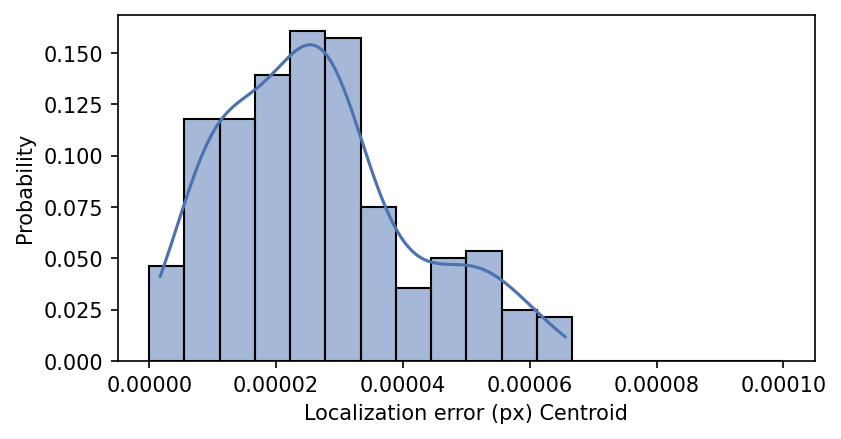

In [17]:


# Set up the figure with a larger size and higher resolution
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")

# Create the histogram with KDE
sns.histplot(metrics_c["dist.dists"].flatten(), 
             binrange=(0, 0.0001), 
             kde=True, 
             kde_kws={"clip": (0, 0.0001)}, 
             stat="probability")

# Add labels
plt.xlabel("Localization error (px) Centroid")
plt.ylabel("Probability")

# Display the plot inline
plt.show()

#### 4.3.1.4. PCK (meaningless for centroid I think)

PCK (Percentage of Correct Keypoints) Metrics:

    pck.thresholds:
        What it is: List of distance thresholds used for calculating PCK scores.
        How it's calculated: These thresholds define the maximum acceptable distance (in pixels or as a fraction of object size) between predicted and ground truth keypoints for a prediction to be considered correct.

    pck.pcks:
        What it is: PCK scores for each keypoint at each threshold.
        How it's calculated: The fraction of correctly predicted keypoints that fall within the specified thresholds, calculated per keypoint and averaged across all frames.

    pck.mPCK_parts:
        What it is: Mean PCK score per keypoint across all frames.
        How it's calculated: The average PCK for each keypoint across all thresholds, giving a measure of how well each keypoint is predicted on average.

    pck.mPCK:
        What it is: Overall mean PCK score for all keypoints and thresholds.
        How it's calculated: The average of pck.mPCK_parts across all keypoints, providing a summary metric of the model’s overall performance.

PCK-VOC Metrics:

    pck_voc.match_score_thresholds:
        What it is: Thresholds for match scores between predicted and ground truth keypoints.
        How it's calculated: These thresholds define the maximum acceptable distance between predicted and true keypoints for a match to be considered correct, typically based on the PCK method.

    pck_voc.recall_thresholds:
        What it is: Thresholds for recall values at different levels.
        How it's calculated: Predefined thresholds (e.g., evenly spaced from 0 to 1) used to compute recall values at different detection levels.

    pck_voc.match_scores:
        What it is: Scores representing the match quality between predicted and ground truth keypoints.
        How it's calculated: These scores are calculated based on how close the predicted keypoints are to the ground truth, typically using a normalized distance measure (like PCK).

    pck_voc.precisions:
        What it is: Precision values calculated at different recall thresholds.
        How it's calculated: Precision is the fraction of correctly predicted keypoints (true positives) out of all predicted keypoints (true positives + false positives), computed at each recall level.

    pck_voc.recalls:
        What it is: Recall values calculated across different recall thresholds.
        How it's calculated: Recall is the fraction of correctly predicted keypoints out of all ground truth keypoints (true positives + false negatives), calculated at each recall threshold.

    pck_voc.AP (Average Precision):
        What it is: The average precision score for each keypoint or class.
        How it's calculated: The area under the Precision-Recall curve for a single keypoint or class, computed by averaging precision values across all recall thresholds.

    pck_voc.AR (Average Recall):
        What it is: The average recall score for each keypoint or class.
        How it's calculated: The area under the Recall curve, summarizing recall performance across different thresholds for a specific keypoint or class.

    pck_voc.mAP (Mean Average Precision):
        What it is: The mean of all Average Precision (AP) values across all keypoints or classes.
        How it's calculated: The average of AP values across all keypoints or instances, providing an overall measure of the model’s precision across different thresholds.

    pck_voc.mAR (Mean Average Recall):
        What it is: The mean of all Average Recall (AR) values across all keypoints or classes.
        How it's calculated: The average of AR values across all keypoints or instances, giving an overall measure of recall performance.

In [44]:
print('PCK Metrics:')
print("PCK thresholds:", metrics["pck.thresholds"])
print("PCK scores for each keypoint:", metrics_c["pck.pcks"])
print("Mean PCK per keypoint (mPCK_parts):", metrics_c["pck.mPCK_parts"])
print("Overall mean PCK (mPCK):", metrics["pck.mPCK"])


PCK Metrics:
PCK thresholds: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
PCK scores for each keypoint: [[[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 ...

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  T

In [45]:
print('PCK-VOC Metrics:')
print("Match score thresholds:", metrics["pck_voc.match_score_thresholds"])
print("Recall thresholds:", metrics["pck_voc.recall_thresholds"])
print("Match scores:", metrics_c["pck_voc.match_scores"])
print("Precisions at different recall levels:", metrics_c["pck_voc.precisions"])
print("Recalls at different recall levels:", metrics_c["pck_voc.recalls"])
print("Average Precision (AP):", metrics_c["pck_voc.AP"])
print("Average Recall (AR):", metrics_c["pck_voc.AR"])
print("Mean Average Precision (mAP):", metrics_c["pck_voc.mAP"])
print("Mean Average Recall (mAR):", metrics_c["pck_voc.mAR"])


PCK-VOC Metrics:
Match score thresholds: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Recall thresholds: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
Match scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Precisions at different recall levels: [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
Recalls at different recall levels: [0.58333333 0.5833333

In [29]:
print((metrics_c["pck_voc.match_scores"]))
len(metrics_c["pck_voc.match_scores"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


35

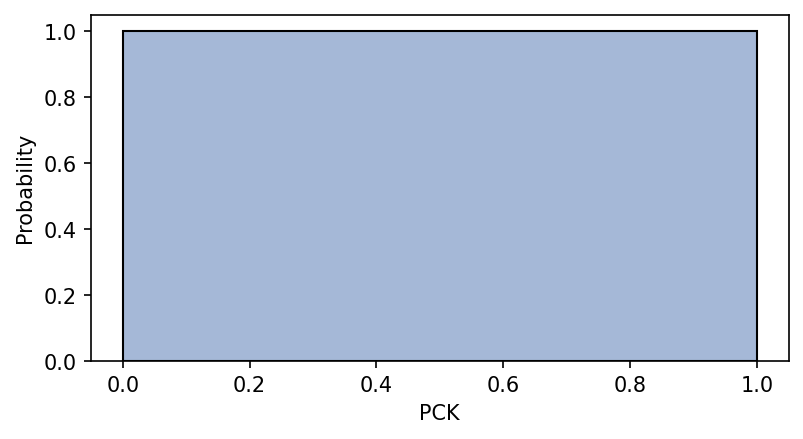

In [26]:
# metrics_c = {
#     "pck_voc.match_scores": np.random.normal(loc=5, scale=2, size=100)  # Sample data with mean 5 and std deviation 2
# }

# Set up the figure with a larger size and higher resolution
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")

# Create the histogram with KDE
sns.histplot(metrics_c["pck_voc.match_scores"].flatten(), 
             binrange=(0, 1), 
             kde=True, 
             kde_kws={"clip": (0, 1)}, 
             stat="probability")

# Add labels
plt.xlabel("PCK")
plt.ylabel("Probability")

# Display the plot inline
plt.show()

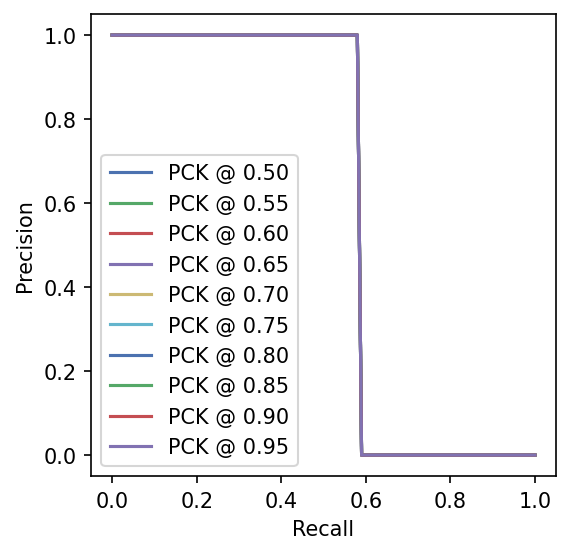

In [37]:
# Set up the figure
plt.figure(figsize=(4, 4), dpi=150, facecolor="w")

# Plot the precision-recall curves for every second threshold and precision
for precision, thresh in zip(metrics_c["pck_voc.precisions"], metrics_c["pck_voc.match_score_thresholds"]):
    plt.plot(metrics_c["pck_voc.recall_thresholds"], precision, "-", label=f"PCK @ {thresh:.2f}")

# Add labels and a legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")

# Display the plot inline
plt.show()

#### 4.3.1.5. OKS 

OKS (Object Keypoint Similarity) Metrics:

    oks.mOKS:
        What it is: Mean Object Keypoint Similarity across all keypoints.
        How it's calculated: A similarity score between predicted and ground truth keypoints, normalized by object size and considering keypoint visibility. It averages the OKS scores across all keypoints.

OKS-VOC Metrics (Adapted from Object Detection Evaluation):

    oks_voc.match_score_thresholds:
        What it is: Thresholds for match scores between predicted and ground truth keypoints.
        How it's calculated: Defined thresholds (e.g., 0.5, 0.75) used to determine whether a keypoint match is considered correct.

    oks_voc.recall_thresholds:
        What it is: Thresholds for recall values.
        How it's calculated: Specific recall thresholds (often fixed intervals) used to evaluate recall at different levels of detection.

    oks_voc.match_scores:
        What it is: Scores representing the quality of matches between predicted and ground truth keypoints.
        How it's calculated: Based on OKS, a score is assigned to each match, determining the closeness of the match between predicted and true keypoints.

    oks_voc.precisions:
        What it is: Precision values at various recall thresholds.
        How it's calculated: The fraction of true positive keypoints (correct matches) out of all predicted keypoints (true positives + false positives), calculated at various recall levels.

    oks_voc.recalls:
        What it is: Recall values across different recall thresholds.
        How it's calculated: The fraction of true positive keypoints out of all ground truth keypoints (true positives + false negatives), calculated at different recall thresholds.

    oks_voc.AP (Average Precision):
        What it is: The precision averaged across different recall levels for a specific class or keypoint.
        How it's calculated: Area under the Precision-Recall curve, summarizing the model's precision performance at different recall levels.

    oks_voc.AR (Average Recall):
        What it is: The recall averaged across different recall thresholds for a specific class or keypoint.
        How it's calculated: Area under the Recall curve, providing an average measure of recall over varying detection thresholds.

    oks_voc.mAP (Mean Average Precision):
        What it is: The mean of Average Precision (AP) values across all keypoints or classes.
        How it's calculated: The mean AP score calculated by averaging the AP values for all classes/keypoints.

    oks_voc.mAR (Mean Average Recall):
        What it is: The mean of Average Recall (AR) values across all keypoints or classes.
        How it's calculated: The mean AR score calculated by averaging the AR values across all classes/keypoints.

In [47]:
print('OKS Metrics:')
print("Mean OKS (mOKS):", metrics_c["oks.mOKS"])


OKS Metrics:
Mean OKS (mOKS): 0.9999999999992238


In [20]:
print('OKS-VOC Metrics:')
print("Match score thresholds:", metrics_c["oks_voc.match_score_thresholds"])
print("Recall thresholds:", metrics_c["oks_voc.recall_thresholds"])
print("Match scores:", metrics_c["oks_voc.match_scores"])
print("Precisions at different recall levels:", metrics_c["oks_voc.precisions"])
print("Recalls at different recall levels:", metrics_c["oks_voc.recalls"])
print("Average Precision (AP):", metrics_c["oks_voc.AP"])
print("Average Recall (AR):", metrics_c["oks_voc.AR"])
print("Mean Average Precision (mAP):", metrics_c["oks_voc.mAP"])
print("Mean Average Recall (mAR):", metrics_c["oks_voc.mAR"])

OKS-VOC Metrics:
Match score thresholds: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Recall thresholds: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
Match scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Precisions at different recall levels: [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
Recalls at different recall levels: [0.58333333 0.5833333

In [33]:
print(metrics_c["pck_voc.match_scores"])
len(metrics_c["pck_voc.match_scores"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


35

In [30]:
print(metrics_c["oks_voc.match_scores"])
len(metrics_c["oks_voc.match_scores"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


35

In [34]:
oks = metrics_c["oks_voc.match_scores"]

MemoryError: Unable to allocate 27.7 TiB for an array with shape (3811631691684,) and data type float64

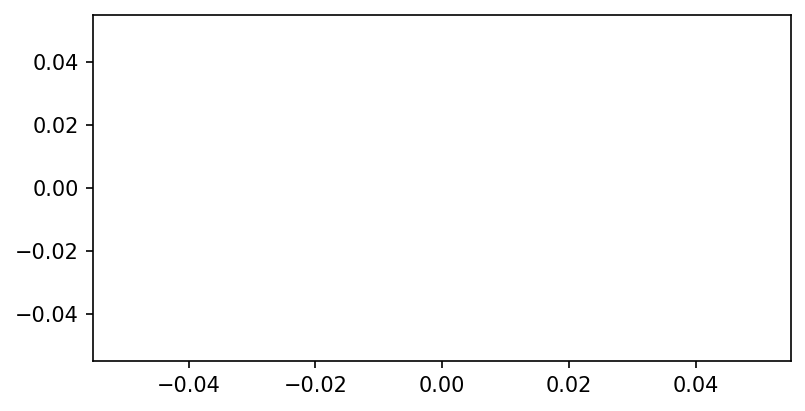

In [35]:
# metrics_c = {
#     "pck_voc.match_scores": np.random.normal(loc=5, scale=2, size=100)  # Sample data with mean 5 and std deviation 2
# }

# Set up the figure with a larger size and higher resolution
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")

# Create the histogram with KDE
sns.histplot(metrics_c["oks_voc.match_scores"].flatten(), 
             binrange=(0, 1), 
             kde=True, 
             kde_kws={"clip": (0, 1)}, 
             stat="probability")

# Add labels
plt.xlabel("OKS")
plt.ylabel("Probability")

# Display the plot inline
plt.show()

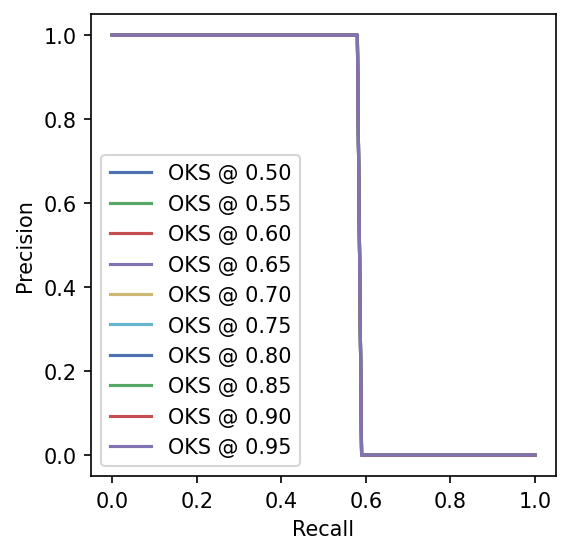

In [36]:

# Set up the figure
plt.figure(figsize=(4, 4), dpi=150, facecolor="w")

# Plot the precision-recall curves for every second threshold and precision
for precision, thresh in zip(metrics_c["oks_voc.precisions"], metrics_c["oks_voc.match_score_thresholds"]):
    plt.plot(metrics_c["oks_voc.recall_thresholds"], precision, "-", label=f"OKS @ {thresh:.2f}")

# Add labels and a legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")

# Display the plot inline
plt.show()


### 4.3.2. Top-down

In [39]:
model_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test3_medium_rf.topdown_200Epoch'


#### 4.3.2.0. Inspect the datasets

In [42]:
# inspect the ground truth val dataset
!sleap-inspect {model_path}/labels_gt.val.slp

Labeled frames: 60
Tracks: 6
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/flap1/img010.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest8/img007.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/walk6/img017.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 10
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest15/img027.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled 

In [43]:
# inspect the predicted val dataset
!sleap-inspect {model_path}/labels_pr.val.slp

Labeled frames: 60
Tracks: 0
Video files:
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest15/img027.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/stand2/img000.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/walk6/img017.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled frames: 0
    tracks: 1
    max instances in frame: 1
  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/preen30/img011.png
    labeled frames: 10
    labeled frames from 0 to 9
    user labeled 

NOTE: Comparing the datasets, max instances is the same. This is good.

In [45]:
labels_val_gt_td = sleap.load_file(f'{model_path}/labels_gt.val.slp')

In [ ]:
# labels_val_gt_c.export_csv('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct3_test1_centroid_200Epoch/labels_gt.val.csv')

In [48]:
labels_val_gt_td_dict = labels_val_gt_td.to_dict()

In [49]:
# Save the dictionary to a JSON file with pretty formatting
with open(f"{model_path}/labels_gt.val.json", "w") as json_file:
    json.dump(labels_val_gt_td_dict, json_file, indent=4)

In [50]:
labels_val_gt_td.describe()

Skeleton: Skeleton(description=None, nodes=[Head, Beak, Body_top, RFlipper_mid, LFlipper_mid, Body_bottom, RFoot, LFoot], edges=[], symmetries=[])
Videos: ['/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/flap1/img010.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest8/img007.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/walk6/img017.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest15/img027.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/stand2/img000.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/preen30/img011.png']
Frames (user/predicted): 60/0
Instances (user/predicted): 60/0
Tracks: [

In [54]:
labels_val_pr_td = sleap.load_file(f'{model_path}/labels_pr.val.slp')

In [55]:
labels_val_pr_td.describe()

Skeleton: Skeleton(description=None, nodes=[Head, Beak, Body_top, RFlipper_mid, LFlipper_mid, Body_bottom, RFoot, LFoot], edges=[], symmetries=[])
Videos: ['/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest15/img027.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/stand2/img000.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/walk6/img017.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/preen30/img011.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/rest8/img007.png', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/DLC_data/val/labeled-data/flap1/img010.png']
Frames (user/predicted): 0/55
Instances (user/predicted): 0/55
Tracks: [

In [56]:
labels_val_pr_td_dict = labels_val_pr_td.to_dict()

In [57]:
# Save the dictionary to a JSON file with pretty formatting
with open(f"{model_path}/labels_pr.val.json", "w") as json_file:
    json.dump(labels_val_pr_td_dict, json_file, indent=4)

NOTE: so only 55 frames were found to have instances in them. what do these frames look like?

This is strange that this model picks up the instances better and the other one appears to pick up the keypoints better?

#### 4.3.2.1. Looking at the available metrics

In [59]:
print('\n TOP DOWN')
metrics = sleap.load_metrics(model_path, split="val")
print("\n".join(metrics.keys()))


 TOP DOWN
vis.tp
vis.fp
vis.tn
vis.fn
vis.precision
vis.recall
dist.frame_idxs
dist.video_paths
dist.dists
dist.avg
dist.p50
dist.p75
dist.p90
dist.p95
dist.p99
pck.thresholds
pck.pcks
pck.mPCK_parts
pck.mPCK
oks.mOKS
oks_voc.match_score_thresholds
oks_voc.recall_thresholds
oks_voc.match_scores
oks_voc.precisions
oks_voc.recalls
oks_voc.AP
oks_voc.AR
oks_voc.mAP
oks_voc.mAR
pck_voc.match_score_thresholds
pck_voc.recall_thresholds
pck_voc.match_scores
pck_voc.precisions
pck_voc.recalls
pck_voc.AP
pck_voc.AR
pck_voc.mAP
pck_voc.mAR


#### 4.3.2.2. Visibility

Explanation (Visibility):

    True Positives (TP): Cases where the model correctly predicted that a keypoint is visible.
    False Positives (FP): Cases where the model predicted a keypoint is visible when it is not (false alarm).
    True Negatives (TN): Cases where the model correctly predicted that a keypoint is not visible (occluded).
    False Negatives (FN): Cases where the model predicted a keypoint is not visible when it actually is (missed detection).
    Precision: The proportion of correctly predicted visible keypoints (TP) out of all predicted visible keypoints (TP + FP).
    Recall: The proportion of actual visible keypoints that were correctly predicted (TP) out of all actual visible keypoints (TP + FN).

In [82]:
# Display visibility-related metrics
print('\nVisibility Metrics:')
print("True Positives (TP):", metrics["vis.tp"])
print("False Positives (FP):", metrics["vis.fp"])
print("True Negatives (TN):", metrics["vis.tn"])
print("False Negatives (FN):", metrics["vis.fn"])
print("Precision:", metrics["vis.precision"])
print("Recall:", metrics["vis.recall"])


Visibility Metrics:
True Positives (TP): 193
False Positives (FP): 6
True Negatives (TN): 37
False Negatives (FN): 180
Precision: 0.9698492462311558
Recall: 0.517426273458445


NOTE: We are missing almost half the keypoints. That is not a good sign

#### 4.3.2.3. Error distance (means very little for the centroid) - however it is interesting to see that this algorithm seems to work better than the top-down one

dist.frame_idxs:

    What it is: Indices of the frames in the dataset where the distances are calculated.
    How it's calculated: The indices correspond to the frame positions in the video(s) being evaluated.

dist.video_paths:

    What it is: Paths to the video files associated with the frames being evaluated.
    How it's calculated: These are the file paths where the videos used for evaluation are stored.

dist.dists:

    What it is: The raw distances (in pixels) between predicted and ground truth keypoints for each frame.
    How it's calculated: Euclidean distance is computed for each keypoint across the dataset between the predicted and ground truth positions.

dist.avg:

    What it is: The average distance error across all frames and keypoints.
    How it's calculated: The mean of the dist.dists values across all keypoints and frames.

dist.p50:

    What it is: The 50th percentile (median) of the distance errors.
    How it's calculated: The median value of the dist.dists array, meaning 50% of the distances are below this value.

dist.p75:

    What it is: The 75th percentile of the distance errors.
    How it's calculated: The value below which 75% of the dist.dists lie.

dist.p90:

    What it is: The 90th percentile of the distance errors.
    How it's calculated: The value below which 90% of the dist.dists lie.

dist.p95:

    What it is: The 95th percentile of the distance errors.
    How it's calculated: The value below which 95% of the dist.dists lie.

dist.p99:

    What it is: The 99th percentile of the distance errors.
    How it's calculated: The value below which 99% of the dist.dists lie, representing the most extreme errors.

In [81]:
len(metrics["dist.dists"])

52

In [80]:
#summary of the localization errors:
print('Centroid Distance Metrics:')
#print("Frame indices:", metrics["dist.frame_idxs"])
#print("Video paths:", metrics["dist.video_paths"])
#print("Error distances (all):", metrics["dist.dists"])
print("Error distance (avg):", metrics["dist.avg"])
print("Error distance (50%):", metrics["dist.p50"])
print("Error distance (75%):", metrics["dist.p75"])
print("Error distance (90%):", metrics["dist.p90"])
print("Error distance (95%):", metrics["dist.p95"])
print("Error distance (99%):", metrics["dist.p99"])


Centroid Distance Metrics:
Error distance (avg): 46.714012124678426
Error distance (50%): 10.731174132897111
Error distance (75%): 19.35681355090176
Error distance (90%): 78.87723090070979
Error distance (95%): 239.23818025309083
Error distance (99%): 730.6019764445392


In [79]:
print(metrics["dist.dists"])

[[  5.51291579   5.60229747          nan          nan  60.92507416
           nan   8.94494085  15.82000651]
 [  5.93215665   3.92994917          nan          nan  57.16833175
           nan   7.44946336  12.75785832]
 [  0.88970497   1.90066834          nan          nan          nan
           nan   9.90217722   9.96775327]
 [  4.74290963   1.43703327  15.63868762          nan 187.09151367
           nan   7.55550888  13.84795877]
 [  2.84520469          nan   9.88576029          nan          nan
           nan   5.52011798   7.69470222]
 [  5.08081551          nan  11.02829735          nan 285.77145723
           nan   7.48020211  11.0150161 ]
 [  3.12024395          nan  14.91294069          nan          nan
           nan   7.60795166   4.91144186]
 [         nan          nan   1.61750235          nan          nan
           nan   2.70514858   7.52369934]
 [ 12.28007379   4.68654401   8.77304754          nan          nan
   22.07868901   7.06535497   7.02006636]
 [  3.77468841     

In [ ]:
flatten_dist = metrics["dist.dists"].flatten()

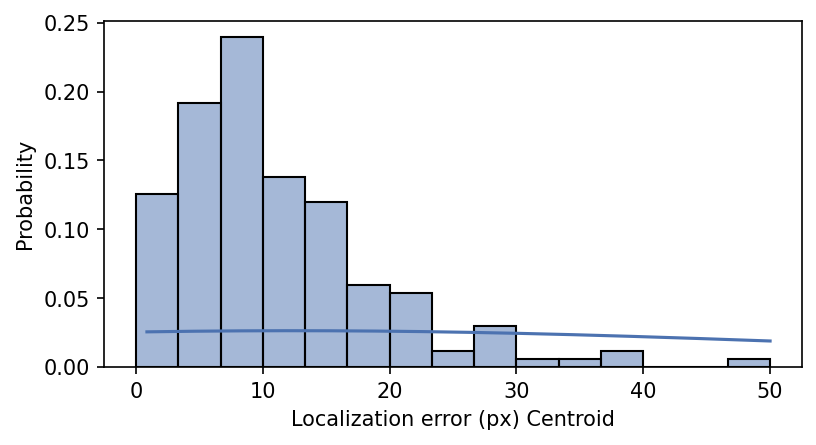

In [78]:


# Set up the figure with a larger size and higher resolution
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")

# Create the histogram with KDE
sns.histplot(metrics["dist.dists"].flatten(), 
             binrange=(0, 50), 
             kde=True, 
             kde_kws={"clip": (0, 50)}, 
             stat="probability")

# Add labels
plt.xlabel("Localization error (px) Centroid")
plt.ylabel("Probability")

# Display the plot inline
plt.show()

#### 4.3.1.4. PCK (meaningless for centroid I think)

PCK (Percentage of Correct Keypoints) Metrics:

    pck.thresholds:
        What it is: List of distance thresholds used for calculating PCK scores.
        How it's calculated: These thresholds define the maximum acceptable distance (in pixels or as a fraction of object size) between predicted and ground truth keypoints for a prediction to be considered correct.

    pck.pcks:
        What it is: PCK scores for each keypoint at each threshold.
        How it's calculated: The fraction of correctly predicted keypoints that fall within the specified thresholds, calculated per keypoint and averaged across all frames.

    pck.mPCK_parts:
        What it is: Mean PCK score per keypoint across all frames.
        How it's calculated: The average PCK for each keypoint across all thresholds, giving a measure of how well each keypoint is predicted on average.

    pck.mPCK:
        What it is: Overall mean PCK score for all keypoints and thresholds.
        How it's calculated: The average of pck.mPCK_parts across all keypoints, providing a summary metric of the model’s overall performance.

PCK-VOC Metrics:

    pck_voc.match_score_thresholds:
        What it is: Thresholds for match scores between predicted and ground truth keypoints.
        How it's calculated: These thresholds define the maximum acceptable distance between predicted and true keypoints for a match to be considered correct, typically based on the PCK method.

    pck_voc.recall_thresholds:
        What it is: Thresholds for recall values at different levels.
        How it's calculated: Predefined thresholds (e.g., evenly spaced from 0 to 1) used to compute recall values at different detection levels.

    pck_voc.match_scores:
        What it is: Scores representing the match quality between predicted and ground truth keypoints.
        How it's calculated: These scores are calculated based on how close the predicted keypoints are to the ground truth, typically using a normalized distance measure (like PCK).

    pck_voc.precisions:
        What it is: Precision values calculated at different recall thresholds.
        How it's calculated: Precision is the fraction of correctly predicted keypoints (true positives) out of all predicted keypoints (true positives + false positives), computed at each recall level.

    pck_voc.recalls:
        What it is: Recall values calculated across different recall thresholds.
        How it's calculated: Recall is the fraction of correctly predicted keypoints out of all ground truth keypoints (true positives + false negatives), calculated at each recall threshold.

    pck_voc.AP (Average Precision):
        What it is: The average precision score for each keypoint or class.
        How it's calculated: The area under the Precision-Recall curve for a single keypoint or class, computed by averaging precision values across all recall thresholds.

    pck_voc.AR (Average Recall):
        What it is: The average recall score for each keypoint or class.
        How it's calculated: The area under the Recall curve, summarizing recall performance across different thresholds for a specific keypoint or class.

    pck_voc.mAP (Mean Average Precision):
        What it is: The mean of all Average Precision (AP) values across all keypoints or classes.
        How it's calculated: The average of AP values across all keypoints or instances, providing an overall measure of the model’s precision across different thresholds.

    pck_voc.mAR (Mean Average Recall):
        What it is: The mean of all Average Recall (AR) values across all keypoints or classes.
        How it's calculated: The average of AR values across all keypoints or instances, giving an overall measure of recall performance.

In [75]:
print('PCK Metrics:')
print("PCK thresholds:", metrics["pck.thresholds"])
print("PCK scores for each keypoint:", metrics["pck.pcks"])
print("Mean PCK per keypoint (mPCK_parts):", metrics["pck.mPCK_parts"])
print("Overall mean PCK (mPCK):", metrics["pck.mPCK"])


PCK Metrics:
PCK thresholds: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
PCK scores for each keypoint: [[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False  True  True]
  [False False False ... False False False]]

 [[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ...  True  True  True]
  [False False False ... False False False]]

 [[ True  True  True ...  True  True  True]
  [False  True  True ...  True  True  True]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False  True]
  [False False False ... False False  True]]

 ...

 [[False False False ... False False False]
  [False False False ... False Fa

In [74]:
print('PCK-VOC Metrics:')
print("Match score thresholds:", metrics["pck_voc.match_score_thresholds"])
print("Recall thresholds:", metrics["pck_voc.recall_thresholds"])
print("Match scores:", metrics["pck_voc.match_scores"])
print("Precisions at different recall levels:", metrics["pck_voc.precisions"])
print("Recalls at different recall levels:", metrics["pck_voc.recalls"])
print("Average Precision (AP):", metrics["pck_voc.AP"])
print("Average Recall (AR):", metrics["pck_voc.AR"])
print("Mean Average Precision (mAP):", metrics["pck_voc.mAP"])
print("Mean Average Recall (mAR):", metrics["pck_voc.mAR"])


PCK-VOC Metrics:
Match score thresholds: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Recall thresholds: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
Match scores: [0.15   0.1875 0.2625 0.225  0.2125 0.1    0.2    0.25   0.175  0.1875
 0.     0.     0.05   0.0875 0.0625 0.     0.025  0.1    0.0625 0.0125
 0.05   0.1    0.1125 0.075  0.0875 0.1    0.15   0.1125 0.05   0.0625
 0.1    0.075  0.2    0.1125 0.1    0.0625 0.05   0.05   0.075  0.0375
 0.     0.     0.225  0.1875 0.0875 0.1875 0.0375 0.1875 0.0375 0.1375
 0.08

In [73]:
print((metrics["pck_voc.match_scores"]))
len(metrics["pck_voc.match_scores"])

[0.15   0.1875 0.2625 0.225  0.2125 0.1    0.2    0.25   0.175  0.1875
 0.     0.     0.05   0.0875 0.0625 0.     0.025  0.1    0.0625 0.0125
 0.05   0.1    0.1125 0.075  0.0875 0.1    0.15   0.1125 0.05   0.0625
 0.1    0.075  0.2    0.1125 0.1    0.0625 0.05   0.05   0.075  0.0375
 0.     0.     0.225  0.1875 0.0875 0.1875 0.0375 0.1875 0.0375 0.1375
 0.0875 0.2   ]


52

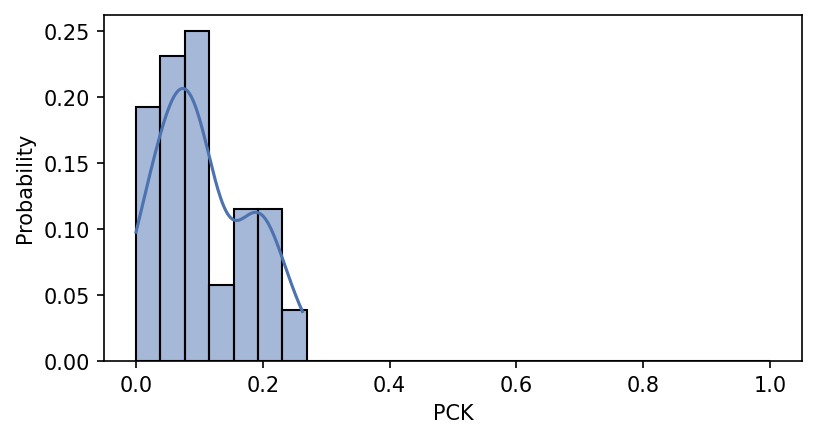

In [72]:
# metrics = {
#     "pck_voc.match_scores": np.random.normal(loc=5, scale=2, size=100)  # Sample data with mean 5 and std deviation 2
# }

# Set up the figure with a larger size and higher resolution
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")

# Create the histogram with KDE
sns.histplot(metrics["pck_voc.match_scores"].flatten(), 
             binrange=(0, 1), 
             kde=True, 
             kde_kws={"clip": (0, 1)}, 
             stat="probability")

# Add labels
plt.xlabel("PCK")
plt.ylabel("Probability")

# Display the plot inline
plt.show()

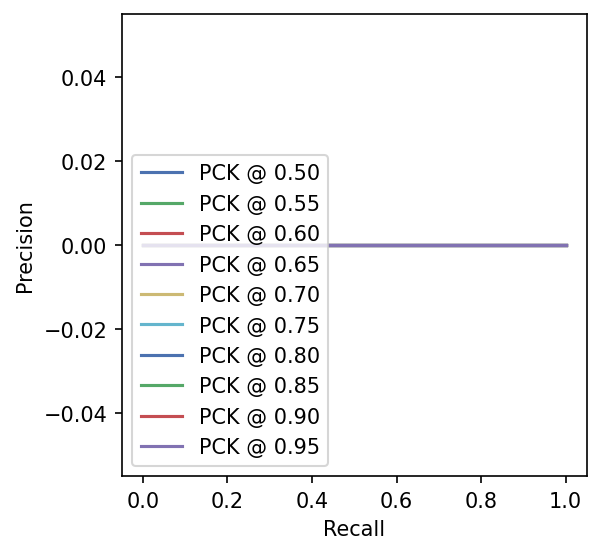

In [71]:
# Set up the figure
plt.figure(figsize=(4, 4), dpi=150, facecolor="w")

# Plot the precision-recall curves for every second threshold and precision
for precision, thresh in zip(metrics["pck_voc.precisions"], metrics["pck_voc.match_score_thresholds"]):
    plt.plot(metrics["pck_voc.recall_thresholds"], precision, "-", label=f"PCK @ {thresh:.2f}")

# Add labels and a legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")

# Display the plot inline
plt.show()

#### 4.3.2.5. OKS 

OKS (Object Keypoint Similarity) Metrics:

    oks.mOKS:
        What it is: Mean Object Keypoint Similarity across all keypoints.
        How it's calculated: A similarity score between predicted and ground truth keypoints, normalized by object size and considering keypoint visibility. It averages the OKS scores across all keypoints.

OKS-VOC Metrics (Adapted from Object Detection Evaluation):

    oks_voc.match_score_thresholds:
        What it is: Thresholds for match scores between predicted and ground truth keypoints.
        How it's calculated: Defined thresholds (e.g., 0.5, 0.75) used to determine whether a keypoint match is considered correct.

    oks_voc.recall_thresholds:
        What it is: Thresholds for recall values.
        How it's calculated: Specific recall thresholds (often fixed intervals) used to evaluate recall at different levels of detection.

    oks_voc.match_scores:
        What it is: Scores representing the quality of matches between predicted and ground truth keypoints.
        How it's calculated: Based on OKS, a score is assigned to each match, determining the closeness of the match between predicted and true keypoints.

    oks_voc.precisions:
        What it is: Precision values at various recall thresholds.
        How it's calculated: The fraction of true positive keypoints (correct matches) out of all predicted keypoints (true positives + false positives), calculated at various recall levels.

    oks_voc.recalls:
        What it is: Recall values across different recall thresholds.
        How it's calculated: The fraction of true positive keypoints out of all ground truth keypoints (true positives + false negatives), calculated at different recall thresholds.

    oks_voc.AP (Average Precision):
        What it is: The precision averaged across different recall levels for a specific class or keypoint.
        How it's calculated: Area under the Precision-Recall curve, summarizing the model's precision performance at different recall levels.

    oks_voc.AR (Average Recall):
        What it is: The recall averaged across different recall thresholds for a specific class or keypoint.
        How it's calculated: Area under the Recall curve, providing an average measure of recall over varying detection thresholds.

    oks_voc.mAP (Mean Average Precision):
        What it is: The mean of Average Precision (AP) values across all keypoints or classes.
        How it's calculated: The mean AP score calculated by averaging the AP values for all classes/keypoints.

    oks_voc.mAR (Mean Average Recall):
        What it is: The mean of Average Recall (AR) values across all keypoints or classes.
        How it's calculated: The mean AR score calculated by averaging the AR values across all classes/keypoints.

In [70]:
print('OKS Metrics:')
print("Mean OKS (mOKS):", metrics["oks.mOKS"])


OKS Metrics:
Mean OKS (mOKS): 0.37586655730354923


In [69]:
print('OKS-VOC Metrics:')
print("Match score thresholds:", metrics["oks_voc.match_score_thresholds"])
print("Recall thresholds:", metrics["oks_voc.recall_thresholds"])
print("Match scores:", metrics["oks_voc.match_scores"])
print("Precisions at different recall levels:", metrics["oks_voc.precisions"])
print("Recalls at different recall levels:", metrics["oks_voc.recalls"])
print("Average Precision (AP):", metrics["oks_voc.AP"])
print("Average Recall (AR):", metrics["oks_voc.AR"])
print("Mean Average Precision (mAP):", metrics["oks_voc.mAP"])
print("Mean Average Recall (mAR):", metrics["oks_voc.mAR"])

OKS-VOC Metrics:
Match score thresholds: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Recall thresholds: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
Match scores: [4.55174193e-01 4.71719695e-01 4.80171559e-01 5.29411016e-01
 4.80217780e-01 4.55881854e-01 4.54141291e-01 4.14736645e-01
 6.85215458e-01 4.73548918e-01 6.01098529e-04 1.92195408e-11
 3.05675245e-01 3.30263884e-01 3.94256020e-01 2.93725541e-01
 3.63497339e-01 1.76547285e-01 1.93180258e-01 1.28162998e-01
 2.21176506e-01 1.23669861e-01 3.88416810e-01 3.8442637

In [ ]:
print(metrics["pck_voc.match_scores"])
len(metrics["pck_voc.match_scores"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


35

In [68]:
print(metrics["oks_voc.match_scores"])
len(metrics["oks_voc.match_scores"])

[4.55174193e-01 4.71719695e-01 4.80171559e-01 5.29411016e-01
 4.80217780e-01 4.55881854e-01 4.54141291e-01 4.14736645e-01
 6.85215458e-01 4.73548918e-01 6.01098529e-04 1.92195408e-11
 3.05675245e-01 3.30263884e-01 3.94256020e-01 2.93725541e-01
 3.63497339e-01 1.76547285e-01 1.93180258e-01 1.28162998e-01
 2.21176506e-01 1.23669861e-01 3.88416810e-01 3.84426376e-01
 3.79124227e-01 3.88144006e-01 3.92992802e-01 3.79049858e-01
 3.73208785e-01 3.63207675e-01 1.99345504e-01 1.97300907e-01
 3.64891985e-01 2.45031694e-01 2.42820580e-01 2.39715801e-01
 2.39054552e-01 2.35466854e-01 1.23778026e-01 1.21199140e-01
 1.00281449e-01 8.43892395e-02 6.89811996e-01 6.98692601e-01
 6.77838445e-01 6.99181474e-01 4.96972809e-01 6.29646135e-01
 6.17401724e-01 6.53454511e-01 7.37559846e-01 7.71680722e-01]


52

In [67]:
oks = metrics_c["oks_voc.match_scores"]

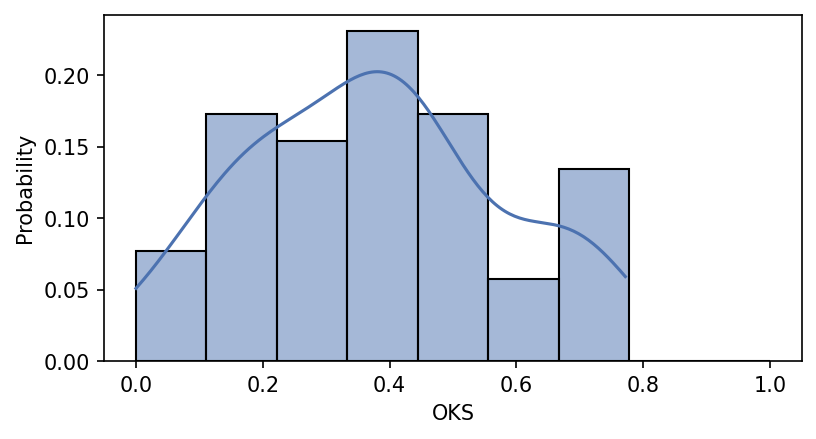

In [66]:
# metrics_c = {
#     "pck_voc.match_scores": np.random.normal(loc=5, scale=2, size=100)  # Sample data with mean 5 and std deviation 2
# }

# Set up the figure with a larger size and higher resolution
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")

# Create the histogram with KDE
sns.histplot(metrics["oks_voc.match_scores"].flatten(), 
             binrange=(0, 1), 
             kde=True, 
             kde_kws={"clip": (0, 1)}, 
             stat="probability")

# Add labels
plt.xlabel("OKS")
plt.ylabel("Probability")

# Display the plot inline
plt.show()

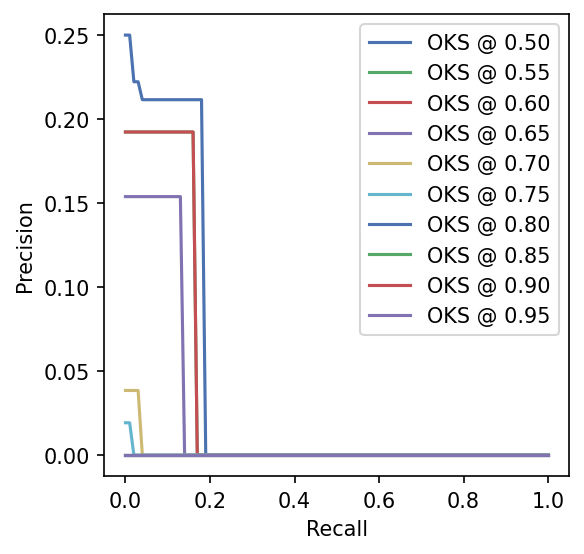

In [65]:

# Set up the figure
plt.figure(figsize=(4, 4), dpi=150, facecolor="w")

# Plot the precision-recall curves for every second threshold and precision
for precision, thresh in zip(metrics["oks_voc.precisions"], metrics["oks_voc.match_score_thresholds"]):
    plt.plot(metrics["oks_voc.recall_thresholds"], precision, "-", label=f"OKS @ {thresh:.2f}")

# Add labels and a legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")

# Display the plot inline
plt.show()


## 4.4. Inference

### 4.4.1. using CLI

see: 
usage: sleap-track [-h] [-m MODELS] [--frames FRAMES] [--only-labeled-frames] [--only-suggested-frames] [-o OUTPUT] [--no-empty-frames]
                   [--verbosity {none,rich,json}] [--video.dataset VIDEO.DATASET] [--video.input_format VIDEO.INPUT_FORMAT]
                   [--video.index VIDEO.INDEX] [--cpu | --first-gpu | --last-gpu | --gpu GPU] [--max_edge_length_ratio MAX_EDGE_LENGTH_RATIO]
                   [--dist_penalty_weight DIST_PENALTY_WEIGHT] [--batch_size BATCH_SIZE] [--open-in-gui] [--peak_threshold PEAK_THRESHOLD]
                   [-n MAX_INSTANCES] [--tracking.tracker TRACKING.TRACKER] [--tracking.max_tracking TRACKING.MAX_TRACKING]
                   [--tracking.max_tracks TRACKING.MAX_TRACKS] [--tracking.target_instance_count TRACKING.TARGET_INSTANCE_COUNT]
                   [--tracking.pre_cull_to_target TRACKING.PRE_CULL_TO_TARGET] [--tracking.pre_cull_iou_threshold TRACKING.PRE_CULL_IOU_THRESHOLD]
                   [--tracking.post_connect_single_breaks TRACKING.POST_CONNECT_SINGLE_BREAKS]
                   [--tracking.clean_instance_count TRACKING.CLEAN_INSTANCE_COUNT] [--tracking.clean_iou_threshold TRACKING.CLEAN_IOU_THRESHOLD]
                   [--tracking.similarity TRACKING.SIMILARITY] [--tracking.match TRACKING.MATCH] [--tracking.robust TRACKING.ROBUST]
                   [--tracking.track_window TRACKING.TRACK_WINDOW] [--tracking.min_new_track_points TRACKING.MIN_NEW_TRACK_POINTS]
                   [--tracking.min_match_points TRACKING.MIN_MATCH_POINTS] [--tracking.img_scale TRACKING.IMG_SCALE]
                   [--tracking.of_window_size TRACKING.OF_WINDOW_SIZE] [--tracking.of_max_levels TRACKING.OF_MAX_LEVELS]
                   [--tracking.save_shifted_instances TRACKING.SAVE_SHIFTED_INSTANCES] [--tracking.kf_node_indices TRACKING.KF_NODE_INDICES]
                   [--tracking.kf_init_frame_count TRACKING.KF_INIT_FRAME_COUNT]
                   [data_path]

positional arguments:
  data_path             Path to data to predict on. This can be a labels (.slp) file or any supported video format.

optional arguments:
  -h, --help            show this help message and exit
  -m MODELS, --model MODELS
                        Path to trained model directory (with training_config.json). Multiple models can be specified, each preceded by --model.
  --frames FRAMES       List of frames to predict when running on a video. Can be specified as a comma separated list (e.g. 1,2,3) or a range
                        separated by hyphen (e.g., 1-3, for 1,2,3). If not provided, defaults to predicting on the entire video.
  --only-labeled-frames
                        Only run inference on user labeled frames when running on labels dataset. This is useful for generating predictions to compare
                        against ground truth.
  --only-suggested-frames
                        Only run inference on unlabeled suggested frames when running on labels dataset. This is useful for generating predictions for
                        initialization during labeling.
  -o OUTPUT, --output OUTPUT
                        The output filename to use for the predicted data. If not provided, defaults to '[data_path].predictions.slp'.
  --no-empty-frames     Clear any empty frames that did not have any detected instances before saving to output.
  --verbosity {none,rich,json}
                        Verbosity of inference progress reporting. 'none' does not output anything during inference, 'rich' displays an updating
                        progress bar, and 'json' outputs the progress as a JSON encoded response to the console.
  --video.dataset VIDEO.DATASET
                        The dataset for HDF5 videos.
  --video.input_format VIDEO.INPUT_FORMAT
                        The input_format for HDF5 videos.
  --video.index VIDEO.INDEX
                        Integer index of video in .slp file to predict on. To be used with an .slp path as an alternative to specifying the video
                        path.
  --cpu                 Run inference only on CPU. If not specified, will use available GPU.
  --first-gpu           Run inference on the first GPU, if available.
  --last-gpu            Run inference on the last GPU, if available.
  --gpu GPU             Run training on the i-th GPU on the system. If 'auto', run on the GPU with the highest percentage of available memory.
  --max_edge_length_ratio MAX_EDGE_LENGTH_RATIO
                        The maximum expected length of a connected pair of points as a fraction of the image size. Candidate connections longer than
                        this length will be penalized during matching. Only applies to bottom-up (PAF) models.
  --dist_penalty_weight DIST_PENALTY_WEIGHT
                        A coefficient to scale weight of the distance penalty. Set to values greater than 1.0 to enforce the distance penalty more
                        strictly. Only applies to bottom-up (PAF) models.
  --batch_size BATCH_SIZE
                        Number of frames to predict at a time. Larger values result in faster inference speeds, but require more memory.
  --open-in-gui         Open the resulting predictions in the GUI when finished.
  --peak_threshold PEAK_THRESHOLD
                        Minimum confidence map value to consider a peak as valid.
  -n MAX_INSTANCES, --max_instances MAX_INSTANCES
                        Limit maximum number of instances in multi-instance models. Not available for ID models. Defaults to None.
  --tracking.tracker TRACKING.TRACKER
                        Options: simple, flow, simplemaxtracks, flowmaxtracks, None (default: None)
  --tracking.max_tracking TRACKING.MAX_TRACKING
                        If true then the tracker will cap the max number of tracks. (default: False)
  --tracking.max_tracks TRACKING.MAX_TRACKS
                        Maximum number of tracks to be tracked by the tracker. (default: None)
  --tracking.target_instance_count TRACKING.TARGET_INSTANCE_COUNT
                        Target number of instances to track per frame. (default: 0)
  --tracking.pre_cull_to_target TRACKING.PRE_CULL_TO_TARGET
                        If non-zero and target_instance_count is also non-zero, then cull instances over target count per frame *before* tracking.
                        (default: 0)
  --tracking.pre_cull_iou_threshold TRACKING.PRE_CULL_IOU_THRESHOLD
                        If non-zero and pre_cull_to_target also set, then use IOU threshold to remove overlapping instances over count *before*
                        tracking. (default: 0)
  --tracking.post_connect_single_breaks TRACKING.POST_CONNECT_SINGLE_BREAKS
                        If non-zero and target_instance_count is also non-zero, then connect track breaks when exactly one track is lost and exactly
                        one track is spawned in frame. (default: 0)
  --tracking.clean_instance_count TRACKING.CLEAN_INSTANCE_COUNT
                        Target number of instances to clean *after* tracking. (default: 0)
  --tracking.clean_iou_threshold TRACKING.CLEAN_IOU_THRESHOLD
                        IOU to use when culling instances *after* tracking. (default: 0)
  --tracking.similarity TRACKING.SIMILARITY
                        Options: instance, centroid, iou (default: instance)
  --tracking.match TRACKING.MATCH
                        Options: hungarian, greedy (default: greedy)
  --tracking.robust TRACKING.ROBUST
                        Robust quantile of similarity score for instance matching. If equal to 1, keep the max similarity score (non-robust).
                        (default: 1)
  --tracking.track_window TRACKING.TRACK_WINDOW
                        How many frames back to look for matches (default: 5)
  --tracking.min_new_track_points TRACKING.MIN_NEW_TRACK_POINTS
                        Minimum number of instance points for spawning new track (default: 0)
  --tracking.min_match_points TRACKING.MIN_MATCH_POINTS
                        Minimum points for match candidates (default: 0)
  --tracking.img_scale TRACKING.IMG_SCALE
                        For optical-flow: Image scale (default: 1.0)
  --tracking.of_window_size TRACKING.OF_WINDOW_SIZE
                        For optical-flow: Optical flow window size to consider at each pyramid (default: 21)
  --tracking.of_max_levels TRACKING.OF_MAX_LEVELS
                        For optical-flow: Number of pyramid scale levels to consider (default: 3)
  --tracking.save_shifted_instances TRACKING.SAVE_SHIFTED_INSTANCES
                        If non-zero and tracking.tracker is set to flow, save the shifted instances between elapsed frames (default: 0)
  --tracking.kf_node_indices TRACKING.KF_NODE_INDICES
                        For Kalman filter: Indices of nodes to track. (default: )
  --tracking.kf_init_frame_count TRACKING.KF_INIT_FRAME_COUNT
                        For Kalman filter: Number of frames to track with other tracker. 0 means no Kalman filters will be used. (default: 0)

  -o OUTPUT, --output OUTPUT
                        The output filename to use for the predicted data. If not provided, defaults to '[data_path].predictions.slp'.

  --verbosity {none,rich,json}
                        Verbosity of inference progress reporting. 'none' does not output anything during inference, 'rich' displays an updating
                        progress bar, and 'json' outputs the progress as a JSON encoded response to the console.

  --cpu                 Run inference only on CPU. If not specified, will use available GPU.

    --batch_size BATCH_SIZE
                        Number of frames to predict at a time. Larger values result in faster inference speeds, but require more memory.

  --open-in-gui         Open the resulting predictions in the GUI when finished.

  --peak_threshold PEAK_THRESHOLD
                        Minimum confidence map value to consider a peak as valid.



In [ ]:
# without tracking on a video
!sleap-track "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/flap1.mp4" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch"

Started inference at: 2024-10-02 17:38:38.786980
Args:
{
│   'data_path': '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/flap1.mp4',
│   'models': [
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch',
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch'
│   ],
│   'frames': '',
│   'only_labeled_frames': False,
│   'only_suggested_frames': False,
│   'output': None,
│   'no_empty_frames': False,
│   'verbosity': 'rich',
│   'video.dataset': None,
│   'video.input_format': 'channels_last',
│   'video.index': '',
│   'cpu': False,
│   'first_gpu': False,
│   'last_gpu': False,
│   'gpu': 'auto',
│   'max_edge_length_ratio': 0.25,
│   'dist_penalty_weight': 1.0,
│   'batch_size': 4,
│   'open_in_gui': False,
│   'peak_threshold': 0.2,
│   'ma

In [ ]:
# without tracking on a .slp dataset
!sleap-track "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/labels_gt.test.slp" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch"

Started inference at: 2024-10-02 18:10:06.164381
Args:
{
│   'data_path': '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/labels_gt.test.slp',
│   'models': [
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch',
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch'
│   ],
│   'frames': '',
│   'only_labeled_frames': False,
│   'only_suggested_frames': False,
│   'output': None,
│   'no_empty_frames': False,
│   'verbosity': 'rich',
│   'video.dataset': None,
│   'video.input_format': 'channels_last',
│   'video.index': '',
│   'cpu': False,
│   'first_gpu': False,
│   'last_gpu': False,
│   'gpu': 'auto',
│   'max_edge_length_ratio': 0.25,
│   'dist_penalty_weight': 1.0,
│   'batch_size': 4,
│   'open_in_gui': False,
│   'peak_threshold': 0.2

In [ ]:
# without tracking on a folder of images
!sleap-track "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/test_inference_on_folder_images" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch" -m "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch"

Started inference at: 2024-10-02 18:13:19.469232
Args:
{
│   'data_path': '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_prediction/test_inference_on_folder_images',
│   'models': [
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_centroid_50Epoch',
│   │   '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/SLEAP_model/baseline_models/Oct2_test1_medium_rf.topdown_50Epoch'
│   ],
│   'frames': '',
│   'only_labeled_frames': False,
│   'only_suggested_frames': False,
│   'output': None,
│   'no_empty_frames': False,
│   'verbosity': 'rich',
│   'video.dataset': None,
│   'video.input_format': 'channels_last',
│   'video.index': '',
│   'cpu': False,
│   'first_gpu': False,
│   'last_gpu': False,
│   'gpu': 'auto',
│   'max_edge_length_ratio': 0.25,
│   'dist_penalty_weight': 1.0,
│   'batch_size': 4,
│   'open_in_gui': False,
│   'peak_th

### 4.4.2. Using predictions to create a new labeled data

Now, you can download the generated colab.predicted_suggestions.slp file and merge it into your labeling project (File -> Merge into Project… from the GUI) to get new predictions for your suggested frames.

# 3. Create a DLC model 

## 3.1. create project

In [12]:
# create new project
config_path = deeplabcut.create_new_project('DLC_simple_dataset','model1', ['/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_videos/flap1.mp4', '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_videos/flap2.mp4'],
              copy_videos=False, multianimal=True, working_directory = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model')

Created "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/videos"
Created "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/labeled-data"
Created "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/training-datasets"
Created "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/dlc-models"
Attempting to create a symbolic link of the video ...
Created the symlink of /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_videos/flap1.mp4 to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/videos/flap1.mp4
Created the symlink of /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDet

In [13]:
print(config_path)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/config.yaml


## 3.2. load the annotations previously annotated to the labelled data directory

In [5]:
config_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/config.yaml'
#config_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/config.yaml'

In [6]:
df = pd.read_hdf('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/flap1/CollectedData_model1.h5')
#df2 = pd.read_hdf('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/labeled-data/flap2/CollectedData_model1.h5')

#df2 = pd.read_hdf('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/training-datasets/iteration-0/UnaugmentedDataSet_DLC_simple_datasetSep15/CollectedData_model1.h5')

In [18]:
# df = pd.read_hdf('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/flap1/Filtered_CollectedData_model1.h5')

In [17]:
display_all_cols(df2)

NameError: name 'display_all_cols' is not defined

In [9]:
display_all_cols(df)

scorer                              model1                           \
individuals                            ID1                            
bodyparts                             Head                     Beak   
coords                                   x           y            x   
labeled-data flap1 img010.png  1232.965220   84.758200  1326.238992   
                   img014.png  1232.965220   78.325526  1331.063497   
                   img024.png  1232.965220   75.109190  1331.063497   
                   img048.png  1226.532546   84.758200  1326.238992   
                   img071.png  1183.111997  116.921570  1200.801851   

scorer                                                              \
individuals                                                          
bodyparts                                     Body_top               
coords                                  y            x           y   
labeled-data flap1 img010.png  144.260434  1184.720166  287.387428   
          

In [21]:

#df_updated = add_missing_ids(df2)

In [22]:
#display_all_cols(df_updated)

scorer                              model1                          \
individuals                            ID1                           
bodyparts                             Head                    Beak   
coords                                   x          y            x   
labeled-data flap2 img001.png  1273.169432  -0.474729  1413.080089   
                   img024.png  1414.688258  65.460179  1541.733567   
                   img034.png  1528.868220  86.366369  1646.264518   
                   img054.png  1580.329611  92.799043  1713.807594   
                   img074.png  1638.223676  67.068347  1776.526165   

scorer                                                              \
individuals                                                          
bodyparts                                     Body_top               
coords                                  y            x           y   
labeled-data flap2 img001.png   30.080472  1266.736758  198.938162   
                   

In [11]:
df.head(20)

scorer                              model1                           \
individuals                            ID1                            
bodyparts                             Head                     Beak   
coords                                   x           y            x   
labeled-data flap1 img010.png  1232.965220   84.758200  1326.238992   
                   img014.png  1232.965220   78.325526  1331.063497   
                   img024.png  1232.965220   75.109190  1331.063497   
                   img048.png  1226.532546   84.758200  1326.238992   
                   img071.png  1183.111997  116.921570  1200.801851   
                   img082.png  1160.597639   96.015380  1167.030313   
                   img086.png  1168.638481   79.933695  1179.895660   
                   img097.png          NaN         NaN  1247.438736   
                   img120.png  1339.104340    4.349777  1461.325144   
                   img136.png  1329.455329   73.501021  1388.957562   

scorer                                                              \
individuals                                                          
bodyparts                                     Body_top               
coords                                  y            x           y   
labeled-data flap1 img010.png  144.260434  1184.720166  287.387428   
                   img014.png  134.611423  1189.544671  282.562923   
                   img024.png  133.003255  1189.544671  269.697575   
                   img048.png  147.476771  1184.720166  269.697575   
                   img071.png  197.329994  1163.813976  272.913912   
                   img082.png  165.166624  1162.205807  268.089407   
                   img086.png  144.260434  1160.597639  258.440396   
                   img097.png    7.566114  1178.287492  206.979004   
                   img120.png   76.717358  1290.859285  192.505488   
                   img136.png  176.423803  1277.993937  231.101532   

scorer                                                               \
individuals                                                           
bodyparts                     RFlipper_mid             LFlipper_mid   
coords                                   x           y            x   
labeled-data flap1 img010.png  1031.944161  461.069623  1374.484046   
                   img014.png  1036.768666  443.379770  1379.308551   
                   img024.png   988.523612  401.567390  1419.512763   
                   img048.png  1123.609764  166.774793  1332.671666   
                   img071.png   966.009253  319.550798  1429.161774   
                   img082.png  1036.768666  412.824569  1355.186024   
                   img086.png  1052.850351  401.567390  1329.455329   
                   img097.png  1093.054563  428.906254  1303.724633   
                   img120.png  1014.254308  301.860944  1479.014997   
                   img136.png  1019.078813  271.305743  1451.676133   

scorer                                                              \
individuals                                                          
bodyparts                                  Body_bottom               
coords                                  y            x           y   
labeled-data flap1 img010.png  465.894129  1226.532546  583.290428   
                   img014.png  457.853287  1224.924378  578.465922   
                   img024.png  427.298086  1223.316209  581.682259   
                   img048.png  190.897320  1220.099872  572.033248   
                   img071.png  324.375303  1223.316209  570.425080   
                   img082.png  422.473580  1218.491704  560.776069   
                   img086.png  408.000064  1218.491704  557.559732   
                   img097.png  409.608232  1220.099872  576.857754   
                   img120.png  330.807977  1220.099872  536.653542   
                   img136.png  319.550798  1228.140715  565.600574   

scorer                                          

In [23]:
df_updated.head(20)

scorer                              model1                          \
individuals                            ID1                           
bodyparts                             Head                    Beak   
coords                                   x          y            x   
labeled-data flap2 img001.png  1273.169432  -0.474729  1413.080089   
                   img024.png  1414.688258  65.460179  1541.733567   
                   img034.png  1528.868220  86.366369  1646.264518   
                   img054.png  1580.329611  92.799043  1713.807594   
                   img074.png  1638.223676  67.068347  1776.526165   
                   img097.png  1670.387045  86.366369  1805.473197   
                   img105.png  1676.819719  87.974537  1810.297703   
                   img121.png  1675.211551  70.284684  1789.391512   
                   img135.png  1720.240268  62.243842  1810.297703   
                   img149.png  1737.930121  52.594831  1811.905871   

scorer                                                              \
individuals                                                          
bodyparts                                     Body_top               
coords                                  y            x           y   
labeled-data flap2 img001.png   30.080472  1266.736758  198.938162   
                   img024.png  161.950287  1347.145182  245.575048   
                   img034.png  173.207466  1316.589981  195.721825   
                   img054.png  160.342119  1384.133057  184.464646   
                   img074.png  126.570581  1413.080089  153.909445   
                   img097.png  147.476771  1438.810785  171.599298   
                   img105.png  145.868602  1469.365986  169.991130   
                   img121.png  105.664391  1499.921187  161.950287   
                   img135.png   89.582706  1535.300893  134.611423   
                   img149.png   86.366369  1559.423421  157.125782   

scorer                                                               \
individuals                                                           
bodyparts                     RFlipper_mid             LFlipper_mid   
coords                                   x           y            x   
labeled-data flap2 img001.png  1094.662731  399.959221  1430.769943   
                   img024.png  1067.323867  324.375303  1474.190491   
                   img034.png  1139.691449  309.901787          NaN   
                   img054.png  1252.263242  356.538673  1318.198149   
                   img074.png  1400.214742  367.795852          NaN   
                   img097.png  1327.847160  232.709700          NaN   
                   img105.png  1380.916720  269.697575          NaN   
                   img121.png  1462.933312  263.264901  1329.455329   
                   img135.png  1610.884812  408.000064          NaN   
                   img149.png  1517.611040  263.264901  1388.957562   

scorer                                     ...                                \
individuals                                ...         ID20                    
bodyparts                                  ... RFlipper_mid     LFlipper_mid   
coords                                  y  ...            x   y            x   
labeled-data flap2 img001.png  380.661200  ...          NaN NaN          NaN   
                   img024.png  408.000064  ...          NaN NaN          NaN   
                   img034.png         NaN  ...          NaN NaN          NaN   
                   img054.png  182.856477  ...          NaN NaN          NaN   
                   img074.png         NaN  ...          NaN NaN          NaN   
                   img097.png         NaN  ...          NaN NaN          NaN   
                   img105.png         NaN  ...          NaN NaN          NaN   
                   img121.png  178.031972  ...          NaN NaN          NaN   
                   img135.png         NaN  ...          NaN NaN          NaN   
   

In [10]:
#print(df)

scorer                                  Ro                           \
individuals                            ID1                            
bodyparts                             Head                     Beak   
coords                                   x           y            x   
labeled-data flap1 img010.png  1232.965220   84.758200  1326.238992   
                   img014.png  1232.965220   78.325526  1331.063497   
                   img024.png  1232.965220   75.109190  1331.063497   
                   img048.png  1226.532546   84.758200  1326.238992   
                   img071.png  1183.111997  116.921570  1200.801851   
                   img082.png  1160.597639   96.015380  1167.030313   
                   img086.png  1168.638481   79.933695  1179.895660   
                   img097.png          NaN         NaN  1247.438736   
                   img120.png  1339.104340    4.349777  1461.325144   
                   img136.png  1329.455329   73.501021  1388.957562   

score

In [ ]:
# # Define the body parts to retain
# body_parts_to_keep = ['Head', 'Beak', 'Body_top', 'RFlipper_mid', 'LFlipper_mid', 'Body_bottom', 'RFoot', 'LFoot']

# # Filter the dataframe by selecting only the relevant body parts
# filtered_df = df.loc[:, (slice(None), slice(None), body_parts_to_keep)]

# # Save the filtered dataframe back to an HDF5 file
# filtered_file_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/flap1/CollectedData_model1_edit.h5'
# filtered_df.to_hdf(filtered_file_path, key='df', mode='w')

In [21]:
# df.to_hdf('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/flap1/CollectedData_model1_edit.h5',key='df', mode='w')

In [11]:
# df = pd.read_csv('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/flap1/CollectedData_model1.csv')

In [16]:
df.head(20)

scorer                                                                                                      Matt  \
individuals                                                                                                  ID1   
bodyparts                                                                                                   Head   
coords                                                                                                         x   
frames_to_label PenguinPi1_video_2024-02-26_15-15 frame_PenguinPi1_video_2024-02-26_15-15.mp4_0.jpg    59.451922   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_1.jpg    56.044090   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_10.jpg   58.547084   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_11.jpg   60.695114   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_12.jpg   56.667559   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_13.jpg   59.621099   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_14.jpg  552.335913   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_15.jpg   57.271329   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_16.jpg  551.046060   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_17.jpg  550.329474   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_18.jpg  551.476011   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_19.jpg  551.332694   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_2.jpg    55.862048   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_3.jpg    58.278581   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_4.jpg    57.473070   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_5.jpg    57.204566   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_6.jpg    57.741573   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_7.jpg    58.547084   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_8.jpg    58.278581   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_9.jpg    58.278581   

scorer                                                                                                            \
individuals                                                                                                        
bodyparts                                                                                                          
coords                                                                                                         y   
frames_to_label PenguinPi1_video_2024-02-26_15-15 frame_PenguinPi1_video_2024-02-26_15-15.mp4_0.jpg   294.394441   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_1.jpg   289.686473   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_10.jpg  289.329461   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_11.jpg  290.940483   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_12.jpg  286.912928   
                                                  frame_PenguinPi1_video_2024-02-26_15-15.mp4_13.jpg  290.671980   
                                                  frame

In [16]:
#new_csv_filename = f"CollectedData_{model_name}.csv"
#new_csv_path = os.path.join(root, new_csv_filename)

# # add ids until there are 20 ids 
# filtered_df = add_missing_ids(df)
# new_csv_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data/flap1/test.csv'
# filtered_df.to_csv(new_csv_path, index=True, header=True)

In [12]:
def add_missing_ids(df, total_ids=20):
    """
    Adds missing individual IDs to the DataFrame until it reaches a specified number of total IDs.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame with the labeled data and existing IDs.
    - total_ids (int): The total number of IDs that should be in the DataFrame. Defaults to 20.
    
    Returns:
    - pd.DataFrame: A new DataFrame with missing IDs added as NaNs.
    """
    # Get the existing IDs
    existing_ids = df.columns.get_level_values('individuals').unique()

    # Check how many IDs need to be added
    missing_ids_count = total_ids - len(existing_ids)
    
    if missing_ids_count <= 0:
        # No missing IDs to add
        return df
    
    # Create missing IDs
    new_ids = [f'ID{i}' for i in range(len(existing_ids) + 1, total_ids + 1)]
    
    # Create empty DataFrame with NaNs for new IDs
    new_columns = pd.MultiIndex.from_product([df.columns.get_level_values('scorer').unique(),
                                              new_ids, 
                                              df.columns.get_level_values('bodyparts').unique(),
                                              df.columns.get_level_values('coords').unique()],
                                             names=df.columns.names)
    
    # Create DataFrame with NaNs for new IDs
    new_df = pd.DataFrame(np.nan, index=df.index, columns=new_columns)
    
    # Concatenate the old DataFrame with the new one
    result_df = pd.concat([df, new_df], axis=1)
    
    return result_df


In [13]:
def replace_scorer(df, old_scorer, new_scorer):
    """
    Replaces the scorer in the MultiIndex of the DataFrame.

    Parameters:
    - df: The DataFrame with a MultiIndex.
    - old_scorer: The scorer value to be replaced.
    - new_scorer: The new scorer value.

    Returns:
    - df: The DataFrame with the scorer replaced.
    """

    # Rename the 'scorer' level of the index
    df.columns = df.columns.set_levels(
        [new_scorer if scorer == old_scorer else scorer for scorer in df.columns.levels[0]], level=0
    )
    
    return df

In [17]:
def process_labelled_images(parent_dir, model_name, base_dir, kp_to_keep):
    """
    adjust data have correct naming convention and to have only relevant keypoints, load the first .h5 file from each, and save as new .h5 and .csv.
    Also, generate a list of video paths with crop information and save it to a .txt file in base_dir. (to be put in the config file later).
    
    NOTES: Adjusted csvs are not it the same format... But that's not really an issue, just something to note 
    
    Parameters:
    - parent_dir (str): Path to the parent directory containing nested directories.
    - model_name (str): The model name to use for renaming the saved files.
    - base_dir (str): Path to the base directory where the video_paths.txt will be saved.
    - kp_to_keep (list): list of kp names that need to be kept (filter others out)
    """
    # Create a list to store video paths and crop information
    video_paths_list = []
    
    # Walk through the parent directory and its subdirectories
    for root, dirs, files in os.walk(parent_dir):
        # If there are any .h5 files in the current directory
        h5_files = [f for f in files if f.endswith('.h5')]
        if h5_files:
            # Load the first .h5 file
            h5_file_path = os.path.join(root, h5_files[0])
            
            # Load .h5 into DataFrame
            df = pd.read_hdf(h5_file_path)

            # Filter the dataframe by selecting only the relevant body parts
            #filtered_df = df.loc[:, (slice(None), slice(None), kp_to_keep)]

            # replace scorer with new scorer
            #filtered_df = replace_scorer(filtered_df, old_scorer='Ro', new_scorer='model1')
            #filtered_df = replace_scorer(df, old_scorer='Ro', new_scorer='model1')

            # add ids until there are 20 ids 
            filtered_df = add_missing_ids(df)
            
            # Save to new .h5 file
            new_h5_filename = f"CollectedData_{model_name}.h5"
            new_h5_path = os.path.join(root, new_h5_filename)
            filtered_df.to_hdf(new_h5_path, key='df', mode='w')

            # Save to .csv file
            new_csv_filename = f"CollectedData_{model_name}.csv"
            new_csv_path = os.path.join(root, new_csv_filename)
            filtered_df.to_csv(new_csv_path, index=True, header=True)

            # Delete the old .h5 file
            #if os.path.exists(h5_file_path):
                #os.remove(h5_file_path)
                #print(f"Deleted old file: {h5_file_path}")

            # Delete the old .csv file with the same name, if it exists
            
            #old_csv_file = h5_file_path.replace('.h5', '.csv')
            #if os.path.exists(old_csv_file):
                #os.remove(old_csv_file)
                #print(f"Deleted old file: {old_csv_file}")
            
            # Get the directory name 
            dir_name = os.path.basename(root)
            
            # Create video path string
            video_path = f"  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_videos/{dir_name}.mp4"
            crop_info = "    crop: 0, 1920, 0, 1080"
            video_paths_list.append(f"{video_path}:\n{crop_info}")

    # Save video paths to a .txt file in the base directory
    txt_file_path = os.path.join(base_dir, "video_paths.txt")
    with open(txt_file_path, 'w') as txt_file:
        txt_file.write("\n".join(video_paths_list))

    print("Processing complete. Files saved.")

In [10]:
# parent_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/labeled-data'
# model_name = 'model1'
# base_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15'
# kp_to_keep = ['Head', 'Beak', 'Body_top', 'RFlipper_mid', 'LFlipper_mid', 'Body_bottom', 'RFoot', 'LFoot']

In [18]:
parent_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/labeled-data'
model_name = 'model1'
base_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02'
kp_to_keep = ['Head', 'Beak', 'Body_top', 'RFlipper_mid', 'LFlipper_mid', 'Body_bottom', 'RFoot', 'LFoot']

In [19]:
process_labelled_images(parent_dir, model_name, base_dir, kp_to_keep)

Processing complete. Files saved.


## 3.3. check the labels and relabel where necessary

In [14]:
deeplabcut.check_labels(config_path, visualizeindividuals=True)

Creating images with labels by model1.


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

If all the labels are ok, then use the function 'create_training_dataset' to create the training dataset!


In [26]:
deeplabcut.label_frames(config_path)

## 3.4. Load the Dataset

In [18]:
config_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/config3.yaml'

In [19]:
# paf_graph='config' use the skeleton defined
print('hello')
deeplabcut.create_multianimaltraining_dataset(config_path, paf_graph='config')#, augmenter_type='imgaug', )

hello
Using `skeleton` from the config file as a paf_graph. Data-driven skeleton will not be computed.
Utilizing the following graph: [[0, 1], [0, 2], [2, 3], [2, 4], [2, 5], [5, 6], [5, 7]]
Creating training data for: Shuffle: 1 TrainFraction:  0.99


100%|██████████| 356/356 [00:00<00:00, 3694.56it/s]

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


In [5]:
#deeplabcut.create_multianimaltraining_dataset(config_path, paf_graph='config', engine=Engine.TENSORFLOW)

Using `skeleton` from the config file as a paf_graph. Data-driven skeleton will not be computed.
Utilizing the following graph: [[0, 1], [0, 2], [2, 3], [2, 4], [2, 5], [5, 6], [5, 7]]
test editting
Creating training data for: Shuffle: 5 TrainFraction:  0.99


100%|██████████| 356/356 [00:00<00:00, 1432.11it/s]


AttributeError: 'str' object has no attribute 'aliases'

### 3.4.1. Look at the breakdown of the created pickle file. 

In [11]:

def load_pickle(file_path):
    """
    Load a pickle file and return its content.
    
    Parameters:
    - file_path (str): Path to the pickle file.
    
    Returns:
    - data: The data loaded from the pickle file.
    """
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    
    return data

def save_pickle(data, file_path):
    """
    Save data back to a pickle file.
    
    Parameters:
    - data: The data to save.
    - file_path (str): Path to save the pickle file.
    """
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)
    
    print(f"Data saved to {file_path}")

# # Load the pickle file
# file_path = 'path_to_your_pickle_file.pickle'
# data = load_pickle(file_path)

# # View the data
# print("Data loaded from pickle file:", data)

# # Modify the data (example: if it's a dictionary, you can update a key-value pair)
# if isinstance(data, dict):
#     data['new_key'] = 'new_value'
#     print("Updated data:", data)

# # Save the modified data back to the pickle file
# save_pickle(data, file_path)

In [15]:
#file_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/training-datasets/iteration-0/UnaugmentedDataSet_DLC_simple_datasetSep2/DLC_simple_dataset_model195shuffle1.pickle'
file_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-02/training-datasets/iteration-0/UnaugmentedDataSet_DLC_simple_datasetSep2/Documentation_data-DLC_simple_dataset_95shuffle1.pickle'
file_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/evaluation-results/iteration-2/DLC_simple_datasetSep18-trainset99shuffle1/DLC_dlcrnetms5_DLC_simple_datasetSep18shuffle1_5000-snapshot-5000_meta.pickle'
file_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/evaluation-results/iteration-0/DLC_simple_datasetSep18-trainset99shuffle1/DLC_dlcrnetms5_DLC_simple_datasetSep18shuffle1_50000-snapshot-50000_meta.pickle'
file_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/evaluation-results/iteration-2/DLC_simple_datasetSep18-trainset99shuffle1/DLC_dlcrnetms5_DLC_simple_datasetSep18shuffle1_5000-snapshot-5000_full.pickle'
#file_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/evaluation-results/iteration-0/DLC_simple_datasetSep18-trainset99shuffle1/DLC_dlcrnetms5_DLC_simple_datasetSep18shuffle1_50000-snapshot-50000_full.pickle'
# Load the pickle file

data = load_pickle(file_path)

print(data)

# # Save it as a JSON file for easier editing
# json_file_path = file_path.replace('.pickle', '.json')
# with open(json_file_path, 'w') as json_file:
#     json.dump(data, json_file, indent=4)

# print(f"Pickle data saved as JSON to {json_file_path}")

{'metadata': {'nms radius': 5.0, 'minimal confidence': 0.01, 'sigma': 1, 'PAFgraph': [[0, 1], [0, 2], [2, 3], [2, 4], [2, 5], [5, 6], [5, 7]], 'PAFinds': array([0, 1, 2, 3, 4, 5, 6]), 'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7]], 'all_joints_names': ['Head', 'Beak', 'Body_top', 'RFlipper_mid', 'LFlipper_mid', 'Body_bottom', 'RFoot', 'LFoot'], 'stride': 8.0}}


## 3.5. Train the default model

In [24]:
config_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/config3.yaml'

In [ ]:
# Pytorch
#deeplabcut.train_network(config_path, shuffle=1, batch_size=1)#, device='cpu')

In [34]:
# Tensorflow
deeplabcut.train_network(config_path, shuffle=1, maxiters=5000)#, device='cpu')

Config:
{'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7]],
 'all_joints_names': ['Head',
                      'Beak',
                      'Body_top',
                      'RFlipper_mid',
                      'LFlipper_mid',
                      'Body_bottom',
                      'RFoot',
                      'LFoot'],
 'alpha_r': 0.02,
 'apply_prob': 0.5,
 'batch_size': 1,
 'contrast': {'clahe': True,
              'claheratio': 0.1,
              'histeq': True,
              'histeqratio': 0.1},
 'convolution': {'edge': False,
                 'emboss': {'alpha': [0.0, 1.0], 'strength': [0.5, 1.5]},
                 'embossratio': 0.1,
                 'sharpen': False,
                 'sharpenratio': 0.3},
 'crop_pad': 0,
 'crop_sampling': 'hybrid',
 'crop_size': [400, 400],
 'cropratio': 0.05,
 'dataset': 'training-datasets/iteration-3/UnaugmentedDataSet_DLC_simple_datasetSep18/DLC_simple_dataset_model199shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'de

Selecting multi-animal trainer
Activating limb prediction...
Batch Size is 1
Getting specs multi-animal-imgaug 7 8
Loading already trained DLC with backbone: resnet_50


2024-09-19 17:20:45.714464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 17:20:45.720497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 17:20:45.723505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ResourceExhaustedError: Graph execution error:

Detected at node 'beta1_power/Initializer/initial_value' defined at (most recent call last):
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_334442/3291506601.py", line 2, in <cell line: 2>
      deeplabcut.train_network(config_path, shuffle=1, maxiters=5000)#, device='cpu')
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/training.py", line 262, in train_network
      train(
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/train_multianimal.py", line 166, in train
      learning_rate, train_op, tstep = get_optimizer(total_loss, cfg)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/train.py", line 118, in get_optimizer
      train_op = slim.learning.create_train_op(loss_op, optimizer)
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/learning.py", line 436, in create_train_op
      return training.create_train_op(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/training/training.py", line 463, in create_train_op
      grad_updates = optimizer.apply_gradients(grads, global_step=global_step)
Node: 'beta1_power/Initializer/initial_value'
OOM when allocating tensor of shape [] and type float
	 [[{{node beta1_power/Initializer/initial_value}}]]

Original stack trace for 'beta1_power/Initializer/initial_value':
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    self._run_once()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    handle._run()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    await result
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
    res = shell.run_cell(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
    result = self._run_cell(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_334442/3291506601.py", line 2, in <cell line: 2>
    deeplabcut.train_network(config_path, shuffle=1, maxiters=5000)#, device='cpu')
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/training.py", line 262, in train_network
    train(
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/train_multianimal.py", line 166, in train
    learning_rate, train_op, tstep = get_optimizer(total_loss, cfg)
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/train.py", line 118, in get_optimizer
    train_op = slim.learning.create_train_op(loss_op, optimizer)
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/learning.py", line 436, in create_train_op
    return training.create_train_op(
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/training/training.py", line 463, in create_train_op
    grad_updates = optimizer.apply_gradients(grads, global_step=global_step)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/training/optimizer.py", line 697, in apply_gradients
    self._create_slots(var_list)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/training/adam.py", line 192, in _create_slots
    self._create_non_slot_variable(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/training/optimizer.py", line 920, in _create_non_slot_variable
    v = variable_scope.variable(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/variables.py", line 285, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/variables.py", line 226, in _variable_v1_call
    return previous_getter(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/variables.py", line 219, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/variable_scope.py", line 2707, in default_variable_creator
    return resource_variable_ops.ResourceVariable(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/variables.py", line 289, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1768, in __init__
    self._init_from_args(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1957, in _init_from_args
    initial_value = ops.convert_to_tensor(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
    return func(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1642, in convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/framework/tensor_conversion_registry.py", line 48, in _default_conversion_function
    return constant_op.constant(value, dtype, name=name)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 268, in constant
    return _constant_impl(value, dtype, shape, name, verify_shape=False,
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 290, in _constant_impl
    const_tensor = g._create_op_internal(  # pylint: disable=protected-access
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3814, in _create_op_internal
    ret = Operation(


## 3.6. Evaluate model

In [23]:
deeplabcut.evaluate_network(config=config_path)#, plotting=True)#, rescale=True)

Config:
{'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7]],
 'all_joints_names': ['Head',
                      'Beak',
                      'Body_top',
                      'RFlipper_mid',
                      'LFlipper_mid',
                      'Body_bottom',
                      'RFoot',
                      'LFoot'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets/iteration-0/UnaugmentedDataSet_DLC_simple_datasetSep18/DLC_simple_dataset_model199shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': '/home/matthew/.local/lib/python3.9/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 1.0,
 'locref_smooth': False,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'mean_pixel': [12

Running  DLC_dlcrnetms5_DLC_simple_datasetSep18shuffle1_50000  with # of trainingiterations: 50000
Activating extracting of PAFs


2024-09-19 16:25:38.138207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 16:25:38.144573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 16:25:38.148566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Network Evaluation underway...


0it [00:00, ?it/s]2024-09-19 16:25:38.834407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.1.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-09-19 16:25:38.835242: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1068 : UNIMPLEMENTED: DNN library is not found.
2024-09-19 16:25:38.835285: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: DNN library is not found.
	 [[{{node resnet_v1_50/conv1/Conv2D}}]]
2024-09-19 16:25:38.835304: I tensorflow/core/common_runtime/executo

UnimplementedError: Graph execution error:

Detected at node 'resnet_v1_50/conv1/Conv2D' defined at (most recent call last):
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_334442/1255777010.py", line 1, in <cell line: 1>
      deeplabcut.evaluate_network(config=config_path)#, plotting=True)#, rescale=True)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/evaluate.py", line 648, in evaluate_network
      evaluate_multianimal_full(
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/evaluate_multianimal.py", line 321, in evaluate_multianimal_full
      ) = predict.setup_pose_prediction(test_pose_cfg)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/predict.py", line 26, in setup_pose_prediction
      net_heads = PoseNetFactory.create(cfg).test(inputs)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/base.py", line 83, in test
      heads = self.get_net(inputs)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/resnet.py", line 79, in get_net
      net, end_points = self.extract_features(inputs)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/resnet.py", line 41, in extract_features
      net, end_points = net_fun(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_v1.py", line 270, in resnet_v1_50
      return resnet_v1(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_v1.py", line 210, in resnet_v1
      net = resnet_utils.conv2d_same(net, 64, 7, stride=2, scope='conv1')
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_utils.py", line 143, in conv2d_same
      return layers_lib.conv2d(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/ops/arg_scope.py", line 184, in func_with_args
      return func(*args, **current_args)
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/layers/layers.py", line 1171, in convolution2d
      return convolution(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/ops/arg_scope.py", line 184, in func_with_args
      return func(*args, **current_args)
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/layers/layers.py", line 1089, in convolution
      outputs = layer.apply(inputs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 1697, in apply
      return self.__call__(inputs, *args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/base.py", line 568, in __call__
      outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 784, in __call__
      outputs = call_fn(cast_inputs, *args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/layers/convolutional.py", line 254, in call
      outputs = self._convolution_op(inputs, self.kernel)
Node: 'resnet_v1_50/conv1/Conv2D'
Detected at node 'resnet_v1_50/conv1/Conv2D' defined at (most recent call last):
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_334442/1255777010.py", line 1, in <cell line: 1>
      deeplabcut.evaluate_network(config=config_path)#, plotting=True)#, rescale=True)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/evaluate.py", line 648, in evaluate_network
      evaluate_multianimal_full(
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/evaluate_multianimal.py", line 321, in evaluate_multianimal_full
      ) = predict.setup_pose_prediction(test_pose_cfg)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/predict.py", line 26, in setup_pose_prediction
      net_heads = PoseNetFactory.create(cfg).test(inputs)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/base.py", line 83, in test
      heads = self.get_net(inputs)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/resnet.py", line 79, in get_net
      net, end_points = self.extract_features(inputs)
    File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/resnet.py", line 41, in extract_features
      net, end_points = net_fun(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_v1.py", line 270, in resnet_v1_50
      return resnet_v1(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_v1.py", line 210, in resnet_v1
      net = resnet_utils.conv2d_same(net, 64, 7, stride=2, scope='conv1')
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_utils.py", line 143, in conv2d_same
      return layers_lib.conv2d(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/ops/arg_scope.py", line 184, in func_with_args
      return func(*args, **current_args)
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/layers/layers.py", line 1171, in convolution2d
      return convolution(
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/ops/arg_scope.py", line 184, in func_with_args
      return func(*args, **current_args)
    File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/layers/layers.py", line 1089, in convolution
      outputs = layer.apply(inputs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 1697, in apply
      return self.__call__(inputs, *args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/base.py", line 568, in __call__
      outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 784, in __call__
      outputs = call_fn(cast_inputs, *args, **kwargs)
    File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/layers/convolutional.py", line 254, in call
      outputs = self._convolution_op(inputs, self.kernel)
Node: 'resnet_v1_50/conv1/Conv2D'
2 root error(s) found.
  (0) UNIMPLEMENTED: DNN library is not found.
	 [[{{node resnet_v1_50/conv1/Conv2D}}]]
	 [[pose/locref_pred/block4/BiasAdd/_551]]
  (1) UNIMPLEMENTED: DNN library is not found.
	 [[{{node resnet_v1_50/conv1/Conv2D}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'resnet_v1_50/conv1/Conv2D':
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    self._run_once()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    handle._run()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    await result
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
    res = shell.run_cell(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
    result = self._run_cell(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_334442/1255777010.py", line 1, in <cell line: 1>
    deeplabcut.evaluate_network(config=config_path)#, plotting=True)#, rescale=True)
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/evaluate.py", line 648, in evaluate_network
    evaluate_multianimal_full(
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/evaluate_multianimal.py", line 321, in evaluate_multianimal_full
    ) = predict.setup_pose_prediction(test_pose_cfg)
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/core/predict.py", line 26, in setup_pose_prediction
    net_heads = PoseNetFactory.create(cfg).test(inputs)
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/base.py", line 83, in test
    heads = self.get_net(inputs)
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/resnet.py", line 79, in get_net
    net, end_points = self.extract_features(inputs)
  File "/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/DeepLabCut/deeplabcut/pose_estimation_tensorflow/nnets/resnet.py", line 41, in extract_features
    net, end_points = net_fun(
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_v1.py", line 270, in resnet_v1_50
    return resnet_v1(
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_v1.py", line 210, in resnet_v1
    net = resnet_utils.conv2d_same(net, 64, 7, stride=2, scope='conv1')
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/nets/resnet_utils.py", line 143, in conv2d_same
    return layers_lib.conv2d(
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/ops/arg_scope.py", line 184, in func_with_args
    return func(*args, **current_args)
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/layers/layers.py", line 1171, in convolution2d
    return convolution(
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/ops/arg_scope.py", line 184, in func_with_args
    return func(*args, **current_args)
  File "/home/matthew/.local/lib/python3.9/site-packages/tf_slim/layers/layers.py", line 1089, in convolution
    outputs = layer.apply(inputs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 1697, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/base.py", line 568, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 784, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 689, in wrapper
    return converted_call(f, args, kwargs, options=options)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 331, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 458, in _call_unconverted
    return f(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/keras/layers/convolutional.py", line 254, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 1181, in convolution_v2
    return convolution_internal(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 1313, in convolution_internal
    return op(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 2787, in _conv2d_expanded_batch
    return gen_nn_ops.conv2d(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1144, in conv2d
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 795, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/matthew/anaconda3/envs/DEEPLABCUT_TFv2/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3814, in _create_op_internal
    ret = Operation(


In [ ]:
deeplabcut.extract_save_all_maps(config_path)#, shuffle=shuffle, Indices=[0, 5])

In [24]:
# Path to the DeepLabCut config file
config_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/config.yaml'

# Path to the folder with images for inference
image_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/test_results'
vid_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/videos'

destfolder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/test_results'

# Analyze the images in the folder using the pre-trained model
test = deeplabcut.analyze_videos(config_path, [vid_folder], save_as_csv=True, device='cpu', shuffle=6, destfolder=destfolder, videotype = '.mp4')#  videotype='.jpg')

TypeError: analyze_videos() got an unexpected keyword argument 'device'

In [13]:
print(test)

DLC_DlcrnetStride16Ms5_DLC_simple_datasetSep15shuffle3_snapshot_001


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-09-18 16:04:10.023139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-18 16:04:10.040098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-18 16:04:10.050469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [28]:
# Path to the DeepLabCut config file
#config_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/config.yaml'

# Path to the folder with images for inference
image_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/test_results'
vid_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/videos'

destfolder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/test_results'

# Analyze the images in the folder using the pre-trained model
#test = deeplabcut.analyze_videos(config_path, [vid_folder], save_as_csv=True, device='cpu', shuffle=4, destfolder=destfolder, videotype = '.mp4')#  videotype='.jpg')

deeplabcut.analyze_time_lapse_frames(config_path, image_folder, save_as_csv=True, shuffle=1, frametype='.png',gputouse=None)

Config:
{'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7]],
 'all_joints_names': ['Head',
                      'Beak',
                      'Body_top',
                      'RFlipper_mid',
                      'LFlipper_mid',
                      'Body_bottom',
                      'RFoot',
                      'LFoot'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets/iteration-3/UnaugmentedDataSet_DLC_simple_datasetSep18/DLC_simple_dataset_model199shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction': 0.25,
 'global_scale': 0.3,
 'init_weights': '/home/matthew/.local/lib/python3.9/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 1.0,
 'locref_smooth': False,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'mean_pixel': [12

Using snapshot-5000 for model /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-18/dlc-models/iteration-3/DLC_simple_datasetSep18-trainset99shuffle1
Activating extracting of PAFs


2024-09-19 12:08:31.321308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-19 12:08:31.325865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-19 12:08:31.331143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-19 12:08:31.335964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-19 12:08:31.339324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Analyzing all frames in the directory:  /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/test_results
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  1920 1080


  0%|          | 0/10 [00:02<?, ?it/s]

Saving results in /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/DLC_model/DLC_simple_dataset-model1-2024-09-15/test_results...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.


# 1. Data Preperation

## 0.0. Important functions

In [16]:
def display_all_cols(df):
    with pd.option_context('display.max_columns', None):
        print(df.head())


In [ ]:
# load ids into list 
def load_file_to_list(file_path):
    """
    loads a text file to a list with each entry on a new line becoming a new entry in the list.

    :param file_path: Path to the file where the list should be saved.
    :return list of data from file
    """
    # Open the file for writing
    lst = []
    with open(file_path, 'r') as file:
        # Write each item on a new line
        for line in file:
            lst.append(line.strip())
    return lst

In [ ]:
def df_to_json(df, path):
    """
    Converts a DataFrame to a .json file.

    Parameters:
    df (pd.DataFrame): The DataFrame to be converted to JSON.
    path (str): The path (including file name) where the .json file will be saved.
    """
    df.to_json(path, orient='records', indent=4)

In [ ]:

def json_to_df(path):
    """
    Converts a .json file to a DataFrame.

    Parameters:
    path (str): The path to the .json file that will be read.

    Returns:
    pd.DataFrame: The DataFrame created from the JSON file.
    """
    print(path)
    df = pd.read_json(path, orient='records')
    print(f"JSON file has been successfully converted to DataFrame.")
    return df

In [ ]:
def set_dtypes_df_full_annotation_abs(df):
    df['vid_id'] = df['vid_id'].astype(str)
    df['img_id'] = df['img_id'].astype(str)
    df['bbox_id'] = df['bbox_id'].astype(str)
    df['bbox_c_x'] = df['bbox_c_x'].astype('float32')
    df['bbox_c_y'] = df['bbox_c_y'].astype('float32')
    df['bbox_w'] = df['bbox_w'].astype('float32')
    df['bbox_h'] = df['bbox_h'].astype('float32')
    df['Head_x'] = df['Head_x'].astype('float32')
    df['Head_y'] = df['Head_y'].astype('float32')
    df['Beak_x'] = df['Beak_x'].astype('float32')
    df['Beak_y'] = df['Beak_y'].astype('float32')
    df['Body_top_x'] = df['Body_top_x'].astype('float32')
    df['Body_top_y'] = df['Body_top_y'].astype('float32')
    df['RFlipper_mid_x'] = df['RFlipper_mid_x'].astype('float32')
    df['RFlipper_mid_y'] = df['RFlipper_mid_y'].astype('float32')
    df['LFlipper_mid_x'] = df['LFlipper_mid_x'].astype('float32')
    df['LFlipper_mid_y'] = df['LFlipper_mid_y'].astype('float32')
    df['Body_bottom_x'] = df['Body_bottom_x'].astype('float32')
    df['Body_bottom_y'] = df['Body_bottom_y'].astype('float32')
    df['RFoot_x'] = df['RFoot_x'].astype('float32')
    df['RFoot_y'] = df['RFoot_y'].astype('float32')
    df['LFoot_x'] = df['LFoot_x'].astype('float32')
    df['LFoot_y'] = df['LFoot_y'].astype('float32')
    df['kp_outside_best_bbox'] = df['kp_outside_best_bbox'].astype('float32')
    df['kp_missing'] = df['kp_missing'].astype('float32')
    df['kp_primary_missing'] = df['kp_primary_missing'].astype(bool)
    df['img_width'] = df['img_width'].astype('float32')
    df['img_height'] = df['img_height'].astype('float32')
    df['bbox_max_h_w'] = df['bbox_max_h_w'].astype('float32')
    return df

In [ ]:
def unnorm_keypoints(img_size, keypoints, kp_to_null=None):
    """
    De-normalizes keypoints based on image size and returns the de-normalized keypoints along with 
    the positions of any missing or nullified keypoints.

    Parameters:
    - img_size: Tuple of the image dimensions (height, width).
    - keypoints: List of normalized keypoints (with values between -1 and 1).
    - kp_to_null: Optional. List of indices where the keypoints should be nulled (set to NaN).

    Returns:
    - new_keypoints: List of de-normalized keypoints where each coordinate is scaled back to the 
                     image's pixel dimensions.
    - missing_kp: List of indices where the keypoints were either originally set to -10 (indicating 
                  missing keypoints) or explicitly nullified by the kp_to_null list.
    """
    
    # Extract image width and height
    readjust_x = img_size[0]  # width of the image
    readjust_y = img_size[1]  # height of the image

    new_keypoints = []  # List to store the de-normalized keypoints
    missing_kp = []     # List to store the indices of missing or nullified keypoints

    # Iterate through each keypoint
    for i, keypoint in enumerate(keypoints):
        # Null keypoints if they are -10 or if they are specified in kp_to_null
        if keypoint == -10 or (kp_to_null and i in kp_to_null):
            keypoint = np.nan  # Set keypoint to NaN
            missing_kp.append(i)  # Record the index of the missing or nullified keypoint

        # De-normalize the x-coordinates
        if i % 2 == 0:  # Even indices are x-coordinates
            keypoint = keypoint * readjust_x + readjust_x / 2
        # De-normalize the y-coordinates
        else:  # Odd indices are y-coordinates
            keypoint = keypoint * readjust_y + readjust_y / 2

        new_keypoints.append(keypoint)  # Append the de-normalized keypoint to the list

    return new_keypoints, missing_kp

In [ ]:
def norm_keypoints(img_size, keypoints):
    """
    Normalizes keypoints based on image size and replaces any NaN values with -10.

    Parameters:
    - img_size: Tuple of the image dimensions (width, height).
    - keypoints: List of de-normalized keypoints where each coordinate is in pixel dimensions.

    Returns:
    - norm_keypoints: List of normalized keypoints where each coordinate is scaled to the range 
                      [-1, 1] relative to the image size, with NaNs replaced by -10.
    """
    
    # Extract image width and height
    readjust_x = img_size[0]  # width of the image
    readjust_y = img_size[1]  # height of the image

    norm_keypoints = []  # List to store the normalized keypoints

    # Iterate through each keypoint
    for i, keypoint in enumerate(keypoints):
        # Replace NaN values with -10
        if np.isnan(keypoint):
            keypoint = -10.0
        else:
            # Normalize the x-coordinates
            if i % 2 == 0:  # Even indices are x-coordinates
                keypoint = (keypoint - readjust_x / 2) / readjust_x
            # Normalize the y-coordinates
            else:  # Odd indices are y-coordinates
                keypoint = (keypoint - readjust_y / 2) / readjust_y

        norm_keypoints.append(keypoint)  # Append the normalized keypoint to the list

    return norm_keypoints

In [ ]:
def plot_img_and_keypoint(img, keypoints, nkeypoints=8, keypoint_labels=None):
  fig = plt.figure(figsize=(8, 8), dpi=100)
  plt.imshow(img)
  print(keypoints)
  x_keypoints = keypoints[::2]
  y_keypoints = keypoints[1::2]
  print(x_keypoints)
  print(y_keypoints)
  plt.scatter(x_keypoints, y_keypoints, marker='.', c=np.arange(nkeypoints), cmap='jet')

    # If labels are provided, add them to the plot
  if keypoint_labels is not None:
      for i, (x, y) in enumerate(zip(x_keypoints, y_keypoints)):
          plt.text(x, y, keypoint_labels[i], fontsize=12, color='white', 
                    bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

  plt.show()

## 1.1. Extract and save only the desired keypoints

In [ ]:
# get a list of all the video names
def get_unique_video_names(directory):
    """
    Scans the given directory for video files and returns a list of unique file names without the extension.
    
    Parameters:
    directory (str): The path to the directory containing the video files.

    Returns:
    list: A list of unique video file names without extensions.
    """
    unique_names = set()
    
    # Supported video file extensions
    video_extensions = {'.mp4', '.mjpeg'}
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        # Split the filename and extension
        name, ext = os.path.splitext(filename)
        # Check if the file has a video extension
        if ext.lower() in video_extensions:
            unique_names.add(name)  # Add the name to the set (ensures uniqueness)
    
    # Convert the set to a list and return
    return list(unique_names)

In [ ]:
#Simple
list_of_vids = get_unique_video_names('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_videos')
print(len(list_of_vids))
print(list_of_vids[0])

In [ ]:
# copy and rename csv files that contain annotations
def copy_csv_files(ids, source_dir, destination_dir):
    """
    Copies CSV files from sub-directories that match the given IDs and renames them to the ID.
    
    Parameters:
    ids (list): A list of IDs (sub-directory names) to search for.
    source_dir (str): The path to the root directory containing sub-directories.
    destination_dir (str): The path to the directory where the CSV files should be copied and renamed.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for id_ in ids:
        subdir_path = os.path.join(source_dir, id_)
        
        if os.path.isdir(subdir_path):
            # Find the CSV file in the sub-directory
            for file_name in os.listdir(subdir_path):
                if file_name.endswith('.csv'):
                    csv_file_path = os.path.join(subdir_path, file_name)
                    
                    # Create the destination file path
                    destination_file_path = os.path.join(destination_dir, f"{id_}.csv")
                    
                    # Copy the CSV file to the destination directory with the new name
                    shutil.copy(csv_file_path, destination_file_path)
                    print(f"Copied {csv_file_path} to {destination_file_path}")
                    break  # Assuming there is only one CSV file per sub-directory
        else:
            print(f"Sub-directory '{id_}' not found in '{source_dir}'.")

In [ ]:
source_directory = '/home/matthew/Desktop/Masters/Masters-data/Roanne Penguins 2022/Penguin Project Annotation and Videos/Penguin Annotations/P1_labeled-data'
destination_directory = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations'

copy_csv_files(list_of_vids, source_directory, destination_directory)

### load csv to a dataframe and remove the keypoints not required
need it to look like:
vid_id,img_id,Head,Head,Beak,Beak,Body_top,Body_top,RFlipper_mid,RFlipper_mid,LFlipper_mid,LFlipper_mid,Body_bottom,Body_bottom,RFoot,RFoot,LFoot,LFoot

In [ ]:
# read csv into a df
df = pd.read_csv('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations/flap1.csv')

In [ ]:
# test df function
# print(df.head())
# print(df.info())
# print(df.describe())

In [ ]:
# step through list of videos/csv ids and create a list of dfs
list_of_kp_df_raw = []

# step through the list of ids and load each csv into a df and add to list
for _id in list_of_vids:
    
    # load csv to a temp df
    print(_id)
    df = pd.read_csv(f'/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations/{_id}.csv')
    list_of_kp_df_raw.append(df)

In [ ]:
# print(list_of_kp_df_raw)

In [ ]:
# append master df from csv to df with correct kp and column names
######  THIS WILL HAVE TO BE UPDATED WHEN HAVE LOTS OF PENGUINS. JUST ADD AN IF STATEMENT TO PUT ADDITIONAL COLUMNS
######  AS A ADDITIONAL ENTRY AND ADD A BOUNDING BBOX NUMBER COLUMN. THIS WILL LEAD TO SOME EMPTY ROWS IF A PENGUIN
######  ENTRERS THE FRAME. SO FINALLY REMOVE ANY EMPTY ROWS
def consolidate_dataframes(source_dfs):
    """
    Consolidates data from multiple source DataFrames into a single DataFrame with specific columns.
    
    Parameters:
    source_dfs (list of pd.DataFrame): List of source DataFrames to be consolidated.

    Returns:
    pd.DataFrame: A consolidated DataFrame with the selected columns.
    """
    consolidated_df = pd.DataFrame(columns=[
        'vid_id', 'image_id', 'Head_x', 'Head_y', 'Beak_x', 'Beak_y',
        'Body_top_x', 'Body_top_y', 'RFlipper_mid_x', 'RFlipper_mid_y',
        'LFlipper_mid_x', 'LFlipper_mid_y', 'Body_bottom_x', 'Body_bottom_y',
        'RFoot_x', 'RFoot_y', 'LFoot_x', 'LFoot_y'
    ])

    for df in source_dfs:
        # Skip the first 4 rows (headers)
        df = df.iloc[3:]
        
        # Create a temporary DataFrame to hold the required columns
        temp_df = pd.DataFrame({
            'vid_id': df.iloc[:, 1],  # Column 2 (index 1)
            'image_id': range(len(df)),  # Sequential image_id starting from 0
            'Head_x': df.iloc[:, 3],  # Column 4 (index 3)
            'Head_y': df.iloc[:, 4],  # Column 5 (index 4)
            'Beak_x': df.iloc[:, 5],  # Column 6 (index 5)
            'Beak_y': df.iloc[:, 6],  # Column 7 (index 6)
            'Body_top_x': df.iloc[:, 7],  # Column 8 (index 7)
            'Body_top_y': df.iloc[:, 8],  # Column 9 (index 8)
            'RFlipper_mid_x': df.iloc[:, 13],  # Column 14 (index 13)
            'RFlipper_mid_y': df.iloc[:, 14],  # Column 15 (index 14)
            'LFlipper_mid_x': df.iloc[:, 15],  # Column 16 (index 15)
            'LFlipper_mid_y': df.iloc[:, 16],  # Column 17 (index 16)
            'Body_bottom_x': df.iloc[:, 23],  # Column 24 (index 23)
            'Body_bottom_y': df.iloc[:, 24],  # Column 25 (index 24)
            'RFoot_x': df.iloc[:, 27],  # Column 28 (index 27)
            'RFoot_y': df.iloc[:, 28],  # Column 29 (index 28)
            'LFoot_x': df.iloc[:, 29],  # Column 30 (index 29)
            'LFoot_y': df.iloc[:, 30]  # Column 31 (index 30)
        })

        # Append the temp_df to the consolidated DataFrame
        consolidated_df = pd.concat([consolidated_df, temp_df], ignore_index=True)

    return consolidated_df


In [ ]:
master_kp_df = consolidate_dataframes(list_of_kp_df_raw)

In [ ]:
master_kp_df.head(30)

In [ ]:
master_kp_df.info()

In [ ]:
# save to json
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/reduced_kp_raw_Simple.json'
df_to_json(master_kp_df, path)

## 1.2. Save df as a json (and vice versa) and set the datatypes

In [ ]:
def df_to_json(df, path):
    """
    Converts a DataFrame to a .json file.

    Parameters:
    df (pd.DataFrame): The DataFrame to be converted to JSON.
    path (str): The path (including file name) where the .json file will be saved.
    """
    df.to_json(path, orient='records', indent=4)

In [ ]:

def json_to_df(path):
    """
    Converts a .json file to a DataFrame.

    Parameters:
    path (str): The path to the .json file that will be read.

    Returns:
    pd.DataFrame: The DataFrame created from the JSON file.
    """
    print(path)
    df = pd.read_json(path, orient='records')
    print(f"JSON file has been successfully converted to DataFrame.")
    return df

In [ ]:
def set_dtypes_df_full_annotation_abs(df):
    df['vid_id'] = df['vid_id'].astype(str)
    df['img_id'] = df['img_id'].astype(str)
    df['bbox_id'] = df['bbox_id'].astype(str)
    df['bbox_c_x'] = df['bbox_c_x'].astype('float32')
    df['bbox_c_y'] = df['bbox_c_y'].astype('float32')
    df['bbox_w'] = df['bbox_w'].astype('float32')
    df['bbox_h'] = df['bbox_h'].astype('float32')
    df['Head_x'] = df['Head_x'].astype('float32')
    df['Head_y'] = df['Head_y'].astype('float32')
    df['Beak_x'] = df['Beak_x'].astype('float32')
    df['Beak_y'] = df['Beak_y'].astype('float32')
    df['Body_top_x'] = df['Body_top_x'].astype('float32')
    df['Body_top_y'] = df['Body_top_y'].astype('float32')
    df['RFlipper_mid_x'] = df['RFlipper_mid_x'].astype('float32')
    df['RFlipper_mid_y'] = df['RFlipper_mid_y'].astype('float32')
    df['LFlipper_mid_x'] = df['LFlipper_mid_x'].astype('float32')
    df['LFlipper_mid_y'] = df['LFlipper_mid_y'].astype('float32')
    df['Body_bottom_x'] = df['Body_bottom_x'].astype('float32')
    df['Body_bottom_y'] = df['Body_bottom_y'].astype('float32')
    df['RFoot_x'] = df['RFoot_x'].astype('float32')
    df['RFoot_y'] = df['RFoot_y'].astype('float32')
    df['LFoot_x'] = df['LFoot_x'].astype('float32')
    df['LFoot_y'] = df['LFoot_y'].astype('float32')
    df['kp_outside_best_bbox'] = df['kp_outside_best_bbox'].astype('float32')
    df['kp_missing'] = df['kp_missing'].astype('float32')
    df['kp_primary_missing'] = df['kp_primary_missing'].astype(bool)
    df['img_width'] = df['img_width'].astype('float32')
    df['img_height'] = df['img_height'].astype('float32')
    return df

## 1.3. Create a single annotation with bbox and keypoints in the correct form and linked

### Load keypoints df and make them the correct format

In [ ]:
# load the reduced_kp_raw_Simple_df
df_reduced_kp_raw = json_to_df('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/reduced_kp_raw_Simple.json')

In [ ]:
df_reduced_kp_raw.head()


In [ ]:
# correct the format of the keypoints
    # 1st string
df_reduced_kp_raw.iloc[:, 0] = df_reduced_kp_raw.iloc[:, 0].astype(str)

# Ensure the second column is an integer
df_reduced_kp_raw.iloc[:, 1] = df_reduced_kp_raw.iloc[:, 1].astype(str)

# Format the remaining columns as floats with minimal decimal points
for col in df_reduced_kp_raw.columns[2:]:
    df_reduced_kp_raw[col] = df_reduced_kp_raw[col].astype(np.float32)

In [ ]:
df_reduced_kp_raw.info()

### Load bboxes into a df to be used and correct format

In [ ]:
# step through bounding box text files and create a df with the following output
# vid_id,img_id,bbox_c_x, bbox_c_y, bbox_w, bbox_h
def bbox_txt_files_to_df(directory):
    """
    Processes all text files in the given directory and returns a DataFrame with the columns:
    vid_id, img_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h.

    Parameters:
    directory (str): Path to the directory containing the text files.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    data = []
    #count = 0

    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            # Extract vid_id and img_id from the filename
            parts = filename.split('_')
            vid_id = parts[1].split('.')[0]
            img_id = parts[-1].split('.')[0]
            #print(img_id)

            # Read the text file
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                for line in file:
                    figures = line.strip().split()
                    if len(figures) == 5:
                        bbox_c_x, bbox_c_y, bbox_w, bbox_h = map(float, figures[1:])
                        data.append([vid_id, img_id, np.float32(bbox_c_x), np.float32(bbox_c_y), np.float32(bbox_w), np.float32(bbox_h)])
                        #count += 1
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['vid_id', 'img_id', 'bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h'])

    return df

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_annotations'

bbox_df_raw = bbox_txt_files_to_df(path)

In [ ]:
bbox_df_raw.head()

In [ ]:
bbox_df_raw.info()

In [ ]:
# see where there are more than one bounding box per image
duplicates = bbox_df_raw[bbox_df_raw.duplicated(['vid_id', 'img_id'], keep=False)]

In [ ]:
duplicates.head(30)

### Get image size stored

In [ ]:
# step through image files and create a df with the following output
# vid_id,img_id,img_wid,img_height

def image_files_to_df(directory):
    """
    Processes all .jpg image files in the given directory and returns a DataFrame with the columns:
    vid_id, img_id, img_wid, img_height.

    Parameters:
    directory (str): Path to the directory containing the image files.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    data = []

    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            # Extract vid_id and img_id from the filename
            parts = filename.split('_')
            vid_id = parts[1].split('.')[0]
            img_id = parts[-1].split('.')[0]

            # Read the image file and get its dimensions
            filepath = os.path.join(directory, filename)
            with Image.open(filepath) as img:
                img_wid, img_height = img.size

            # Append the data to the list
            data.append([vid_id, img_id, np.float32(img_wid), np.float32(img_height)])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['vid_id', 'img_id', 'img_wid', 'img_height'])

    return df

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_images'

imgsize_df_raw = image_files_to_df(path)

In [ ]:
imgsize_df_raw.head()

In [ ]:
imgsize_df_raw.info()

### Match keypoint to bbox, check for keypoints outside of bbox, match bbox ids

In [ ]:
# loop through all keypoint entries in df
# for each keypoint filter the bbox df to have only those ids
# do the same for the image df
# find the bbox that will contain the most keypoints from the bbox df
#   this will require the rescaling of the bbox
#   find how many keypoints are outside the bbox
#   find how many keypoints are missing
#   find whether the primary kp are missing (True/False)
# check if this is img_id = 0 
#   yes: increment bbox_id starting at 0
#   no: find bbox from previous vid_id, img_id - 1 in final df that has the best fit and make bbox id = to that bbox_id, unless distance is over 20% of img size, then make bbox_id last bbox_id + 1
# remove the bounding box from the original bbox df - I REMOVED THIS STEP AS UNNECESSARY

In [ ]:
# for each keypoint filter the bbox df to have only those ids

def filter_dataframe_based_on_another(vid_id, img_id, df_to_filter):
    """
    filters df_to_filter to show entries with the same vid_id and img_id.

    Parameters:
    vid_id: string with vid_id
    image_id: string with img_id
    df_to_filter (pd.DataFrame): The DataFrame to filter based on vid_id and img_id.

    Returns:
    list of pd.DataFrame: A list of filtered DataFrames, one for each row in df_main.
    """
        
    # Filter df_to_filter based on the current row's vid_id and img_id
    filtered_df = df_to_filter[(df_to_filter['vid_id'] == vid_id) & (df_to_filter['img_id'] == img_id)]

    return filtered_df

In [ ]:
# rescale the bounding box
def denorm_bbox_df(df_bbox, img_width, img_height):
    """
    Denormalizes bounding boxes in a DataFrame from normalized values to absolute pixel values.

    Parameters:
    df_bboxes (pd.DataFrame): The DataFrame containing bounding box coordinates.
                              Expected columns: ['vid_id', 'image_id', 'bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h']
    img_width (int): The width of the image.
    img_height (int): The height of the image.

    Returns:
    pd.DataFrame: A DataFrame with denormalized bounding boxes.
                  Columns: ['vid_id', 'image_id', 'bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h']
    """
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    denorm_df = df_bbox.copy()
    #print(denorm_df)
    #print(img_width)

    # Denormalize the bounding box coordinates
    #print(denorm_df['bbox_c_x'])# * img_width)
    denorm_df['bbox_c_x'] = denorm_df['bbox_c_x'] * img_width
    denorm_df['bbox_c_y'] = denorm_df['bbox_c_y'] * img_height
    denorm_df['bbox_w'] = denorm_df['bbox_w'] * img_width
    denorm_df['bbox_h'] = denorm_df['bbox_h'] * img_height

    return denorm_df

In [ ]:
# find the bbox that will contain the most keypoints from the bbox df
#   find how many keypoints are outside the bbox
#   find how many keypoints are missing
#   find whether the primary kp are missing (True/False)

def find_best_bbox(bbox_df, keypoints_df):
    """
    Finds the bounding box that contains the most keypoints and returns it along with the number
    of keypoints that fall outside that bounding box.

    Parameters:
    bbox_df (pd.DataFrame): DataFrame with bounding boxes in absolute coordinates. 
                            
    keypoints_df (pd.DataFrame): DataFrame with keypoints.
                                

    Returns:
    dict: Dictionary containing the best bounding box and the number of keypoints outside it.
    """
    best_bbox = None
    max_keypoints_inside = -1
    min_distance_to_origin = float('inf')
    keypoints_outside_best_bbox = 0
    nan_keypoint_pairs = 0
    missing_primary_keypoint = False

    # Extract keypoints and check for NaN pairs and missing primary keypoints
    keypoints = []
    for i in range(0, 16, 2):  # Since there are 8 keypoints (16 columns), we step by 2
        #print(i)
        x = keypoints_df.iloc[i+2]  
        y = keypoints_df.iloc[i+3]
        keypoints.append((x, y))

        # Check if either x or y is NaN
        if pd.isna(x) or pd.isna(y):
            nan_keypoint_pairs += 1
            if i == 4 or i == 10:
                missing_primary_keypoint = True

        #break
    count =0
    for _, bbox in bbox_df.iterrows():
        #vid_id, img_id = bbox['vid_id'], bbox['img_id']
        count=+1
        #print(count)
        bbox_c_x, bbox_c_y, bbox_w, bbox_h = bbox['bbox_c_x'], bbox['bbox_c_y'], bbox['bbox_w'], bbox['bbox_h']
        
        # Calculate the bounding box corners (x_min, y_min, x_max, y_max)
        x_min = bbox_c_x - bbox_w / 2
        y_min = bbox_c_y - bbox_h / 2
        x_max = bbox_c_x + bbox_w / 2
        y_max = bbox_c_y + bbox_h / 2

        # print('xy minmax')
        # print(x_min, y_min, x_max, y_max)
        # print('keypoints')
        # print(keypoints)
        
        # Count keypoints inside the current bbox
        keypoints_inside = sum(x_min <= x <= x_max and y_min <= y <= y_max for x, y in keypoints)
        #print('keypoint inside')
        #print(keypoints_inside)
        
        # Calculate the distance of the bbox to the origin (0,0)
        distance_to_origin = (x_min**2 + y_min**2)**0.5
        
        # Update the best bbox if this one has more keypoints inside, or the same number but is closer to the origin
        if (keypoints_inside > max_keypoints_inside) or \
           (keypoints_inside == max_keypoints_inside and distance_to_origin < min_distance_to_origin):
            best_bbox = bbox
            max_keypoints_inside = keypoints_inside
            min_distance_to_origin = distance_to_origin
            
            keypoints_outside_best_bbox = len(keypoints) - nan_keypoint_pairs - keypoints_inside
    
    # Convert the best bbox to a DataFrame or a list
    if best_bbox is not None:
        best_bbox_df = pd.DataFrame([{
            'vid_id': best_bbox['vid_id'],
            'img_id': best_bbox['img_id'],
            'bbox_c_x': best_bbox['bbox_c_x'],
            'bbox_c_y': best_bbox['bbox_c_y'],
            'bbox_w': best_bbox['bbox_w'],
            'bbox_h': best_bbox['bbox_h'],
        }])
        return best_bbox_df, keypoints_outside_best_bbox, nan_keypoint_pairs, missing_primary_keypoint
    else:
        return None, 8, 0, False


In [ ]:
def find_closest_bbox_id(best_bbox_df, final_df_prev):
    """
    Finds the bbox_id in final_df_prev that is closest in distance to the bounding box in best_bbox_df 
    UNLESS it is more that 20% of image size off, then it returns max bbox_id +1.

    Parameters:
    best_bbox_df (pd.DataFrame): DataFrame with a single entry for the best bounding box.
    final_df_prev (pd.DataFrame): DataFrame with multiple entries, each having a bounding box.

    Returns:
    str: The bbox_id of the closest bounding box in final_df_prev UNLESS 
    """
    # Extract the values from the single entry in best_bbox_df
    best_bbox_c_x = best_bbox_df['bbox_c_x'].iloc[0]
    best_bbox_c_y = best_bbox_df['bbox_c_y'].iloc[0]
    best_bbox_w = best_bbox_df['bbox_w'].iloc[0]
    best_bbox_h = best_bbox_df['bbox_h'].iloc[0]

    # Initialize variables to track the closest bbox
    min_distance = float('inf')
    closest_bbox_id = None

    # Find the max distance can be (rsm of the image size x 0.25 - this is 25% of image size)
    max_distance = np.sqrt(
        final_df_prev['img_width'].iloc[0] ** 2 +
        final_df_prev['img_height'].iloc[0] ** 2
    ) * 0.25

    # Iterate through each entry in final_df_prev to calculate the distance
    for index, row in final_df_prev.iterrows():
        # Calculate the Euclidean distance (root squared mean)
        distance = np.sqrt(
            (row['bbox_c_x'] - best_bbox_c_x) ** 2 +
            (row['bbox_c_y'] - best_bbox_c_y) ** 2 +
            (row['bbox_w'] - best_bbox_w) ** 2 +
            (row['bbox_h'] - best_bbox_h) ** 2
        )
        
        # Update the closest_bbox_id if this distance is the smallest found
        if distance < min_distance:
            min_distance = distance
            closest_bbox_id = row['bbox_id']
    
    # return max bbox_id + 1 if the distance is greater than the max distance
    if min_distance > max_distance:
        closest_bbox_id = str(int(final_df_prev['bbox_id'].max())+1)

    return closest_bbox_id

In [ ]:
# loop through all keypoint entries in df and use the above functions to create final df
def process_dataframe(df_kp, df_bbox, df_imgsize):
    """
    Iterates over each row in the DataFrame and processes the data.

    Parameters:
    df_kp, df_bbox, df_imgsize: keypoint df, bbox df, img size df 

    Returns:
    df_full_annotation: Full annotation compiled df
    """
    #test
    count = 0
    bbox_count = 0
    prev_img_id = -1
    df_final = pd.DataFrame(columns=[
        'vid_id', 'img_id', 'bbox_id', 'bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h',
        'Head_x', 'Head_y', 'Beak_x', 'Beak_y','Body_top_x', 'Body_top_y','RFlipper_mid_x',	
        'RFlipper_mid_y', 'LFlipper_mid_x', 'LFlipper_mid_y', 'Body_bottom_x', 'Body_bottom_y', 
        'RFoot_x', 'RFoot_y', 'LFoot_x', 'LFoot_y','kp_outside_best_bbox', 'kp_missing', 'kp_primary_missing',
        'img_width', 'img_height',
    ])

    for index, row in df_kp.iterrows():
        #test
        count += 1

        # Access data in each row using row['column_name'] - get the vid_id and img_id
        vid_id = row['vid_id']
        img_id = row['image_id']

        # print(row)

        #filter the bbox and img_size df to only have specific img and vid id
        df_bbox_filtered = filter_dataframe_based_on_another(vid_id, img_id, df_bbox)
        df_imgsize_filtered = filter_dataframe_based_on_another(vid_id, img_id, df_imgsize)

        # get image size 
        img_width = df_imgsize_filtered['img_wid']
        img_height = df_imgsize_filtered['img_height']
        # convert them to scalars that can be used in math operations
        img_width = img_width.iloc[0]  # Convert to scalar
        img_height = img_height.iloc[0]  # Convert to scalar

        # denormalise the bbox so that the they are absolute coords
        df_bbox_filtered_abs = denorm_bbox_df(df_bbox_filtered, img_width, img_height)

        # find the bbox that will contain the most keypoints from the bbox df
        # and find how many keypoints are outside the bbox
        df_best_bbox, kp_outside_best_bbox, kp_missing, kp_primary_missing = find_best_bbox(df_bbox_filtered_abs, row)

        # check if first image in video sequence (for matching bboxes and kp, if it is first then we don't need matching)
        if img_id == '0':
            #yes: just increment bbox_id starting at 0
            if prev_img_id != img_id: # if we are on the first bbox of an img
                bbox_count = 0
            else: # if we not on the first one
                bbox_count += 1
            # set the bbox id
            bbox_id = str(bbox_count)  
        
        else:
            # no: find bbox from previous vid_id, img_id - 1 in final df that has the best fit 
            # and make bbox id = to that bbox_id, unless distance is over 20% of img size, 
            # then make bbox_id last bbox_id + 1

            # 1. filter for all the entries in the df_final that are from the previous image
            df_final_filtered_prev = filter_dataframe_based_on_another(prev_vid_id, prev_img_id, df_final)

            # 2. find bbox df_final_filtered_prev that has the best fit to current best bbox 
            # and make bbox id = to that bbox_id, unless distance is over 25% of img size, 
            # then make bbox_id last bbox_id + 1
            bbox_id = find_closest_bbox_id(df_best_bbox, df_final_filtered_prev)


        # Store the result in a dictionary and then append to the DataFrame
        result = {
            'vid_id': vid_id,
            'img_id': img_id,
            'bbox_id': bbox_id,
            'bbox_c_x': df_best_bbox['bbox_c_x'].iloc[0],
            'bbox_c_y': df_best_bbox['bbox_c_y'].iloc[0],
            'bbox_w': df_best_bbox['bbox_w'].iloc[0],
            'bbox_h': df_best_bbox['bbox_h'].iloc[0],
            'Head_x': row.iloc[2],
            'Head_y': row.iloc[3],
            'Beak_x': row.iloc[4],
            'Beak_y': row.iloc[5],
            'Body_top_x': row.iloc[6],
            'Body_top_y': row.iloc[7],
            'RFlipper_mid_x': row.iloc[8],
            'RFlipper_mid_y': row.iloc[9],
            'LFlipper_mid_x': row.iloc[10],
            'LFlipper_mid_y': row.iloc[11],
            'Body_bottom_x': row.iloc[12],
            'Body_bottom_y': row.iloc[13],
            'RFoot_x': row.iloc[14],
            'RFoot_y': row.iloc[15],
            'LFoot_x': row.iloc[16],
            'LFoot_y': row.iloc[17],
            'kp_outside_best_bbox': float(kp_outside_best_bbox),
            'kp_missing': float(kp_missing),
            'kp_primary_missing': kp_primary_missing,
            'img_width': img_width,
            'img_height': img_height
        }
        
        df_final = df_final.append(result, ignore_index=True)

        # keep track of the last img_id so if we are on the second bbox for an image we know
        prev_img_id = img_id
        prev_vid_id = vid_id
        
    return df_final
        


        #test
        # if count == 50:
        #     return df_final


In [ ]:
df_full_annotation_abs = process_dataframe(df_reduced_kp_raw, bbox_df_raw, imgsize_df_raw)

In [ ]:
df_full_annotation_abs.head()

In [ ]:
df_full_annotation_abs.info()

### check that all kp are contained in the bbox
A. in the simple we will adjust bbox 
B. in others we will adjust bboxs to make them slightly bigger

In [ ]:
# get the bboxs that have kps outside of the box
df_kp_outside_bbox = df_full_annotation_abs[(df_full_annotation_abs['kp_outside_best_bbox'] > 0)]

In [ ]:
df_kp_outside_bbox.info()

#### Simple
we will just show all the bbox that are an issue and adjust the bbox and save those

In [ ]:
# display all the issue bbox rows
df_kp_outside_bbox.head(44)

##### IMPORTANT: display all cols

In [ ]:
with pd.option_context('display.max_columns', None):
    print(df_kp_outside_bbox.head())


In [ ]:
# i need to adjust the Head_y value of row 390 as this is a negative (which it cant be)
# first lets see that we have the right row number (390) -> seen in the above output
print(df_full_annotation_abs.loc[390, 'Head_y'])

In [ ]:
# okay now just set it to 1.5
df_full_annotation_abs.loc[390, 'Head_y'] = float(1.5)

In [ ]:
# change the kp_outside flag
df_full_annotation_abs.loc[390, 'kp_outside_best_bbox'] = float(0.0)

In [ ]:
# check
with pd.option_context('display.max_columns', None):
    print(df_full_annotation_abs.loc[390])

In [ ]:
# lets just check that it is the correct dtype
df_full_annotation_abs.info()

### save df_final as a json file

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_abs_Simple.json'
df_to_json(df_full_annotation_abs, path)

## 1.4. Get json annotation abs to df

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_abs_Simple.json'
df_full_annotation_abs = json_to_df(path)

In [ ]:
df_full_annotation_abs = set_dtypes_df_full_annotation_abs(df_full_annotation_abs)

In [ ]:
df_full_annotation_abs.head()

In [ ]:
df_full_annotation_abs.info()

## 1.5. Crop images by bbox
save them with the name vid_id_img_id_bbox_id_raw

In [ ]:
# loop through all kp entries in the df_full_annotation_abs
# for each entry crop and save image with the naming criteria using a function that takes bbox coords as input and ids 

In [ ]:
# function to crop image by bbox and save using id naming convention
def crop_and_save_image(image_path, save_directory, vid_id, img_id, bbox_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h):
    """
    Crops an image based on the provided bounding box coordinates and saves it with a specific naming convention.
    
    Parameters:
    - image_path (str): Path to the input image.
    - save_directory (str): Directory where the cropped image will be saved.
    - vid_id (str): Video ID used for naming the cropped image.
    - img_id (str): Image ID used for naming the cropped image.
    - bbox_id (str): Bounding box ID used for naming the cropped image.
    - bbox_c_x (float): X-coordinate of the bounding box center.
    - bbox_c_y (float): Y-coordinate of the bounding box center.
    - bbox_w (float): Width of the bounding box.
    - bbox_h (float): Height of the bounding box.
    
    The cropped image will be saved as `vid_id_img_id_bbox_id_crop_raw.jpg` in the save directory.
    """
    # Open the image
    image = Image.open(image_path)
    
    # Calculate the bounding box corners
    left = bbox_c_x - (bbox_w / 2)
    top = bbox_c_y - (bbox_h / 2)
    right = bbox_c_x + (bbox_w / 2)
    bottom = bbox_c_y + (bbox_h / 2)
    
    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))
    
    # Ensure the save directory exists
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Create the file name
    save_filename = f"{vid_id}_{img_id}_{bbox_id}_crop_raw.jpg"
    save_path = os.path.join(save_directory, save_filename)
    
    # Save the cropped image
    cropped_image.save(save_path, format='JPEG')
    
    print(f"Cropped image saved as {save_path}")

In [ ]:
# function that gets the path to the image 
def find_image_path(image_directory, vid_id, img_id):
    """
    Searches through all .jpg files in the specified directory and returns the path to the image
    that matches the provided vid_id and img_id.

    Parameters:
    - image_directory (str): Path to the directory containing the images.
    - vid_id (str): The video ID to match in the image file name.
    - img_id (str): The image ID to match in the image file name.

    Returns:
    - str: The path to the matching image file, or None if no match is found.
    """
    for filename in os.listdir(image_directory):
        if filename.endswith('.jpg'):
            # Split the filename and check if it matches the vid_id and img_id
            parts = filename.split('_')
            if len(parts) >= 3:  # Ensure there are enough parts to avoid index errors
                file_vid_id = parts[1].split('.')[0]
                file_img_id = parts[-1].split('.')[0]
                if file_vid_id == vid_id and file_img_id == img_id:
                    return os.path.join(image_directory, filename)
    
    # If no matching image is found, return None
    return None


In [ ]:
# function that steps through df and calls above function
def crop_img_from_df(df, img_dir, save_dir):
    for index, row in df.iterrows():
        
        # Access data in each row using row['column_name'] - get the vid_id and img_id
        vid_id = row['vid_id']
        img_id = row['img_id']
        bbox_id = row['bbox_id']
        bbox_c_x = row['bbox_c_x']
        bbox_c_y = row['bbox_c_y']
        bbox_w = row['bbox_w']
        bbox_h = row['bbox_h']

        #print(type(vid_id))
        #print(type(img_id))

        # get the relevant image path
        img_path = find_image_path(img_dir, vid_id, img_id)
        #print(img_path)

        #crop and save the relevant bbox in the save directory
        crop_and_save_image(img_path, save_dir, vid_id, img_id, bbox_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h)

In [ ]:
img_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_images'
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_raw'
#df_full_annotation_abs.info()

crop_img_from_df(df_full_annotation_abs, img_dir, save_dir)

## 1.6. Resize cropped images and add padding
resize bbox_img to fit into 220x220 but do not allow distortion of the img. Use padding rather

In [ ]:
def resize_and_pad_images(source_dir, save_dir):
    """
    Resizes and pads images from the source directory to 220x220 pixels and saves them to the save directory.
    
    Parameters:
    - source_dir (str): Path to the directory containing the source images.
    - save_dir (str): Path to the directory where the resized images will be saved.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Process each image in the source directory
    for filename in os.listdir(source_dir):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(source_dir, filename)
            img = Image.open(img_path)
            
            # Resize while maintaining aspect ratio
            img.thumbnail((220, 220), Image.Resampling.LANCZOS)
            
            # Calculate padding to make the image 220x220
            delta_w = 220 - img.size[0]
            delta_h = 220 - img.size[1]
            padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
            
            # Add padding to the image
            padded_img = ImageOps.expand(img, padding, fill='black')
            
            # Rename the image
            parts = filename.split('_')
            base_name = '_'.join(parts[:-1])
            extension = filename.split('.')[-1]
            new_filename = f"{base_name}_220x220.{extension}"
            
            # Save the new image
            save_path = os.path.join(save_dir, new_filename)
            padded_img.save(save_path, format='JPEG')
            print(f"Saved resized image as {save_path}")

In [ ]:
source_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_raw'
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220'
resize_and_pad_images(source_dir, save_dir)

## 1.7. Normalise the df

### Normalise the keypoints (normalise by the abs value of the bbox)

In [ ]:
# find the max(w/h) of the bbox
# shift x and y coords for each annotation by the centre of the bbox
# devide by the max

In [ ]:
def norm_kp_by_bbox_df(df_orginal):

    # copy so don't effect the original df
    df = df_orginal.copy()
    
    # first create a new col that is the max value of the height and width
    df['bbox_max_h_w'] = df[['bbox_w', 'bbox_h']].max(axis=1) 

    ## shift coords 
    # list of kp y cols
    y_columns = [
        'Head_y', 'Beak_y', 'Body_top_y', 'RFlipper_mid_y', 
        'LFlipper_mid_y', 'Body_bottom_y', 'RFoot_y', 'LFoot_y'
    ]
    # list of kp x cols
    x_columns = [
        'Head_x', 'Beak_x', 'Body_top_x', 'RFlipper_mid_x', 
        'LFlipper_mid_x', 'Body_bottom_x', 'RFoot_x', 'LFoot_x'
    ]
    # Subtract bbox_c_y from the selected '_y' columns
    df[y_columns] = df[y_columns].subtract(df['bbox_c_y'], axis=0)
    # Subtract bbox_c_x from the selected '_x' columns
    df[x_columns] = df[x_columns].subtract(df['bbox_c_x'], axis=0)

    # scale (devide) by the max of bbox width and hight (bbox_max_h_w)
    df[y_columns] = df[y_columns].div(df['bbox_max_h_w'], axis=0)
    df[x_columns] = df[x_columns].div(df['bbox_max_h_w'], axis=0)

    return df    

In [ ]:
df_full_annotation_kpnorm = norm_kp_by_bbox_df(df_full_annotation_abs)


In [ ]:
# check 
# with pd.option_context('display.max_columns', None):
#     print(df_full_annotation_abs.head(2))

# with pd.option_context('display.max_columns', None):
#     print(df_test.head(2))

### Normalise the bbox (normalise by the size of the img)
normalising how it is done in the obj dect (between 0 and 1)

In [ ]:
def norm_bbox_by_img_df(df_orginal):

    # copy so don't effect the original df
    df = df_orginal.copy()

    ## shift coords 
    # list of kp y cols
    y_columns = [
        'bbox_c_y', 'bbox_h'
    ]
    # list of kp x cols 
    # I AM NORMILISING THE bbox_max_h_w BY THE IMAGE WIDTH
    x_columns = [
        'bbox_c_x', 'bbox_w', 'bbox_max_h_w'
    ]

    # scale (devide) by the width and hight of the image
    df[y_columns] = df[y_columns].div(df['img_height'], axis=0)
    df[x_columns] = df[x_columns].div(df['img_width'], axis=0)

    return df   

In [ ]:
df_full_annotation_norm = norm_bbox_by_img_df(df_full_annotation_kpnorm)

In [ ]:
# check 
with pd.option_context('display.max_columns', None):
    print(df_full_annotation_abs.head(2))

with pd.option_context('display.max_columns', None):
    print(df_full_annotation_norm.head(2))

### Save the norm full annotation df

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_norm_Simple.json'
df_to_json(df_full_annotation_norm, path)

# 2. Build Basic Regression PE Model (DeepPose based)  

## 2.1. load the normalised annotations

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_norm_Simple.json'
df_full_annotation_norm = json_to_df(path)

In [ ]:
df_full_annotation_norm = set_dtypes_df_full_annotation_abs(df_full_annotation_norm)

In [ ]:
df_full_annotation_norm.head()

In [ ]:
df_full_annotation_norm.info()

In [ ]:
# to make the db easier to work with I am going to create a list with the kp col names, bbox col names, id col names
id_cols = df_full_annotation_norm.iloc[:, :3].columns.to_list()
bbox_cols = df_full_annotation_norm.iloc[:, 3:7].columns.to_list()
kp_cols = df_full_annotation_norm.iloc[:, 7:23].columns.to_list()

In [ ]:
print(id_cols)
print(bbox_cols)
print(kp_cols)

## 2.2. Remove rows where too many (or primary) keypoints are missing

In [ ]:
print(df_full_annotation_norm.iloc[359])

In [ ]:
# removing any examples with more NaN values than the chosen threshold
# The nan values are there when a keypoint is occluded

def remove_rows_with_too_many_nans(df, columns_to_check, nan_threshold):
    """
    Remove rows from the DataFrame where the number of NaN values in specified columns exceeds the threshold.

    Parameters:
    - df: The DataFrame to process.
    - columns_to_check: A list of column names to check for NaN values.
    - nan_threshold: The maximum allowed number of NaN values in the specified columns. Rows with more NaNs will be removed.

    Returns:
    - A new DataFrame with rows exceeding the NaN threshold removed.
    """
    # Count NaNs only in the specified columns
    nan_counts = df[columns_to_check].isna().sum(axis=1)
    print(type(nan_counts))

    # Identify rows where NaN count is below or equal to the threshold
    rows_to_keep = nan_counts <= nan_threshold
    print(rows_to_keep[rows_to_keep==False].index)

    # Filter the DataFrame to keep only the desired rows
    filtered_df = df[rows_to_keep]

    return filtered_df


In [ ]:
# calling the function to remove the rows with more than 14 keypoint coords missing
# the number of keypoints is 14 and each has 2 coords so there are 28 coords
df_full_annotation_norm = remove_rows_with_too_many_nans(df_full_annotation_norm, kp_cols, 8)

In [ ]:
df_full_annotation_norm.info()

In [ ]:
print(df_full_annotation_norm)

In [ ]:
# removing any examples where the primary kp are missing. When these are missing we will not be able to use our PCK metric
# The nan values are there when a keypoint is occluded

def remove_rows_with_missing_primary_kp(df):
    """
    Remove rows from the DataFrame where kp_primary_missing is set to true

    Parameters:
    - df: The DataFrame to process.

    Returns:
    - A new DataFrame with rows not missing the primary kp.
    """
    with pd.option_context('display.max_columns', None):
        print(df[df['kp_primary_missing'] == True])

    # Identify rows where NaN count is below or equal to the threshold
    rows_to_keep = df['kp_primary_missing'] == False

    # Filter the DataFrame to keep only the desired rows
    filtered_df = df[rows_to_keep]

    return filtered_df

In [ ]:
df_full_annotation_norm = remove_rows_with_missing_primary_kp(df_full_annotation_norm)

## 2.3. Replace nan with out of range (-10)

In [ ]:
# In order to train the data keypoints cannot have the value nan
# this function removes the value nan from the keypoint df
def convert_nans_to_neg_ten(df, columns):

    df_adjusted = df.copy()

    # Iterate over the specified columns
    for col in columns:
        # Replace NaN values with -10
        df_adjusted[col].fillna(-10, inplace=True)

    return df_adjusted

In [ ]:
df_full_annotation_norm = convert_nans_to_neg_ten(df_full_annotation_norm, kp_cols)

In [ ]:
df_full_annotation_norm.info()

## 2.4. Split data into train, val and test sets

### 2.4.1. get list of ids that are in each set from obj detect folder and save to txt

In [ ]:
# get list of ids from image_obj detect
def extract_image_ids(folder_path):
    """
    Extracts image IDs from filenames in the given folder. 
    The filenames are assumed to be in the format something_vidid.something_imgid.something.

    Parameters:
    folder_path (str): Path to the folder containing images.

    Returns:
    list: A list of strings in the format 'vidid_imgid'.
    """
    image_ids = []

    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):  # Ensure it's a file
            parts = filename.split('_')  # Split by the underscore
            vidid = parts[1].split('.')[0]  # Extract vidid (part after first underscore and before first dot)
            imgid = parts[2].split('.')[0]  # Extract imgid (part after second underscore and before second dot)
            image_ids.append(f'{vidid}_{imgid}')

    return image_ids

In [ ]:
# save unique ids list as a text file
def save_list_to_file(list_data, file_path):
    """
    Saves a list to a text file with each entry on a new line.

    :param list_data: List of strings to be saved to a file.
    :param file_path: Path to the file where the list should be saved.
    """
    # Open the file for writing
    with open(file_path, 'w') as file:
        # Write each item on a new line
        for item in list_data:
            file.write(f"{item}\n")  # Add a newline after each item

In [ ]:
# test imgs
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_Simple_parent/YoloV8_dataset_Simple/images/test'
ids_test = extract_image_ids(path)
print(ids_test)


In [ ]:
# val imgs
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_Simple_parent/YoloV8_dataset_Simple/images/val'
ids_val = extract_image_ids(path)


In [ ]:
# train imgs
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_Simple_parent/YoloV8_dataset_Simple/images/train'
ids_train = extract_image_ids(path)


In [ ]:
# save the lists to txt files
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_test.txt'
save_list_to_file(ids_test, save_dir)


In [ ]:
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_val.txt'

save_list_to_file(ids_val, save_dir)


In [ ]:
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_train.txt'

save_list_to_file(ids_train, save_dir)

### 2.4.2. split df based on train, val, test split

In [ ]:
def filter_df_by_id_parts(df, id_list, col1, col2):
    """
    Filters the DataFrame to include only rows where:
    - col1 matches idpart1
    - col2 matches idpart2
    The ID parts are derived from the id_list, where each ID is in the format 'idpart1_idpart2'.

    Parameters:
    df (pd.DataFrame): The DataFrame to be filtered.
    id_list (list): The list of IDs in the format 'idpart1_idpart2'.
    col1 (str): The name of the first column containing idpart1.
    col2 (str): The name of the second column containing idpart2.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only the rows matching the ID parts.
    """
    # Split the IDs into idpart1 and idpart2
    id_parts = [id.split('_') for id in id_list]
    
    # Convert the list of tuples into a DataFrame
    id_df = pd.DataFrame(id_parts, columns=[col1, col2])
    
    # Perform an inner merge to filter the DataFrame
    filtered_df = pd.merge(df, id_df, how='inner', on=[col1, col2])
    
    return filtered_df

In [ ]:
# test set
df_full_annotation_norm_test = filter_df_by_id_parts(df_full_annotation_norm, ids_test, 'vid_id', 'img_id')

print(df_full_annotation_norm_test.info())

display_all_cols(df_full_annotation_norm_test)


In [ ]:
# val set
df_full_annotation_norm_val = filter_df_by_id_parts(df_full_annotation_norm, ids_val, 'vid_id', 'img_id')

print(df_full_annotation_norm_val.info())
display_all_cols(df_full_annotation_norm_val)

In [ ]:
# train set
df_full_annotation_norm_train = filter_df_by_id_parts(df_full_annotation_norm, ids_train, 'vid_id', 'img_id')

print(df_full_annotation_norm_train.info())

In [ ]:

print(df_full_annotation_norm_test.info())

display_all_cols(df_full_annotation_norm_test)

### 2.4.3. Save the df annotations to the processed folder

In [ ]:
# save test
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/test_annotation_simple.json'
df_to_json(df_full_annotation_norm_test, path)

In [ ]:
# save val
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/val_annotation_simple.json'
df_to_json(df_full_annotation_norm_val, path)

In [ ]:
# save train
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/train_annotation_simple.json'
df_to_json(df_full_annotation_norm_train, path)

### 2.4.4. save imgs to the processed folder based on split

In [ ]:
def move_images_by_ids(src_folder, dst_folder, id_list):
    """
    Moves images from the source folder to the destination folder based on the specified IDs.
    The image filenames are expected to be in the format 'something_vidid.something_imgid.something'.

    Parameters:
    src_folder (str): Path to the source folder containing the images.
    dst_folder (str): Path to the destination folder where images will be moved.
    id_list (list): List of IDs in the format 'idpart1_idpart2'.

    Returns:
    None
    """
    # Ensure the destination directory exists
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)

    for filename in os.listdir(src_folder):
        if os.path.isfile(os.path.join(src_folder, filename)):  # Check if it's a file
            parts = filename.split('_')
            vidid = parts[0]
            imgid = parts[1]
            
            # Check if the extracted id combination is in the list
            if f'{vidid}_{imgid}' in id_list:
                src_path = os.path.join(src_folder, filename)
                dst_path = os.path.join(dst_folder, filename)
                shutil.move(src_path, dst_path)
                print(f'Moved: {filename} to {dst_folder}')

In [ ]:
# test
src_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220'
dst_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test'

move_images_by_ids(src_folder, dst_folder, ids_test)

In [ ]:
# val
src_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220'
dst_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val'

move_images_by_ids(src_folder, dst_folder, ids_val)

In [ ]:
# train
src_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220'
dst_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train'

move_images_by_ids(src_folder, dst_folder, ids_train)

### 2.4.5. save final list of all vid_id, img_id, bbox_id 

In [ ]:
# create list of full ids
def full_ids_to_list(df, cols_to_combine):
    """
    Combines the values of specified columns in each row of the DataFrame, 
    separated by an underscore, and returns a list of these combined values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    cols_to_combine (list): List of column names to combine.

    Returns:
    list: A list where each item is a combined string of the specified columns' values.
    """
    # Use DataFrame's apply method to combine the columns row-wise
    combined_list = df[cols_to_combine].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    
    # Convert the combined Series to a list
    return combined_list.tolist()

In [ ]:
# test
ids_test_bbox = full_ids_to_list(df_full_annotation_norm_test, id_cols)
print(ids_test_bbox)

In [ ]:
print(len(ids_test))

In [ ]:
# test
ids_val_bbox = full_ids_to_list(df_full_annotation_norm_val, id_cols)

In [ ]:
# test
ids_train_bbox = full_ids_to_list(df_full_annotation_norm_train, id_cols)

In [ ]:
# save the lists to txt files
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_test_bbox.txt'
save_list_to_file(ids_test_bbox, save_dir)

save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_val_bbox.txt'

save_list_to_file(ids_val_bbox, save_dir)

save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_train_bbox.txt'

save_list_to_file(ids_train_bbox, save_dir)

## 2.5. Load image data into arr for train, val, test

### 2.5.1. load ids to list

In [ ]:
# load ids into list 
def load_file_to_list(file_path):
    """
    loads a text file to a list with each entry on a new line becoming a new entry in the list.

    :param file_path: Path to the file where the list should be saved.
    :return list of data from file
    """
    # Open the file for writing
    lst = []
    with open(file_path, 'r') as file:
        # Write each item on a new line
        for line in file:
            lst.append(line.strip())
    return lst

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_test_bbox.txt'
ids_test_bbox = load_file_to_list(path)

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_val_bbox.txt'
ids_val_bbox = load_file_to_list(path)

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_train_bbox.txt'
ids_train_bbox = load_file_to_list(path)

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_test.txt'
ids_test = load_file_to_list(path)

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_val.txt'
ids_val = load_file_to_list(path)

In [ ]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_train.txt'
ids_train = load_file_to_list(path)

### 2.5.2. load image data to arr

In [ ]:
# function to load the image data into an arr
# in the same order as the annotations and ids are stored (use id list for this)

# The load image data function may take a while to run

def load_image_data(ids_to_load, image_folder, crop_ext):

  # list for loading image data
  selected_imgs = []

  # for loop for loading image data that is present in the list of ids
  for i, img_id in enumerate(ids_to_load):

    # load the image
    img_path = os.path.join(image_folder, img_id+crop_ext)
    print(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    #print(img)

    # change the img to RGB from BGR as plt uses RGB colour scale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # scaling the pixel values to [0, 1] (you don't need to scal them back)
    img = img/255

    selected_imgs.append(img)

  # Convert the list of images to a NumPy array
  selected_imgs_array = np.array(selected_imgs)
  
  return selected_imgs_array

In [ ]:
# test
image_folder_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test'
crop_extension = '_crop_220x220.jpg'

test_imgs_array = load_image_data(ids_test_bbox, image_folder_path, crop_extension)


In [ ]:
test_imgs_array.shape

In [ ]:
# val
image_folder_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val'
crop_extension = '_crop_220x220.jpg'

val_imgs_array = load_image_data(ids_val_bbox, image_folder_path, crop_extension)

In [ ]:
# train
image_folder_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train'
crop_extension = '_crop_220x220.jpg'

train_imgs_array = load_image_data(ids_train_bbox, image_folder_path, crop_extension)

### 2.5.3. load annotations to df and then keypoints to arr

#### 2.5.3.1. loading dfs

In [ ]:
# load the json to a df test
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/test_annotation_simple.json'
df_full_annotation_norm_test = json_to_df(path)

In [ ]:
df_full_annotation_norm_test = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_test)

In [ ]:
# load the json to a df val
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/val_annotation_simple.json'
df_full_annotation_norm_val = json_to_df(path)

In [ ]:
df_full_annotation_norm_val = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_val)

In [ ]:
# load the json to a df train
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/train_annotation_simple.json'
df_full_annotation_norm_train = json_to_df(path)

In [ ]:
df_full_annotation_norm_train = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_train)

In [ ]:
# to make the db easier to work with I am going to create a list with the kp col names, bbox col names, id col names
id_cols = df_full_annotation_norm_test.iloc[:, :3].columns.to_list()
bbox_cols = df_full_annotation_norm_test.iloc[:, 3:7].columns.to_list()
kp_cols = df_full_annotation_norm_test.iloc[:, 7:23].columns.to_list()

In [ ]:
print(kp_cols)

#### 2.5.3.2. loading the keypoint annotation into an arr 

In [ ]:
def create_data_lists(df_to_list, list_of_cols):

  # create temp lists
  keypoints_temp = []

  # step through the rows and
  for _, row in df_to_list.iterrows():

    # extract the data arrays
    keypoints_data = row[list_of_cols].values

    # adding data to the list
    keypoints_temp.append(keypoints_data)

  # Convert the list to a NumPy array and make sure that they are float32
  keypoints_array = np.array(keypoints_temp, dtype=np.float32)
  
  return keypoints_array

In [ ]:
# test
test_kp_array = create_data_lists(df_full_annotation_norm_test, kp_cols)

In [ ]:
# val
val_kp_array = create_data_lists(df_full_annotation_norm_val, kp_cols)

In [ ]:
# train
train_kp_array = create_data_lists(df_full_annotation_norm_train, kp_cols)

## 2.51. Augment train images

In [ ]:
num_imgs = train_imgs_array.shape[0]
print(num_imgs)
num_kp = 8

In [ ]:
# Denormalize keypoints for an array of images
def unnorm_keypoints_arr(kp_arr, img_arr):
    """
    Denormalizes keypoints for each image in the array based on the corresponding image size.
    It converts normalized keypoints (range [-1, 1]) back to pixel coordinates.

    Parameters:
    - kp_arr: Array of normalized keypoints, where each entry is a list of keypoints for an image.
              The keypoints are expected to be in the format [x1, y1, x2, y2, ...].
    - img_arr: Array of images. The size of each image is used to scale the keypoints back 
               to their pixel coordinates.

    Returns:
    - kp_abs_arr: Array of denormalized keypoints where each entry corresponds to the denormalized 
                  keypoints for the corresponding image in `img_arr`.
    """

    kp_abs_list = []  # List to store the denormalized keypoints for each image

    # Iterate through each set of keypoints and corresponding image
    for i, kp in enumerate(kp_arr):
        img_size = img_arr[i].shape  # Get the size of the current image (height, width, channels)

        # Denormalize the keypoints based on the image size
        kp_abs, missing_kp = unnorm_keypoints(img_size, kp_arr[i])

        # Save the denormalized keypoints to the list
        kp_abs_list.append(kp_abs)
    
    # Convert the list of denormalized keypoints to a NumPy array
    kp_abs_arr = np.array(kp_abs_list)

    return kp_abs_arr


In [ ]:
# Normalize keypoints for an array of images
def norm_keypoints_arr(kp_arr, img_arr):
    """
    Normalizes keypoints for each image in the array based on the corresponding image size.
    It converts keypoints from pixel coordinates back to normalized coordinates (range [-1, 1]).

    Parameters:
    - kp_arr: Array of keypoints, where each entry is a list of keypoints for an image.
              The keypoints are expected to be in the format [x1, y1, x2, y2, ...] 
              with pixel coordinates.
    - img_arr: Array of images. The size of each image is used to scale the keypoints 
               to normalized coordinates.

    Returns:
    - kp_norm_arr: Array of normalized keypoints where each entry corresponds to the normalized 
                   keypoints for the corresponding image in `img_arr`.
    """
        
    kp_norm_list = []  # List to store the normalized keypoints for each image

    # Iterate through each set of keypoints and corresponding image
    for i, kp in enumerate(kp_arr):
        img_size = img_arr[i].shape  # Get the size of the current image (height, width, channels)

        # Normalize the keypoints based on the image size
        kp_norm = norm_keypoints(img_size, kp_arr[i])

        # Save the normalized keypoints to the list
        kp_norm_list.append(kp_norm)
    
    # Convert the list of normalized keypoints to a NumPy array
    kp_norm_arr = np.array(kp_norm_list)  

    return kp_norm_arr

In [ ]:
# Apply augmentation to images and keypoints
def apply_aug(img_arr_orig, kp_arr_orig, aug, num_of_kp=8):
    """
    Applies augmentation to a batch of images and their corresponding keypoints.

    Parameters:
    - img_arr_orig: Original array of images. Shape should be (num_imgs, height, width, channels).
    - kp_arr_orig: Original array of keypoints. Shape should be (num_imgs, num_of_kp*2), where each 
                   keypoint is represented by its x and y coordinates in pixel values.
    - aug: An imgaug augmentation sequence or augmenter to apply to the images and keypoints.
    - num_of_kp: Optional. Number of keypoints per image (default is 8).

    Returns:
    - img_arr_aug: Augmented array of images. Same shape as `img_arr_orig`.
    - kp_arr_aug: Augmented array of keypoints. Same shape as `kp_arr_orig`.
    """
    # print(img_arr_orig.shape)
    #print(kp_arr_orig.shape)
    
    # Initialize lists to store augmented images and keypoints
    aug_img = []  # List for augmented images
    aug_kp = []   # List for augmented keypoints

    # Get the number of images in the batch
    num_imgs = img_arr_orig.shape[0]
    #print(num_imgs)

    # Loop over each image and its corresponding keypoints
    for i in range(num_imgs):
        image = img_arr_orig[i]  # Extract the i-th image
        #print(image.shape)
        
        # Convert keypoints to KeypointsOnImage format for imgaug
        keypoints = kp_arr_orig[i]
        #print(keypoints)
        kps = [Keypoint(x=keypoints[j*2], y=keypoints[j*2+1]) for j in range(num_of_kp)]
        kps_on_image = KeypointsOnImage(kps, shape=image.shape)
        
        # Apply the augmentation to the image and keypoints
        image_aug, kps_aug = aug(image=image, keypoints=kps_on_image)
        
        # Convert augmented keypoints back to the original flattened format [x1, y1, x2, y2, ...]
        keypoints_aug = []
        for kp in kps_aug.keypoints:
            keypoints_aug.extend([kp.x, kp.y])
        
        # Append the augmented image and keypoints to their respective lists
        aug_img.append(image_aug)
        aug_kp.append(keypoints_aug)

    # Convert the lists of augmented images and keypoints back to NumPy arrays
    img_arr_aug = np.array(aug_img)
    kp_arr_aug = np.array(aug_kp)

    return img_arr_aug, kp_arr_aug


### 2.51.1. Apply a lrflip to the images

In [ ]:
# specify augmentation
seq_lrflip = iaa.Sequential([
    iaa.Fliplr(1.0)
])

In [ ]:
# apply augmentation

# unnorm kp
train_kp_array_abs = unnorm_keypoints_arr(train_kp_array, train_imgs_array)

# apply augmentation
train_imgs_array_aug_lrflip, train_kp_array_aug_lrflip_abs = apply_aug(train_imgs_array, train_kp_array_abs, seq_lrflip)

# norm the aug kp
train_kp_array_aug_lrflip_norm = norm_keypoints_arr(train_kp_array_aug_lrflip_abs, train_imgs_array_aug_lrflip)

In [ ]:
# check lrflip
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array_aug_lrflip[150], train_kp_array_aug_lrflip_abs[150], nkeypoints=8, keypoint_labels=labels)

In [ ]:
#check original
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array[150], train_kp_array_abs[150], nkeypoints=8, keypoint_labels=labels)

### 2.51.2. Apply a random rotation (5:20 deg) clockwise and anticlockwise(-20:-5 deg) 

In [ ]:
# specify augmentation
seq_rotate_clock = iaa.Sequential([
    iaa.Affine(rotate=(5, 20)),
])

In [ ]:
# apply augmentation

# unnorm kp
train_kp_array_abs = unnorm_keypoints_arr(train_kp_array, train_imgs_array)

# apply augmentation
train_imgs_array_aug_rclock, train_kp_array_aug_rclock_abs = apply_aug(train_imgs_array, train_kp_array_abs, seq_rotate_clock)

# norm the aug kp
train_kp_array_aug_rclock_norm = norm_keypoints_arr(train_kp_array_aug_rclock_abs, train_imgs_array_aug_rclock)

In [ ]:
# check rclock
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array_aug_rclock[300], train_kp_array_aug_rclock_abs[300], nkeypoints=8, keypoint_labels=labels)

In [ ]:
#check original
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array[300], train_kp_array_abs[300], nkeypoints=8, keypoint_labels=labels)

In [ ]:
# specify augmentation
seq_rotate_anticlock = iaa.Sequential([
    iaa.Affine(rotate=(-20, -5)),
])

In [ ]:
# apply augmentation

# unnorm kp
train_kp_array_abs = unnorm_keypoints_arr(train_kp_array, train_imgs_array)

# apply augmentation
train_imgs_array_aug_ranticlock, train_kp_array_aug_ranticlock_abs = apply_aug(train_imgs_array, train_kp_array_abs, seq_rotate_anticlock)

# norm the aug kp
train_kp_array_aug_ranticlock_norm = norm_keypoints_arr(train_kp_array_aug_ranticlock_abs, train_imgs_array_aug_ranticlock)

In [ ]:
# check rclock
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array_aug_ranticlock[300], train_kp_array_aug_ranticlock_abs[300], nkeypoints=8, keypoint_labels=labels)

In [ ]:
#check original
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array[300], train_kp_array_abs[300], nkeypoints=8, keypoint_labels=labels)

### 2.51.3. Apply a translation either up and down or left and right by the amount of padding in img

In [ ]:
# OLD FUNCTION
# def detect_padding(image):
#     """
#     Detects if padding is on the x-axis (left and right) or y-axis (top and bottom) 
#     of the image and calculates the padding size on one side.

#     Parameters:
#     - image: A NumPy array representing the image. The shape should be (height, width, channels).

#     Returns:
#     - is_padding_x: True if padding is on the x-axis, False if padding is on the y-axis.
#     - padding_size: The size of the padding on one side in pixels.
#     """

#     height, width, _ = image.shape
    
#     # Check for padding along the x-axis (left and right)
#     left_column = image[:, 0, :]  # The first column (left side)
#     right_column = image[:, -1, :]  # The last column (right side)
#     # Check for padding along the x-axis (left and right)
#     top_row = image[0, :, :]  # The first column (left side)
#     bottom_row = image[-1, :, :]  # The last column (right side)
#     print(left_column)
#     #print(right_column)
    
#     # Check if the columns are fully black (indicating padding)
#     if np.all(left_column < 1) and np.all(right_column < 1):
#         # Padding is along the x-axis
#         is_padding_x = True
#         # Calculate padding size
#         print(image[:, 30, 0]*255)
#         plot_img(image)
#         padding_size = np.sum(image[:, 0, 0] < 1) // 2  # Count black pixels on one side
#     else:
#         #plot_img(image)
#         # Padding is along the y-axis (top and bottom)
#         is_padding_x = False
#         # Calculate padding size
#         padding_size = np.sum(image[0, :, 0] < 1) // 2  # Count black pixels on one side
#         #print(padding_size)

#     return is_padding_x, padding_size

In [ ]:
def detect_padding(image):
    """
    Detects if padding is on the x-axis (left and right) or y-axis (top and bottom)
    of the image and calculates the padding size on one side.

    Parameters:
    - image: A NumPy array representing the image. The shape should be (width, height, channels).

    Returns:
    - is_padding_x: True if padding is on the x-axis, False if padding is on the y-axis.
    - padding_size: The size of the padding on one side in pixels.
    """

    width, height, _ = image.shape
    
    # Check for padding along the x-axis (left and right)
    left_column = image[:, 0, :]#image[0, :, :]  # The first column (left side)
    right_column = image[:, -1, :] #image[-1, :, :]  # The last column (right side)

    # Check for padding along the y-axis (top and bottom)
    top_row = image[:, 0, :]  # The first row (top side)
    bottom_row = image[:, -1, :]  # The last row (bottom side)
    #print(image[:, 5, :] *255)
    #print(left_column*255)
    
    # Check if the columns are fully black (indicating padding)
    if np.all(left_column*255 < 30) and np.all(right_column*255 < 30):
        # Padding is along the x-axis
        is_padding_x = True
        #plot_img(image)
        # Calculate padding size
        #padding_size = np.sum(image[0, :, 0]*255 < 30) // 2  # Count black pixels on one side
        # if padding_size > 60:
        sum1 = np.sum(image[5, :, 0]*255 < 20) // 2
        sum2 = np.sum(image[10, :, 0]*255 < 20) // 2
        sum3 = np.sum(image[60, :, 0]*255 < 20) // 2
        sum4 = np.sum(image[110, :, 0]*255 < 20) // 2
        sum5 = np.sum(image[-60, :, 0]*255 < 20) // 2
        sum6 = np.sum(image[-10, :, 0]*255 < 20) // 2
        sum7 = np.sum(image[-5, :, 0]*255 < 20) // 2
        padding_size = min(sum1, sum2, sum3, sum4, sum5, sum6, sum7)
        #     padding_size = max(average - 5, 1)
        # if padding_size > 60:
        #     sum1 = np.sum(image[5, :, 0]*255 < 10) // 2
        #     sum2 = np.sum(image[10, :, 0]*255 < 10) // 2
        #     sum3 = np.sum(image[60, :, 0]*255 < 10) // 2
        #     sum4 = np.sum(image[110, :, 0]*255 < 10) // 2
        #     sum5 = np.sum(image[-60, :, 0]*255 < 10) // 2
        #     sum6 = np.sum(image[-10, :, 0]*255 < 10) // 2
        #     sum7 = np.sum(image[-5, :, 0]*255 < 10) // 2
        #     average = (sum1 + sum2 + sum3 + sum4 + sum5 + sum6 + sum7) // 7  # Floor division for rounding down
        #     padding_size = max(average - 5, 1)
        if padding_size > 20: 
            padding_size = 20

    else:
        # Padding is along the y-axis (top and bottom)
        is_padding_x = False
        # Calculate padding size
        padding_size = np.sum(image[:, 0, 0]*255 < 30) // 2  # Count black pixels on one side
        # if padding_size > 60:
        sum1 = np.sum(image[:, 5, 0]*255 < 20) // 2
        sum2 = np.sum(image[:, 10, 0]*255 < 20) // 2
        sum3 = np.sum(image[:, 60, 0]*255 < 20) // 2
        sum4 = np.sum(image[:, 110, 0]*255 < 20) // 2
        sum5 = np.sum(image[:, -60, 0]*255 < 20) // 2
        sum6 = np.sum(image[:, -10, 0]*255 < 20) // 2
        sum7 = np.sum(image[:, -5, 0]*255 < 20) // 2
        padding_size = min(sum1, sum2, sum3, sum4, sum5, sum6, sum7)
        #     padding_size = max(average - 5, 1)
        # if padding_size > 60:
        #     sum1 = np.sum(image[:, 5, 0]*255 < 10) // 2
        #     sum2 = np.sum(image[:, 10, 0]*255 < 10) // 2
        #     sum3 = np.sum(image[:, 60, 0]*255 < 10) // 2
        #     sum4 = np.sum(image[:, 110, 0]*255 < 10) // 2
        #     sum5 = np.sum(image[:, -60, 0]*255 < 10) // 2
        #     sum6 = np.sum(image[:, -10, 0]*255 < 10) // 2
        #     sum7 = np.sum(image[:, -5, 0]*255 < 10) // 2
        #     average = (sum1 + sum2 + sum3 + sum4 + sum5 + sum6 + sum7) // 7  # Floor division for rounding down
        #     padding_size = max(average - 5, 1)
        if padding_size > 20: 
            padding_size = 20

    return is_padding_x, padding_size

In [ ]:
# test_img_arr = train_imgs_array[0:2]
# test_img_arr.shape

In [ ]:
# test_kp_arr = train_kp_array[0:2]
# test_kp_arr.shape

In [ ]:
# unnorm kp
train_kp_array_abs = unnorm_keypoints_arr(train_kp_array, train_imgs_array)
# print(train_kp_array_abs)
# apply augmentation

# Get the number of images in the batch
num_imgs = train_imgs_array.shape[0]
# print(num_imgs)

# creat empty arrays
train_imgs_array_aug_trans = np.empty((0, train_imgs_array.shape[1], train_imgs_array.shape[2], train_imgs_array.shape[3]), dtype=train_imgs_array.dtype)
train_kp_array_aug_trans = np.empty((0, train_kp_array_abs.shape[1]), dtype=train_kp_array_abs.dtype)

# print(train_imgs_array_aug_trans.shape)
# print(train_kp_array_aug_trans.shape)

# Loop over each image and its corresponding keypoints
for i in range(num_imgs):
    image = train_imgs_array[i]  # Extract the i-th image
    kp = train_kp_array_abs[i]
    # print(i)
    # print(image.shape)
    # print(kp.shape)

    is_padding_x, padding_size = detect_padding(image)
    print(f'this: {i}')
    print(is_padding_x)
    print(padding_size)

    if is_padding_x:
        seq_trans_x_left = iaa.Sequential([
            iaa.TranslateX(px=(-padding_size, -padding_size)),
        ])
        seq_trans_x_right = iaa.Sequential([
            iaa.TranslateX(px=(padding_size, padding_size)),
        ])

        # Convert to shape (1, 220, 220, 3) and (1, 16)
        image = np.expand_dims(image, axis=0)
        #print(is_padding_x)
        #print(image.shape)
        #print(i)
        kp = np.expand_dims(kp, axis=0)

        # apply augmentations
        single_trans_x_left_img_arr, single_trans_x_left_kp_arr = apply_aug(image, kp, seq_trans_x_left)
        single_trans_x_right_img_arr, single_trans_x_right_kp_arr = apply_aug(image, kp, seq_trans_x_right)

        #save to image array
        train_imgs_array_aug_trans = np.concatenate((train_imgs_array_aug_trans, single_trans_x_left_img_arr), axis=0)
        train_imgs_array_aug_trans = np.concatenate((train_imgs_array_aug_trans, single_trans_x_right_img_arr), axis=0)
        #save to kp array
        train_kp_array_aug_trans = np.concatenate((train_kp_array_aug_trans, single_trans_x_left_kp_arr), axis=0)
        train_kp_array_aug_trans = np.concatenate((train_kp_array_aug_trans, single_trans_x_right_kp_arr), axis=0)

    else :
        seq_trans_y_up = iaa.Sequential([
            iaa.TranslateY(px=(-padding_size, -padding_size)),
        ])
        seq_trans_y_down = iaa.Sequential([
            iaa.TranslateY(px=(padding_size, padding_size)),
        ])

        # Convert to shape (1, 220, 220, 3) and (1, 16)
        image = np.expand_dims(image, axis=0)
        #print(is_padding_x)
        #print(image.shape)
        #print(i)
        kp = np.expand_dims(kp, axis=0)

        # apply augmentations
        single_trans_y_up_img_arr, single_trans_y_up_kp_arr = apply_aug(image, kp, seq_trans_y_up)
        single_trans_y_down_img_arr, single_trans_y_down_kp_arr = apply_aug(image, kp, seq_trans_y_down)

        #save to image array
        train_imgs_array_aug_trans = np.concatenate((train_imgs_array_aug_trans, single_trans_y_up_img_arr), axis=0)
        train_imgs_array_aug_trans = np.concatenate((train_imgs_array_aug_trans, single_trans_y_down_img_arr), axis=0)
        #save to kp array
        train_kp_array_aug_trans = np.concatenate((train_kp_array_aug_trans, single_trans_y_up_kp_arr), axis=0)
        train_kp_array_aug_trans = np.concatenate((train_kp_array_aug_trans, single_trans_y_down_kp_arr), axis=0)

In [ ]:
# image_check = 231

# print(train_imgs_array[image_check,:, -1, :]*255)
# print(train_imgs_array[image_check,0, :, :]*255)
# print(np.sum(train_imgs_array[image_check, :, 0, 0]*255 < 30))
# print(np.sum(train_imgs_array[image_check, :, 0, 0]*255 < 30)//2)
# plot_img(train_imgs_array[image_check])

In [ ]:
print(train_imgs_array_aug_trans.shape)
print(train_kp_array_aug_trans.shape)

In [ ]:
# norm the aug kp
train_kp_array_aug_trans_norm = norm_keypoints_arr(train_kp_array_aug_trans, train_imgs_array_aug_trans)

In [ ]:
# check trans
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array_aug_trans[561], train_kp_array_aug_trans[561], nkeypoints=8, keypoint_labels=labels)

In [ ]:
# check trans
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array_aug_trans[560], train_kp_array_aug_trans[560], nkeypoints=8, keypoint_labels=labels)

In [ ]:
#check original
labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']
plot_img_and_keypoint(train_imgs_array[280], train_kp_array_abs[280], nkeypoints=8, keypoint_labels=labels)

### 2.51.4 Combine the simple augmentation datasets with the original dataset to create simple_aug_train_dataset

In [ ]:
# creat empty arrays
#train_imgs_array_aug_simple = np.empty((0, train_imgs_array.shape[1], train_imgs_array.shape[2], train_imgs_array.shape[3]), dtype=train_imgs_array.dtype)
#train_kp_array_aug_simple = np.empty((0, train_kp_array_abs.shape[1]), dtype=train_kp_array_abs.dtype)

In [ ]:
# combine arrays
#save to image array
train_imgs_array_aug_simple = np.concatenate((train_imgs_array, train_imgs_array_aug_lrflip), axis=0)
train_imgs_array_aug_simple = np.concatenate((train_imgs_array_aug_simple, train_imgs_array_aug_rclock), axis=0)
train_imgs_array_aug_simple = np.concatenate((train_imgs_array_aug_simple, train_imgs_array_aug_ranticlock), axis=0)
train_imgs_array_aug_simple = np.concatenate((train_imgs_array_aug_simple, train_imgs_array_aug_trans), axis=0)
#save to kp array
train_kp_array_aug_simple = np.concatenate((train_kp_array, train_kp_array_aug_lrflip_norm), axis=0)
train_kp_array_aug_simple = np.concatenate((train_kp_array_aug_simple, train_kp_array_aug_rclock_norm), axis=0)
train_kp_array_aug_simple = np.concatenate((train_kp_array_aug_simple, train_kp_array_aug_ranticlock_norm), axis=0)
train_kp_array_aug_simple = np.concatenate((train_kp_array_aug_simple, train_kp_array_aug_trans_norm), axis=0)

In [ ]:
print(train_imgs_array_aug_simple.shape)
print(train_kp_array_aug_simple.shape)

### 2.51.5. Ensure that all kp are within the image frame and shift them in

In [ ]:

def find_out_of_img_kp_rows(arr):
    """
    Finds the number and positions of rows that contain numbers lower than -0.5 but not -10 and greater than 0.5
    THese are keypoints that are outside the frame but not the missing ones.

    Parameters:
    - arr: A NumPy array of shape (n, 16).

    Returns:
    - count_neg_rows: The number of rows that contain negative numbers.
    - neg_row_indices: A list of indices of rows that contain negative numbers.
    """
    # Check which rows contain negative numbers
    neg_row_mask = np.any(((arr < -0.5) & (arr > -9.0)) | (arr > 0.5), axis=1)
    
    # Get the indices of rows that contain negative numbers
    neg_row_indices = np.where(neg_row_mask)[0]
    
    # Count the number of rows with negative numbers
    count_neg_rows = len(neg_row_indices)
    
    return count_neg_rows, neg_row_indices

In [ ]:
unique_types = set(type(element) for element in train_kp_array_aug_simple.flatten())
print(unique_types)

In [ ]:
# check datatypes
train_kp_array_aug_simple.dtype

In [ ]:
# ensure all the kp are within the image
print(find_out_of_img_kp_rows(train_kp_array_aug_simple))

In [ ]:
def replace_out_of_img_kp(arr):
    """
    Finds and replaces the elements in the array that are outside the frame but not the missing ones.
    Specifically, elements greater than 0.5 are replaced with 0.5, and elements less than -0.5 but 
    greater than -9.0 are replaced with -0.5.

    Parameters:
    - arr: A NumPy array of shape (n, 16).

    Returns:
    - modified_arr: The modified NumPy array with replaced values.
    - count_replacements: The number of elements that were replaced.
    """
    # Make a copy of the array to avoid modifying the original array
    modified_arr = arr.copy()

    # Replace elements greater than 0.5 with 0.5
    count_pos_replacements = np.sum(modified_arr > 0.5)
    modified_arr[modified_arr > 0.5] = 0.49

    # Replace elements less than -0.5 but greater than -9.0 with -0.5
    count_neg_replacements = np.sum((modified_arr < -0.5) & (modified_arr > -9.0))
    modified_arr[(modified_arr < -0.5) & (modified_arr > -9.0)] = -0.49

    # Total count of replacements
    count_replacements = count_pos_replacements + count_neg_replacements

    return modified_arr, count_replacements

In [ ]:
train_kp_array_aug_simple, num_replacements = replace_out_of_img_kp(train_kp_array_aug_simple)
print(num_replacements)

In [ ]:
print(find_out_of_img_kp_rows(train_kp_array_aug_simple))

## 2.6. Visualise the data

In [ ]:
def plot_img(img):
  fig = plt.figure(figsize=(8, 25), dpi=100)
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.show()

In [ ]:
def plot_img_and_keypoint(img, keypoints, nkeypoints, keypoint_labels):
  fig = plt.figure(figsize=(8, 8), dpi=100)
  plt.imshow(img)
  x_keypoints = keypoints[::2]
  y_keypoints = keypoints[1::2]
  plt.scatter(x_keypoints, y_keypoints, marker='.', c=np.arange(nkeypoints), cmap='jet')

    # If labels are provided, add them to the plot
  if keypoint_labels is not None:
      for i, (x, y) in enumerate(zip(x_keypoints, y_keypoints)):
          plt.text(x, y, keypoint_labels[i], fontsize=12, color='white', 
                    bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

  plt.show()

In [ ]:
# def unnorm_keypoints(img_size, keypoints, kp_to_null=None):

#   readjust_x = img_size[0]
#   readjust_y = img_size[1]
#   #print(readjust_x)
#   #print(readjust_y)
#   new_keypoints = []
#   missing_kp = []

#   for i, keypoint in enumerate(keypoints):
#     # Null keypoints at specified indices
#     #print(kp_to_null)
#     if keypoint == -10 or (kp_to_null and i in kp_to_null):
#       keypoint = np.nan
#       #print(missing_kp)
#       missing_kp.append(i)

#     if i % 2 == 0:
#       keypoint = keypoint * readjust_x + readjust_x/2
#       #print(i, keypoint, 'x')
#     else:
#       keypoint = keypoint * readjust_y + readjust_y/2
#       #print(i, keypoint, 'y')
#     #print(keypoint)
#     new_keypoints.append(keypoint)
#   #print(new_keypoints)
#   return new_keypoints, missing_kp

In [ ]:
display_img = 259
chosen_img = train_imgs_array[display_img]
chosen_img_size = chosen_img.shape
print(chosen_img_size)
#print(original_img_shape)
chosen_img_keypoints = train_kp_array[display_img]
nkeypoints = 8
keypoint_labels = kp_cols[::2]

display_keypoints, missing_kp = unnorm_keypoints(chosen_img_size, chosen_img_keypoints)

plot_img_and_keypoint(chosen_img, display_keypoints, 8, keypoint_labels)

In [ ]:
display_img = 1013
chosen_img = train_imgs_array_aug_simple[display_img]
chosen_img_size = chosen_img.shape
print(chosen_img_size)
print(chosen_img_size)
#print(original_img_shape)
chosen_img_keypoints = train_kp_array_aug_simple_adjust[display_img]
nkeypoints = 8
keypoint_labels = kp_cols[::2]

display_keypoints, missing_kp = unnorm_keypoints(chosen_img_size, chosen_img_keypoints)

plot_img_and_keypoint(chosen_img, display_keypoints, 8, keypoint_labels)

## 2.7. Building the model

### 2.7.1. Define the Loss function


In [ ]:
def masked_mse(y_true, y_pred):
    """
    Computes the mean squared error, ignoring the invisible keypoints.
    Assuming that -10.0 indicates an invisible keypoint.
    """
    # Create a mask where keypoints are visible
    mask = (y_true != -10.0).float().to(y_true.device)

    # Apply the mask to filter out invisible keypoints from both
    # the predictions and the true values
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask

    # Compute the Mean Squared Error only on the visible keypoints
    mse = F.mse_loss(y_pred_masked, y_true_masked, reduction='sum') / mask.sum()
    return mse

In [ ]:
# MANUAL IMPLEMENTATION OF THE ABOVE
# def masked_rmse_loss(y_true, y_pred):
#     """
#     Computes the Root Mean Square Error (RMSE) loss, ignoring the invisible keypoints (denoted by -10).
    
#     Parameters:
#     y_true (torch.Tensor): The ground truth keypoints (batch_size, num_keypoints*2).
#     y_pred (torch.Tensor): The predicted keypoints (batch_size, num_keypoints*2).

#     Returns:
#     torch.Tensor: The computed RMSE loss.
#     """
#     # Create a mask where keypoints are visible (not equal to -10)
#     mask = (y_true != -10.0).float()

#     # Apply the mask to filter out invisible keypoints
#     y_true_masked = y_true * mask
#     y_pred_masked = y_pred * mask

#     # Compute the squared differences
#     squared_diff = (y_pred_masked - y_true_masked) ** 2

#     # Compute the mean of squared differences for visible keypoints
#     loss = torch.sum(squared_diff) / torch.sum(mask)

#     # Return the square root of the loss to get RMSE
#     return torch.sqrt(loss)

# # Example usage:
# # Assume y_true and y_pred are your ground truth and predicted keypoints, respectively.
# # y_true = torch.tensor([...])
# # y_pred = torch.tensor([...])
# # loss = masked_rmse_loss(y_true, y_pred)

### 2.7.2. Define the evaluation metrics

In [ ]:
# PCK
# put in a function that will use the max bbox if primary kp is missing
def pck_metric(y_true, y_pred, threshold=0.2):
    """
    Computes the Percentage of Correct Keypoints (PCK) metric.
    
    Parameters:
    y_true (torch.Tensor): The ground truth keypoints (batch_size, num_keypoints*2).
    y_pred (torch.Tensor): The predicted keypoints (batch_size, num_keypoints*2).
    threshold (float): The distance threshold for a keypoint to be considered correct.
                       Typically set relative to the size of the bounding box (e.g., 0.2).
    
    Returns:
    float: The percentage of correct keypoints.
    """
    # Create a mask where keypoints are visible (not equal to -10)
    mask = (y_true != -10.0).float().to(y_true.device)
    #print(mask)

    # Apply the mask to filter out invisible keypoints
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask

    # print(y_true_masked)
    # print(y_pred_masked)

    # Compute the Euclidean distance between the predicted and true keypoints
    distances = torch.sqrt((y_pred_masked[:, ::2] - y_true_masked[:, ::2]) ** 2 +
                           (y_pred_masked[:, 1::2] - y_true_masked[:, 1::2]) ** 2)
    
    #print(distances)
    
    # Normalize the distances (relative to the max and min y coord)
    Norm_max_min_kp = torch.max(y_true_masked[:, 1::2], dim=1)[0] - torch.min(y_true_masked[:, 1::2], dim=1)[0]
    # Normalise based on the distance between the head and the bottom of the body (position 0, 1 and )
    #print(y_true[:, 0],y_true[:,10],y_true[:, 1],y_true[:, 11])
    #print((y_true[:, 0] - y_true[:,10]) ** 2)
    #print((y_true[:, 1] - y_true[:, 11]) ** 2)
    Norm_head_lowerbody = torch.sqrt((y_true[:, 0] - y_true[:,10]) ** 2 +
                        (y_true[:, 1] - y_true[:, 11]) ** 2)
    #print(Norm_head_lowerbody)
    normalized_distances = distances / Norm_head_lowerbody[:, None]
    #print(distances)
    #print(normalized_distances)

    # Count the correct keypoints (distance <= threshold)
    correct_keypoints = (normalized_distances <= threshold).float() * mask[:, ::2]
    #print(correct_keypoints)

    # Calculate the PCK as the percentage of correct keypoints
    pck = correct_keypoints.sum() / mask[:, ::2].sum()
    return pck#.item()


In [ ]:
# # create two tensors to check pck

# # Create two PyTorch tensors with the sizes (1, 16)
# # Initialize them with random values between -1 and 1
# tensor1_true = torch.rand(1, 16) * 2 - 1
# tensor2_pred = tensor1_true.clone()

# # creating a tensor with 2 predictions for an image (test that it will work for multiple inputs)
# # tensor2_pred = tensor1_true.clone()

# # Introduce some differences in tensor2
# tensor2_pred[0, :8] += torch.randn(8) * 0.1  # Slightly off for the first element of the first row

# tensor2_pred[0, :8] += torch.randn(8) * 0.1  # Slightly off for the first 8 elements of the first row
# #tensor2_pred[1, 8:] += torch.randn(8) * 0.1  # Slightly off for the last 8 elements of the second row

# # Ensure the values are still within the range [-1, 1]
# tensor2_pred = torch.clamp(tensor2_pred, min=-1, max=1)

# print(tensor1_true, tensor2_pred)

In [ ]:
# print(tensor1_true, tensor2_pred)

In [ ]:
# tensor1_true[0, 5] = -10
# tensor1_true[0, 4] = -10

In [ ]:
# print(pck_metric(tensor1_true, tensor2_pred, 0.2))

### 2.7.3. Define the model

In [ ]:
# First model (not correct sizes)
# class DeepPoseModel(nn.Module):
#     def __init__(self, nkeypoints=8):
#         # Initializes the DeepPoseModel with the dataset and training configuration.
#         super(DeepPoseModel, self).__init__()
        
#         # The feature extractor part of the model, composed of several convolutional layers.
#         self.features = nn.Sequential(
#             # Conv2d: Input channels = 3 (RGB image), Output channels = 96, kernel size = 11x11,
#             # stride = 4, padding = 4. 
#             # Input: (batch_size, 3, 220, 220)
#             # Output: (batch_size, 96, 55, 55)
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=4),
            
#             # Local Response Normalization (LRN) over 5 neighboring channels
#             nn.LocalResponseNorm(5),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),

#             # Max pooling with 3x3 kernel and stride 2
#             # output size: (batch_size, 96, 27, 27)
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # Conv2d: Input channels = 96, Output channels = 256, kernel size = 5x5,
#             # stride = 2, padding = 2.
#             # Input: (batch_size, 96, 27, 27)
#             # Output: (batch_size, 256, 27, 27)
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            
#             # Local Response Normalization (LRN) over 5 neighboring channels
#             nn.LocalResponseNorm(5),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),

#             # Max pooling with 3x3 kernel and stride 2
#             # output size: (batch_size, 96, 13, 13)
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # Conv2d: Input channels = 256, Output channels = 384, kernel size = 3x3,
#             # stride = 1, padding = 1.
#             # Input: (batch_size, 256, 13, 13)
#             # Output: (batch_size, 384, 13, 13)
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # Conv2d: Input channels = 384, Output channels = 384, kernel size = 3x3,
#             # stride = 1, padding = 1.
#             # Input: (batch_size, 384, 13, 13)
#             # Output: (batch_size, 384, 13, 13)
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # Conv2d: Input channels = 384, Output channels = 256, kernel size = 3x3,
#             # stride = 1, padding = 1.
#             # Input: (batch_size, 384, 13, 13)
#             # Output: (batch_size, 256, 13, 13)
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # MaxPool2d: Kernel size = 3x3, stride = 2.
#             # Input: (batch_size, 256, 13, 13)
#             # Output: (batch_size, 256, 6, 6)
#             # Max pooling with 3x3 kernel and stride 2
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         # The classifier part of the model, composed of fully connected layers.
#         self.classifier = nn.Sequential(
#             # Flatten the input tensor
#             # Input: (batch_size, 256, 6, 6)
#             # Output: (batch_size, 256 * 6 * 6) = (batch_size, 9216)
#             nn.Flatten(),
            
#             # Linear layer with input size 6400 and output size 4096
#             # Input: (batch_size, 6400)
#             # Output: (batch_size, 4096)
#             nn.Linear(256 * 6 * 6, 4096),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # Dropout layer with 60% dropout rate
#             nn.Dropout(0.6),
            
#             # Linear layer with input size 4096 and output size 4096
#             # Input: (batch_size, 4096)
#             # Output: (batch_size, 4096)
#             nn.Linear(4096, 4096),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # Dropout layer with 60% dropout rate
#             nn.Dropout(0.6),
            
#             # Final linear layer with input size 4096 and output size nkeypoints * 2
#             # Output is (nkeypoints * 2) coordinates (x, y) for each keypoint
#             # Input: (batch_size, 4096)
#             # Output: (batch_size, nkeypoints * 2)
#             nn.Linear(4096, nkeypoints * 2)
#         )
        
#     def forward(self, x):
#         # Define the forward pass through the network.
#         # Pass input `x` through the feature extractor
#         x = self.features(x)
#         # Pass the result through the classifier to get the final output
#         x = self.classifier(x)
#         return x

In [ ]:
class DeepPoseModel(nn.Module):
    def __init__(self, nkeypoints=8):
        # Initializes the DeepPoseModel with the dataset and training configuration.
        super(DeepPoseModel, self).__init__()
        
        # The feature extractor part of the model, composed of several convolutional layers.
        self.features = nn.Sequential(
            # Conv2d: Input channels = 3 (RGB image), Output channels = 48, kernel size = 11x11,
            # stride = 4, padding = 4. 
            # Input: (batch_size, 3, 220, 220)
            # Output: (batch_size, 48, 55, 55)
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=4),
            
            # Local Response Normalization (LRN) over 5 neighboring channels
            nn.LocalResponseNorm(5),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),

            # Max pooling with 3x3 kernel and stride 2
            # output size: (batch_size, 96, 27, 27)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2d: Input channels = 96, Output channels = 256, kernel size = 5x5,
            # stride = 2, padding = 2.
            # Input: (batch_size, 48, 27, 27)
            # Output: (batch_size, 128, 27, 27)
            nn.Conv2d(48, 128, kernel_size=5, stride=1, padding=2),
            
            # Local Response Normalization (LRN) over 5 neighboring channels
            nn.LocalResponseNorm(5),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),

            # Max pooling with 3x3 kernel and stride 2
            # output size: (batch_size, 96, 13, 13)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2d: Input channels = 256, Output channels = 384, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 256, 13, 13)
            # Output: (batch_size, 384, 13, 13)
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Conv2d: Input channels = 384, Output channels = 384, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 384, 13, 13)
            # Output: (batch_size, 384, 13, 13)
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Conv2d: Input channels = 384, Output channels = 256, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 384, 13, 13)
            # Output: (batch_size, 256, 13, 13)
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # MaxPool2d: Kernel size = 3x3, stride = 2.
            # Input: (batch_size, 256, 13, 13)
            # Output: (batch_size, 256, 6, 6)
            # Max pooling with 3x3 kernel and stride 2
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # The classifier part of the model, composed of fully connected layers.
        self.classifier = nn.Sequential(
            # Flatten the input tensor
            # Input: (batch_size, 256, 6, 6)
            # Output: (batch_size, 256 * 6 * 6) = (batch_size, 9216)
            nn.Flatten(),
            
            # Linear layer with input size 6400 and output size 4096
            # Input: (batch_size, 6400)
            # Output: (batch_size, 4096)
            nn.Linear(128 * 6 * 6, 4096),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Dropout layer with 60% dropout rate
            nn.Dropout(0.6),
            
            # Linear layer with input size 4096 and output size 4096
            # Input: (batch_size, 4096)
            # Output: (batch_size, 4096)
            nn.Linear(4096, 4096),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Dropout layer with 60% dropout rate
            nn.Dropout(0.6),
            
            # Final linear layer with input size 4096 and output size nkeypoints * 2
            # Output is (nkeypoints * 2) coordinates (x, y) for each keypoint
            # Input: (batch_size, 4096)
            # Output: (batch_size, nkeypoints * 2)
            nn.Linear(4096, nkeypoints * 2)
        )
        
    def forward(self, x):
        # Define the forward pass through the network.
        # Pass input `x` through the feature extractor
        x = self.features(x)
        # Pass the result through the classifier to get the final output
        x = self.classifier(x)
        return x

In [ ]:
# DeepPose Model Summary
# model = DeepPoseModel()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)  # Move model to GPU
# summary(model, input_size=(3, 220, 220), device=str(device))

In [ ]:
# Original ALexNet model
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
        
#         # Define the feature extractor part of the network
#         self.features = nn.Sequential(
#             # 1st Convolutional Layer: 3 input channels (RGB), 64 output channels, 11x11 kernel size, stride 4, padding 2
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             # Max pooling with 3x3 kernel and stride 2
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # 2nd Convolutional Layer: 64 input channels, 192 output channels, 5x5 kernel size, stride 1, padding 2
#             nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             # Max pooling with 3x3 kernel and stride 2
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # 3rd Convolutional Layer: 192 input channels, 384 output channels, 3x3 kernel size, stride 1, padding 1
#             nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            
#             # 4th Convolutional Layer: 384 input channels, 256 output channels, 3x3 kernel size, stride 1, padding 1
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            
#             # 5th Convolutional Layer: 256 input channels, 256 output channels, 3x3 kernel size, stride 1, padding 1
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             # Max pooling with 3x3 kernel and stride 2
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         # Define the classifier part of the network
#         self.classifier = nn.Sequential(
#             # Flatten the input
#             nn.Flatten(),
#             # 1st Fully Connected Layer: input size 256 * 6 * 6, output size 4096
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
            
#             # 2nd Fully Connected Layer: input size 4096, output size 4096
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
            
#             # 3rd Fully Connected Layer (output layer): input size 4096, output size num_classes
#             nn.Linear(4096, num_classes)
#         )
        
#     def forward(self, x):
#         # Pass the input through the feature extractor
#         x = self.features(x)
#         # Pass the result through the classifier to get the final output
#         x = self.classifier(x)
#         return x


In [ ]:
# AlexNet Summary
# model = AlexNet(num_classes=1000)  # Example model

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)  # Move model to GPU
# summary(model, input_size=(3, 224, 224), device=str(device))

## 2.8. Training model

### 2.8.0 Functions

In [ ]:
def load_data_PyTorch(img_arr, kp_arr, batch_size, train_flag=True):
    '''
    Load data into PT dataset and dataLoader in specified batch size
    
    Params
    img_arr: images loaded into an array (i,255,255,3) and are converted to (i,3,255,255)
    kp_arr: array of keypoints (i, num_kp*2)
    batch_size: batch size 

    Return:
    PT_Dataset: containing input (x) and groundtruth (y)
    PT_DataLoader: Dataloader containing dataset and batch size

    '''

    # create tensors from arrays and load them to the GPU
    img_tensor = torch.tensor(img_arr, dtype=torch.float32).permute(0, 3, 1, 2).to('cuda')
    kp_tensor = torch.tensor(kp_arr, dtype=torch.float32).to('cuda')

    # Create a TensorDataset and DataLoader for training data
    dataset = TensorDataset(img_tensor, kp_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=train_flag)

    return dataset, dataloader

In [ ]:
def create_timestamped_dir(descriptor, base_dir='/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/'):
    """
    Creates a directory with a timestamp appended to the base directory name.
    Returns the path to the created directory.
    
    Parameters:
    descriptor: string describing the run generally model_dataDescriptor
    base_dir (str): The base directory name. Default is './training_results'.
    
    Returns:
    str: The path to the created directory.
    """
    # Get the current datetime and format it as YYYY-MM-DD_HH-MM-SS
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    base_dir_descriptor = f"{base_dir}{descriptor}"
    
    # Create the final directory name with the timestamp
    final_dir = f"{base_dir_descriptor}_{timestamp}"
    
    # Create the directory
    os.makedirs(final_dir, exist_ok=True)
    
    return final_dir


In [ ]:
def plot_training_curves(train_data, val_data, save_dir, data_descriptor='Loss', show_plot=False):
    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_data, label=f'Training {data_descriptor}')
    plt.plot(val_data, label=f'Validation {data_descriptor}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{data_descriptor}')
    plt.title(f'Training and Validation {data_descriptor} Over Epochs')
    plt.legend()

    # Save the plot
    plot_path = os.path.join(save_dir, f'{data_descriptor}_plot.png')
    plt.savefig(plot_path)
    print(f'{data_descriptor} plot saved to {plot_path}')

    # Optionally, display the plot
    if show_plot == True:
        plt.show()

In [ ]:
def save_stats_and_models(model, epoch, val_loss, val_pck, save_dir, 
                     best_val_loss=None, best_val_pck=None, 
                     final_model=False, train_loss_list=None, val_loss_list=None, train_pck_list=None, val_pck_list=None):
    """
    Saves the best models based on validation loss, PCK value, and final model.
    Saves the train and val curves and results for training
    
    Parameters:
    - model (torch.nn.Module): The PyTorch model to be saved.
    - epoch (int): The current epoch number.
    - val_loss (float): The current validation loss.
    - val_pck (float): The current validation PCK value.
    - save_dir (str): The directory where the models will be saved.
    - best_val_loss (float): The best validation loss seen so far.
    - best_val_pck (float): The best validation PCK value seen so far.
    - final_model (bool): If True, saves the final model after all epochs.
    - train_loss_list (list): List of all the loss values from each epoch
    
    Returns:
    - best_val_loss (float): Updated best validation loss.
    - best_val_pck (float): Updated best validation PCK value.
    """
    
    # Check if the current model has the lowest validation loss
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        model_name = f'best_val_loss_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth'
        model_save_path_best_val_loss = os.path.join(save_dir, model_name)
        torch.save(model.state_dict(), model_save_path_best_val_loss)
        print(f'New best model saved with lowest validation loss to {model_save_path_best_val_loss}')
    
    # Check if the current model has the highest validation PCK
    if best_val_pck is None or val_pck > best_val_pck:
        best_val_pck = val_pck
        model_save_path_best_val_pck = os.path.join(save_dir, f'best_val_pck_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth')
        torch.save(model.state_dict(), model_save_path_best_val_pck)
        print(f'New best model saved with highest validation PCK to {model_save_path_best_val_pck}')
    
    # Save the final model and perform final stats evaluation and save
    if final_model:
        final_model_path = os.path.join(save_dir, f'final_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth')
        torch.save(model.state_dict(), final_model_path)
        print(f'Final model saved to {final_model_path}')
        plot_training_curves(train_loss_list, val_loss_list, save_dir, 'Loss', show_plot=True)
        plot_training_curves(train_pck_list, val_pck_list, save_dir, data_descriptor='PCK@0.1', show_plot=True)
    
    return best_val_loss, best_val_pck, model_save_path_best_val_loss, model_save_path_best_val_pck, final_model_path

In [ ]:
    
# this is where the training loop will go 
def train_loop(model, optimizer, train_dataloader, val_dataloader, num_epochs, descriptor):
    # Create the directory to save the results to
    save_dir = create_timestamped_dir(descriptor)

    # Assuming the model, loss function, and optimizer are already defined
    #model = DeepPoseModel(nkeypoints=8).to('cuda')  # Move the model to GPU

    # Define your optimizer
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Load data into PT dataset and dataloader
    #train_dataset, train_dataloader = load_data_PyTorch(train_imgs_array, train_kp_array, 8)
    #val_dataset, val_dataloader = load_data_PyTorch(val_imgs_array, val_kp_array, 8, train_flag=False)

    # Training loop (variables)
    #num_epochs = 30  # Adjust the number of epochs as needed

    # Lists to store the training and validation loss for each epoch
    train_losses = []
    val_losses = []

    train_pck_list = []
    val_pck_list = []

    best_val_loss = None
    best_val_pck = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        running_pck_005 = 0.0
        running_pck_01 = 0.0
        running_pck_02 = 0.0
        running_pck_val_005 = 0.0
        running_pck_val_01 = 0.0
        running_pck_val_02 = 0.0
        
        for batch_images, batch_keypoints in train_dataloader:
            # Move the data to the GPU
            batch_images = batch_images.to('cuda')
            batch_keypoints = batch_keypoints.to('cuda')

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(batch_images)
            # Compute the loss
            loss = masked_mse(batch_keypoints, outputs)
            #print(loss)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            # Accumulate the loss
            running_train_loss += loss.item()
            #print(running_train_loss)

            # compute metrics
            #pck_005 = pck_metric(batch_keypoints, outputs, 0.05)
            pck_01 = pck_metric(batch_keypoints, outputs, 0.1)
            #pck_02 = pck_metric(batch_keypoints, outputs, 0.2)

            #running_pck_005 += pck_005.item()
            running_pck_01 += pck_01.item()
            #running_pck_02 += pck_02.item()

                
        avg_train_loss = running_train_loss / len(train_dataloader)
        #avg_pck_005 = running_pck_005 / len(train_dataloader)
        avg_pck_01 = running_pck_01 / len(train_dataloader)
        #avg_pck_02 = running_pck_02 / len(train_dataloader)

        # populate train losses list for evaluation
        train_losses.append(avg_train_loss)

        train_pck_list.append(avg_pck_01)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for batch_images, batch_keypoints in val_dataloader:
                # Move the data to the GPU
                batch_images = batch_images.to('cuda')
                batch_keypoints = batch_keypoints.to('cuda')

                outputs = model(batch_images)
                loss = masked_mse(batch_keypoints, outputs)
                running_val_loss += loss.item()

                # compute metrics
                #pck_005 = pck_metric(batch_keypoints, outputs, 0.05)
                pck_01_val = pck_metric(batch_keypoints, outputs, 0.1)
                #pck_02 = pck_metric(batch_keypoints, outputs, 0.2)
                #running_pck_val_005 = pck_metric(batch_keypoints, outputs, 0.05)
                running_pck_val_01 += pck_01_val.item()
                #running_pck_val_02 = pck_metric(batch_keypoints, outputs, 0.2)

        
        avg_val_loss = running_val_loss / len(val_dataloader)
        #avg_pck_005 = running_pck_005 / len(train_dataloader)
        avg_val_pck_01 = running_pck_val_01 / len(val_dataloader)
        #avg_pck_02 = running_pck_02 / len(train_dataloader)

        # populate val losses list for evaluation
        val_losses.append(avg_val_loss)

        val_pck_list.append(avg_val_pck_01)

        # save best performing models based on the PCK and loss as well as the stats
        best_val_loss, best_val_pck = save_stats_and_models(
        model, epoch + 1, avg_val_loss, avg_val_pck_01, save_dir, 
        best_val_loss, best_val_pck)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train PCK0.1: {avg_pck_01:.4f}, Val PCK0.1: {avg_val_pck_01:.4f}')
        
    save_stats_and_models(model, num_epochs, avg_val_loss, avg_val_pck_01, save_dir, 
                    best_val_loss, best_val_pck, final_model=True, train_loss_list=train_losses, 
                    val_loss_list=val_losses, train_pck_list=train_pck_list, val_pck_list=val_pck_list)

In [ ]:
    
# this is where the training loop will go 
def train_loop_mixed_precision(model, optimizer, train_dataloader, val_dataloader, num_epochs, descriptor):
    # Create the directory to save the results to
    save_dir = create_timestamped_dir(descriptor)

    # Assuming the model, loss function, and optimizer are already defined
    #model = DeepPoseModel(nkeypoints=8).to('cuda')  # Move the model to GPU

    # Define your optimizer
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Load data into PT dataset and dataloader
    #train_dataset, train_dataloader = load_data_PyTorch(train_imgs_array, train_kp_array, 8)
    #val_dataset, val_dataloader = load_data_PyTorch(val_imgs_array, val_kp_array, 8, train_flag=False)

    # Training loop (variables)
    #num_epochs = 30  # Adjust the number of epochs as needed

    # Lists to store the training and validation loss for each epoch
    train_losses = []
    val_losses = []

    train_pck_list = []
    val_pck_list = []

    best_val_loss = None
    best_val_pck = None

    scaler = GradScaler() 

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        running_pck_005 = 0.0
        running_pck_01 = 0.0
        running_pck_02 = 0.0
        running_pck_val_005 = 0.0
        running_pck_val_01 = 0.0
        running_pck_val_02 = 0.0
        
        for batch_images, batch_keypoints in train_dataloader:
            # Move the data to the GPU
            batch_images = batch_images.to('cuda')
            batch_keypoints = batch_keypoints.to('cuda')

            # Zero the parameter gradients
            optimizer.zero_grad()
            with autocast():
                # Forward pass
                outputs = model(batch_images)
                # Compute the loss
                loss = masked_mse(batch_keypoints, outputs)
                #print(loss)


            # Backward pass and optimize
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update
            # Accumulate the loss
            running_train_loss += loss.item()
            #print(running_train_loss)

            # compute metrics
            #pck_005 = pck_metric(batch_keypoints, outputs, 0.05)
            pck_01 = pck_metric(batch_keypoints, outputs, 0.1)
            #pck_02 = pck_metric(batch_keypoints, outputs, 0.2)

            #running_pck_005 += pck_005.item()
            running_pck_01 += pck_01.item()
            #running_pck_02 += pck_02.item()

                
        avg_train_loss = running_train_loss / len(train_dataloader)
        #avg_pck_005 = running_pck_005 / len(train_dataloader)
        avg_pck_01 = running_pck_01 / len(train_dataloader)
        #avg_pck_02 = running_pck_02 / len(train_dataloader)

        # populate train losses list for evaluation
        train_losses.append(avg_train_loss)

        train_pck_list.append(avg_pck_01)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for batch_images, batch_keypoints in val_dataloader:
                # Move the data to the GPU
                batch_images = batch_images.to('cuda')
                batch_keypoints = batch_keypoints.to('cuda')

                outputs = model(batch_images)
                loss = masked_mse(batch_keypoints, outputs)
                running_val_loss += loss.item()

                # compute metrics
                #pck_005 = pck_metric(batch_keypoints, outputs, 0.05)
                pck_01_val = pck_metric(batch_keypoints, outputs, 0.1)
                #pck_02 = pck_metric(batch_keypoints, outputs, 0.2)
                #running_pck_val_005 = pck_metric(batch_keypoints, outputs, 0.05)
                running_pck_val_01 += pck_01_val.item()
                #running_pck_val_02 = pck_metric(batch_keypoints, outputs, 0.2)

        
        avg_val_loss = running_val_loss / len(val_dataloader)
        #avg_pck_005 = running_pck_005 / len(train_dataloader)
        avg_val_pck_01 = running_pck_val_01 / len(val_dataloader)
        #avg_pck_02 = running_pck_02 / len(train_dataloader)

        # populate val losses list for evaluation
        val_losses.append(avg_val_loss)

        val_pck_list.append(avg_val_pck_01)

        # save best performing models based on the PCK and loss as well as the stats
        best_val_loss, best_val_pck = save_stats_and_models(
        model, epoch + 1, avg_val_loss, avg_val_pck_01, save_dir, 
        best_val_loss, best_val_pck)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train PCK0.1: {avg_pck_01:.4f}, Val PCK0.1: {avg_val_pck_01:.4f}')
        
    save_stats_and_models(model, num_epochs, avg_val_loss, avg_val_pck_01, save_dir, 
                    best_val_loss, best_val_pck, final_model=True, train_loss_list=train_losses, 
                    val_loss_list=val_losses, train_pck_list=train_pck_list, val_pck_list=val_pck_list)

### 2.8.1. Train loop

In [ ]:
# Assuming the model, loss function, and optimizer are already defined
model = DeepPoseModel(nkeypoints=8).to('cuda')  # Move the model to GPU

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Load data into PT dataset and dataloader
bacth_size = 2 #batch_size
train_dataset, train_dataloader = load_data_PyTorch(train_imgs_array_aug_simple, train_kp_array_aug_simple, bacth_size)
val_dataset, val_dataloader = load_data_PyTorch(val_imgs_array, val_kp_array, bacth_size, train_flag=False)

# Training loop (variables)
num_epochs = 30  # Adjust the number of epochs as needed

descriptor = 'DeepPose_Simple_SimpleAug'

#train_loop(model, optimizer, train_dataloader, val_dataloader, num_epochs, descriptor)

train_loop_mixed_precision(model, optimizer, train_dataloader, val_dataloader, num_epochs, descriptor)

In [ ]:
# train loop test
# Assuming the model, loss function, and optimizer are already defined
print('start loop')
model = DeepPoseModel(nkeypoints=8).to('cuda')  # Move the model to GPU

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Load data into PT dataset and dataloader
batch_size = 32 #batch_size
# create tensors from arrays 
img_tensor = torch.tensor(train_imgs_array_aug_simple, dtype=torch.float32).permute(0, 3, 1, 2)#.to('cuda')
kp_tensor = torch.tensor(train_kp_array_aug_simple, dtype=torch.float32)#.to('cuda')

# Create a TensorDataset and DataLoader for training data
dataset = TensorDataset(img_tensor, kp_tensor)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

img_tensor = torch.tensor(val_imgs_array, dtype=torch.float32).permute(0, 3, 1, 2)#.to('cuda')
kp_tensor = torch.tensor(val_kp_array, dtype=torch.float32)#.to('cuda')

# Create a TensorDataset and DataLoader for training data
dataset = TensorDataset(img_tensor, kp_tensor)
val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#train_dataset, train_dataloader = load_data_PyTorch(train_imgs_array_aug_simple, train_kp_array_aug_simple, bacth_size)
#val_dataset, val_dataloader = load_data_PyTorch(val_imgs_array, val_kp_array, bacth_size, train_flag=False)

# Training loop (variables)
num_epochs = 30  # Adjust the number of epochs as needed

descriptor = 'DeepPose_Simple_SimpleAug'

#train_loop(model, optimizer, train_dataloader, val_dataloader, num_epochs, descriptor)

save_dir = create_timestamped_dir(descriptor)

# Assuming the model, loss function, and optimizer are already defined
#model = DeepPoseModel(nkeypoints=8).to('cuda')  # Move the model to GPU

# Define your optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Load data into PT dataset and dataloader
#train_dataset, train_dataloader = load_data_PyTorch(train_imgs_array, train_kp_array, 8)
#val_dataset, val_dataloader = load_data_PyTorch(val_imgs_array, val_kp_array, 8, train_flag=False)

# Training loop (variables)
#num_epochs = 30  # Adjust the number of epochs as needed

# Lists to store the training and validation loss for each epoch
train_losses = []
val_losses = []

train_pck_list = []
val_pck_list = []

best_val_loss = None
best_val_pck = None

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    running_pck_005 = 0.0
    running_pck_01 = 0.0
    running_pck_02 = 0.0
    running_pck_val_005 = 0.0
    running_pck_val_01 = 0.0
    running_pck_val_02 = 0.0
    
    for batch_images, batch_keypoints in train_dataloader:
        #print(batch_images.shape)
        # Move the data to the GPU
        batch_images = batch_images.to('cuda')
        batch_keypoints = batch_keypoints.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_images)
        # Compute the loss
        loss = masked_mse(batch_keypoints, outputs)
        #print(loss)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Accumulate the loss
        running_train_loss += loss.item()
        #print(running_train_loss)

        # compute metrics
        #pck_005 = pck_metric(batch_keypoints, outputs, 0.05)
        pck_01 = pck_metric(batch_keypoints, outputs, 0.1)
        #pck_02 = pck_metric(batch_keypoints, outputs, 0.2)

        #running_pck_005 += pck_005.item()
        running_pck_01 += pck_01.item()
        #running_pck_02 += pck_02.item()

            
    avg_train_loss = running_train_loss / len(train_dataloader)
    #avg_pck_005 = running_pck_005 / len(train_dataloader)
    avg_pck_01 = running_pck_01 / len(train_dataloader)
    #avg_pck_02 = running_pck_02 / len(train_dataloader)

    # populate train losses list for evaluation
    train_losses.append(avg_train_loss)
    train_pck_list.append(avg_pck_01)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for batch_images, batch_keypoints in val_dataloader:
            # Move the data to the GPU
            batch_images = batch_images.to('cuda')
            batch_keypoints = batch_keypoints.to('cuda')

            outputs = model(batch_images)
            loss = masked_mse(batch_keypoints, outputs)
            running_val_loss += loss.item()

            # compute metrics
            #pck_005 = pck_metric(batch_keypoints, outputs, 0.05)
            pck_01_val = pck_metric(batch_keypoints, outputs, 0.1)
            #pck_02 = pck_metric(batch_keypoints, outputs, 0.2)
            #running_pck_val_005 = pck_metric(batch_keypoints, outputs, 0.05)
            running_pck_val_01 += pck_01_val.item()
            #running_pck_val_02 = pck_metric(batch_keypoints, outputs, 0.2)

    
    avg_val_loss = running_val_loss / len(val_dataloader)
    #avg_pck_005 = running_pck_005 / len(train_dataloader)
    avg_val_pck_01 = running_pck_val_01 / len(val_dataloader)
    #avg_pck_02 = running_pck_02 / len(train_dataloader)

    # populate val losses list for evaluation
    val_losses.append(avg_val_loss)

    val_pck_list.append(avg_val_pck_01)

    # save best performing models based on the PCK and loss as well as the stats
    best_val_loss, best_val_pck = save_stats_and_models(
    model, epoch + 1, avg_val_loss, avg_val_pck_01, save_dir, 
    best_val_loss, best_val_pck)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train PCK0.1: {avg_pck_01:.4f}, Val PCK0.1: {avg_val_pck_01:.4f}')
    
save_stats_and_models(model, num_epochs, avg_val_loss, avg_val_pck_01, save_dir, 
                best_val_loss, best_val_pck, final_model=True, train_loss_list=train_losses, 
                val_loss_list=val_losses, train_pck_list=train_pck_list, val_pck_list=val_pck_list)

## 2.9. Evaluating the model 

In [ ]:
def load_model(model_path, model_class, device='cuda'):
    """
    Loads a PyTorch model from a .pth file.

    Parameters:
    - model_path (str): The path to the .pth model file.
    - model_class (torch.nn.Module): The class of the model to instantiate.
    - device (str): The device to load the model onto ('cuda' or 'cpu').

    Returns:
    - model (torch.nn.Module): The loaded PyTorch model.
    """
    # Instantiate the model class
    model = model_class().to(device)
    
    # Load the state dictionary into the model
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

In [ ]:

def predict(model, images, img_is_tensor=False, device='cuda'):
    """
    Generates predictions from a PyTorch model given an array of images.

    Parameters:
    - model (torch.nn.Module): The PyTorch model to use for predictions.
    - images (np.array): Array of images (e.g., shape: (num_images, 220, 220, 3)).
    - device (str): The device to run the model on ('cuda' or 'cpu').

    Returns:
    - predictions (np.array): Array of predictions (e.g., keypoints for each image).
    """
    # Convert images to PyTorch tensor and move to the specified device
    if not img_is_tensor:
        images_tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    
    # Forward pass through the model to get predictions
    with torch.no_grad():
        predictions = model(images_tensor)
    
    # Convert predictions back to a NumPy array and move to CPU if necessary
    predictions = predictions.cpu().numpy() if device == 'cuda' else predictions.numpy()
    
    return predictions

In [ ]:
def plot_comparison(img, pred_keypoints, true_keypoints, save_dir, img_num, nkeypoints=8, keypoint_labels=None, connections = [(0, 1), (0, 2), (2, 3), (2, 4), (2, 5), (5, 6), (5, 7)]):
    """
    Plots predicted keypoints vs. ground truth keypoints on the same image.

    Parameters:
    - img: The image on which to plot the keypoints.
    - pred_keypoints: The predicted keypoints (flattened x, y coordinates).
    - true_keypoints: The ground truth keypoints (flattened x, y coordinates).
    - save_dir: Directory to save the result to
    - img_num: image number that is getting compared
    - nkeypoints:  Optional The number of keypoints (default=8).
    - keypoint_labels: Optional list of keypoint labels to display next to the keypoints.
    - connections: OPtional list of tupels defining the connections between kps
    """

    fig = plt.figure(figsize=(8, 8), dpi=100)
    plt.imshow(img)
    
    # Extract x and y coordinates for predicted keypoints
    pred_x_keypoints = pred_keypoints[::2]
    pred_y_keypoints = pred_keypoints[1::2]
    
    # Extract x and y coordinates for ground truth keypoints
    true_x_keypoints = true_keypoints[::2]
    true_y_keypoints = true_keypoints[1::2]

    # Plot skeleton for true keypoints
    for (i, j) in connections:
        plt.plot([true_x_keypoints[i], true_x_keypoints[j]], 
                 [true_y_keypoints[i], true_y_keypoints[j]], 
                 'r-', linewidth=1)

    # Plot skeleton for predicted keypoints
    for (i, j) in connections:
        plt.plot([pred_x_keypoints[i], pred_x_keypoints[j]], 
                 [pred_y_keypoints[i], pred_y_keypoints[j]], 
                 'g-', linewidth=1)
    
    # Plot predicted keypoints
    plt.scatter(pred_x_keypoints, pred_y_keypoints, marker='o', c='g', s=100, label='Predicted', edgecolor='black')
    
    # Plot ground truth keypoints
    plt.scatter(true_x_keypoints, true_y_keypoints, marker='x', c='r', s=100, label='Ground Truth')
    
    # If labels are provided, add them to the plot
    if keypoint_labels is not None:
        for i, (x, y) in enumerate(zip(true_x_keypoints, true_y_keypoints)):
            plt.text(x, y, keypoint_labels[i], fontsize=8, color='white',
                     bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

    # If labels are provided, add them to the plot
    if keypoint_labels is not None:
        for i, (x, y) in enumerate(zip(pred_x_keypoints, pred_y_keypoints)):
            plt.text(x, y, keypoint_labels[i], fontsize=8, color='white',
                     bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

    # Add a legend to differentiate between predicted and ground truth keypoints
    plt.legend()

    # Save the plot
    plot_path = os.path.join(save_dir, f'Comparison of predicted and ground truth for img {img_num}.png')
    plt.savefig(plot_path)
    #print(f'{data_descriptor} plot saved to {plot_path}')

    plt.show()


In [ ]:
def predict_and_plot(model_path, start_img, end_img, model_class=DeepPoseModel, device='cuda'):
    """
    Loads a model, predicts keypoints for a range of images, and plots the predicted keypoints 
    versus ground truth keypoints on the same image. The images with plotted keypoints are then 
    saved to a specified directory.

    Parameters:
    - model_path: The file path to the saved model's .pth file.
    - start_img: The starting index of the images in the validation set to process.
    - end_img: The ending index of the images in the validation set to process (exclusive).
    - model_class: Optional. The class of the model architecture to instantiate and load 
                   with the saved weights (default=DeepPoseModel).
    - device: Optional. The device to run the model on ('cuda' for GPU, 'cpu' for CPU; default='cuda').
    
    Returns:
    - None. The function saves the images with plotted keypoints to the directory derived from the 
            model path.
    """

    # get img lists
    img_arr = val_imgs_array[start_img:end_img,:,:,:]
    true_kp_arr = val_kp_array[start_img:end_img,:]

    # Load the model
    model = load_model(model_path, model_class, device=device)

    # Get predictions
    predictions = predict(model, img_arr, device=device)
    #print(predictions)

    # DeNorm predictions 
    predictions_abs = []
    true_kp_arr_abs = []
    for i, kp in enumerate(predictions):

        img_size = img_arr[i].shape
        #print(img_size)

        #unNorm each prediction
        true_kp_abs, missing_kp = unnorm_keypoints(img_size, true_kp_arr[i])
        #print(missing_kp)
        kp_abs, missing_kp = unnorm_keypoints(img_size, kp, kp_to_null=missing_kp)
        #print(missing_kp)
        

        # save result to new list
        predictions_abs.append(kp_abs)
        true_kp_arr_abs.append(true_kp_abs)

    #print(predictions_abs)

    # get the save directory parent (where the images will be saved)
    save_dir = model_path.rsplit('/',1)[0]

    # labels
    labels = ['Head', 'Beak', 'Body_top', 'RFlipper', 'LFlipper', 'Body_bottom', 'LFoot', 'RFoot']

    for i, kp in enumerate(predictions_abs):

        plot_comparison(img_arr[i], predictions_abs[i], true_kp_arr_abs[i], save_dir, img_num=i+start_img)#, keypoint_labels=labels)

In [ ]:
# get predictions and draw them 
model_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_Simple_SimpleAug_2024-08-22_15-17-20/final_model_epoch_30_PCK_0.5700_loss_0.0083.pth'
start_img = 55
end_img = 58

predict_and_plot(model_path, start_img, end_img)

In [ ]:
# compare some poses
val_imgs_array.shape

In [ ]:
val_kp_array.shape